In [55]:
import warnings
warnings.filterwarnings('ignore')

from scipy import stats
import pandas as pd
from pandas.tseries.offsets import DateOffset
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as datetime
import time
import shap
from sklearn.model_selection import GridSearchCV, ShuffleSplit, cross_validate, train_test_split, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, confusion_matrix, classification_report
import xgboost as xgb
from pandas_profiling import ProfileReport
from sklearn.preprocessing import OneHotEncoder

pd.options.display.max_rows = 300
pd.options.display.max_columns = 100

In [156]:
df = pd.read_csv("data/nba.csv")
champions = pd.read_csv('data/champions.csv')

In [157]:
champ_dict = {'BOS':'Boston Celtics', 'CHI':'Chicago Bulls', 'CLE':'Cleveland Cavaliers',
 'DAL':'Dallas Mavericks','DET' : 'Detroit Pistons', 'GSW':'Golden State Warriors',
 'HOU':'Houston Rockets', 'IND':'Indiana Pacers','KCO':'Kentucky Colonels',
 'LAL':'Los Angeles Lakers','MIA':'Miami Heat', 'MIL':'Milwaukee Bucks',
 'MNL':'Minneapolis Lakers','NYK':'New York Knicks','NYN':'New York Nets',
 'PHI':'Philadelphia 76ers','PHW':'Philadelphia Warriors', 'SAS':'San Antonio Spurs',
 'SEA':'Seattle SuperSonics','STL':'St. Louis Hawks','SYR':'Syracuse Nationals',
 'TOR':'Toronto Raptors', 'WSB':'Washington Bullets','BLB':'Baltimore Bullets'}
c_acr = list(champ_dict.keys())
c_val = list(champ_dict.values())
cdf = pd.DataFrame({'acronym':c_acr,'Champion':c_val})
champions = champions.merge(right = cdf, on = 'Champion', how = 'left')
champions = champions.loc[champions.Lg == 'NBA'].copy()

In [158]:
def add_HOF(df):
    df.loc[df.name == 'Tracy McGrady','Player'] = 'Tracy McGrady*'
    df.loc[df.name == 'George McGinnis','Player'] = 'George McGinnis*'
    df.loc[df.name == 'Ray Allen','Player'] = 'Ray Allen*'
    df.loc[df.name == 'Maurice Cheeks','Player'] = 'Maurice Cheeks*'
    df.loc[df.name == 'Grant Hill','Player'] = 'Grant Hill*'
    df.loc[df.name == 'Jason Kidd','Player'] = 'Jason Kidd*'
    df.loc[df.name == 'Steve Nash','Player'] = 'Steve Nash*'
    df.loc[df.name == 'Dino Radja','Player'] = 'Dino Radja*'
    df.loc[df.name == 'Charlie Scott','Player'] = 'Charlie Scott*'
    df.loc[df.name == 'Chuck Cooper','Player'] = 'Chuck Cooper*'
    df.loc[df.name == 'Carl Braun','Player'] = 'Carl Braun*'
    df.loc[((df.name == 'Bobby Jones') &
            (df.Year < 2000)),'Player'] = 'Bobby Jones*'
    df.loc[df.name == 'Vlade Divac','Player'] = 'Vlade Divac*'
    df.loc[df.name == 'Sidney Moncrief','Player'] = 'Sidney Moncrief*'
    df.loc[df.name == 'Jack Sikma','Player'] = 'Jack Sikma*'
    df.loc[df.name == 'Paul Westphal','Player'] = 'Paul Westphal*'
    df.loc[df.name == 'Kobe Bryant','Player'] = 'Kobe Bryant*'
    df.loc[df.name == 'Tim Duncan','Player'] = 'Tim Duncan*'
    df.loc[df.name == 'Kevin Garnett','Player'] = 'Kevin Garnett*'
    df.loc[df.name == 'Chris Bosh','Player'] = 'Chris Bosh*'
    df.loc[df.name == 'Bob Dandridge','Player'] = 'Bob Dandridge*'
    df.loc[df.name == 'Tony Kukoc','Player'] = 'Tony Kukoc*'
    df.loc[df.name == 'Paul Pierce','Player'] = 'Paul Pierce*'
    df.loc[df.name == 'Ben Wallace','Player'] = 'Ben Wallace*'
    df.loc[df.name == 'Chris Webber','Player'] = 'Chris Webber*'
    df.loc[df.name == 'Pat Riley','Player'] = 'Pat Riley'
    return df
    

In [160]:
def feature_engineering(df, champ_df):
    # adding wins above replacement for year and career
    # do we want to aggregate this via a sum or pieced average
    df = add_HOF(df)
    df.loc[df.name.str.contains('oran Dragic'),['Player','name']] = 'Goran Dragic'
    df['player_key'] = df.name + df.birth_date.astype('str')
    df = df.loc[~(df.Tm == "TOT")].copy()
    df["birth_date"] = pd.to_datetime(df.birth_date, infer_datetime_format = True)
    # filter out duplicates from bad join on birth_date
    df = df.loc[((df.Year - df.Age) - df.birth_date.dt.year) <= 1].copy()
    df["WOR"] = df.VORP * 2.7
    df["WOR_Year"] = df.groupby(["name", "Year","birth_date"]).WOR.transform("sum")
    df["WOR_Career_avg"] = df.groupby(["name","birth_date"]).WOR_Year.transform("mean")
    df["WOR_Career_tot"] = df.groupby(["name","birth_date"]).WOR_Year.transform("sum")
    df['years_in_league'] = df.groupby('player_key').Year.transform('count')
    df['ppg'] = df.PTS / df.G
    # HOF identifier
    #hof = list(set(df.loc[df.Player.str.contains("\*"),"Player"].str.replace("*","").values))
    df.loc[df.Player.str.contains("\*"),"HOF"] = 1
    df.loc[df.HOF.isnull(), "HOF"] = 0
    df = df.merge(champ_df, on = 'Year', how = 'left')
    df['championship'] =  (df.Tm == df.acronym).astype('int')
    return df

In [161]:
df = feature_engineering(df,champions)

In [164]:
df.player_key.nunique()

3948

In [165]:
df.loc[df.HOF == 1,'player_key'].nunique()

153

In [166]:
averages = ['Year','G', 'GS', 'MP', 'PER',
       'TS%', '3PAr', 'FTr', 'ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%',
       'BLK%', 'TOV%', 'USG%', 'OWS', 'DWS', 'WS', 'WS/48', 'OBPM',
       'DBPM', 'BPM', 'VORP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%',
       '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB',
       'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS','WOR_Year',
            'years_in_league','HOF','ppg','championship']
totals =   ['G', 'GS', 'MP','OWS','DWS','WS','VORP','FG','FGA','3P','3PA',
            '2P','2PA','FT','FTA','ORB','DRB','TRB','AST','STL','BLK','TOV',
            'PF','PTS','WOR_Year','championship']
modes = ['Pos','Tm']
def create_data_agg(df, averages = averages, totals = totals, modes = modes):    
    averages_df = df.groupby('player_key')[averages].mean().reset_index()
    totals_df = df.groupby('player_key')[totals].sum().reset_index()
    career_df = averages_df.merge(totals_df, on = 'player_key',suffixes = ['_average','_total'], how = 'left')
    modes_df = df.groupby(['player_key'])[modes].agg(lambda x: stats.mode(x)[0]).reset_index()
    career_df = career_df.merge(right = modes_df, on = 'player_key',how = 'left')
    pos_switches = df.groupby(['player_key']).Pos.unique().apply(len).reset_index().rename(columns = {'Pos':'pos_switches'})
    career_df = career_df.merge(right = pos_switches, on = 'player_key',how = 'left')
    career_df.loc[career_df.HOF > 0, 'HOF'] = 1
    return career_df

In [167]:
career_df = create_data_agg(df)

In [169]:
def detect_outlier(df,feature):
    outliers = []
    data = df[feature]
    mean = np.mean(data)
    std =np.std(data)
    
    
    for y in data:
        z_score= (y - mean)/std 
        if np.abs(z_score) > 3:
            outliers.append(y)
    print('\nOutlier caps for {}:'.format(feature))
    print('  --95p: {:.1f} / {} values exceed that'.format(data.quantile(.95),
                                                             len([i for i in data
                                                                  if i > data.quantile(.95)])))
    print('  --3sd: {:.1f} / {} values exceed that'.format(mean + 3*(std), len(outliers)))
    print('  --99p: {:.1f} / {} values exceed that'.format(data.quantile(.99),
                                                           len([i for i in data
                                                                if i > data.quantile(.99)])))

In [170]:
def univariate_swarm_boxplot(df, feat1, target):
    plt.figure(figsize = (12,8))
    sns.boxplot(x=df[feat1], y=df[target], palette = "viridis")
    ax = sns.violinplot(x=df[feat1], y=df[target], color="turquoise")
    plt.setp(ax.collections, alpha=.3)
    plt.show()

def univariate_cdplot(df, feat1, target):
    plt.figure(figsize = (12,8))
    sns.kdeplot(data = df, x = feat1, hue = target,
                palette= "viridis_r", multiple = "fill")
    plt.legend([target,"Not {}".format(target)])
    plt.show()

def log_plot(df, feature, target):
    plt.figure(figsize = (12,8))
    sns.regplot(data = df, x= feature,y=target,logistic = True,color = 'teal')
    plt.show()

def hist_plots(df, feature, target):
    plt.figure(figsize = (12,8))
    sns.distplot(df.loc[df[target] != 1,feature], color = 'teal',)
    sns.distplot(df.loc[df[target] == 1,feature], color = 'purple')
    plt.show()

def ttest(df,target, feature):
    pos_class = df[df[target]==1][feature]
    neg_class = df[df[target]==0][feature]
    tstat, pval = stats.ttest_ind(pos_class, neg_class, equal_var=False)
    print('t-statistic: {:.1f}, p-value: {:.3}'.format(tstat, pval))
    
def describe_cont_feature(df,target,feature):
    print('\n*** Results for {} ***'.format(feature))
    print(df.groupby(target)[feature].describe())
    print(ttest(df, target, feature))

def quad_plot(df, feature, target, logistic = True):
    f, axes = plt.subplots(2, 2,figsize=(15,15))
    # top left swarm with boxplot
    sns.boxplot(x=df[target], y=df[feature], palette = "viridis", ax = axes[0][0])
    sns.violinplot(x=df[target], y=df[feature], color="turquoise", ax = axes[0][0])
    plt.setp(axes[0][0].collections, alpha=.3)
    # top right cumulative density plot
    sns.kdeplot(data = df, x = feature, hue = target, palette= "viridis_r", multiple = "fill", ax = axes[0][1])
    axes[0][1].legend([target,"Not {}".format(target)])
    # bottom left regression plot either logistic or regular
    if logistic == False:
        sns.regplot(data = df, x= feature,y= target,logistic = False,color = 'teal', ax = axes[1][0])
    else:
        sns.regplot(data = df, x= feature,y= target,logistic = True,color = 'teal', ax = axes[1][0])
    # bottom right is are comparing the distributions of the features between positive and negative class
    sns.distplot(df.loc[df[target] != 1,feature], color = 'teal', ax = axes[1][1])
    sns.distplot(df.loc[df[target] == 1,feature], color = 'purple', ax = axes[1][1])
    plt.show()
    
def univariate_breakdown(df, feature, target, logistic = True):
    describe_cont_feature(df,target,feature)
    quad_plot(df, feature, target, logistic = logistic)

In [171]:
continuous_cols = [col for col in career_df.columns.values if col not in ['player_key','HOF']]

Pearson correlation of Year to target HOF: -0.13194779220313957

*** Results for Year ***
      count         mean        std     min      25%          50%  \
HOF                                                                 
0.0  3794.0  1990.189919  19.674344  1950.0  1976.75  1993.200000   
1.0   154.0  1976.739820  16.723469  1950.0  1963.00  1976.090909   

             75%     max  
HOF                       
0.0  2007.428125  2017.0  
1.0  1991.343750  2010.0  
t-statistic: -9.7, p-value: 5.02e-18
None


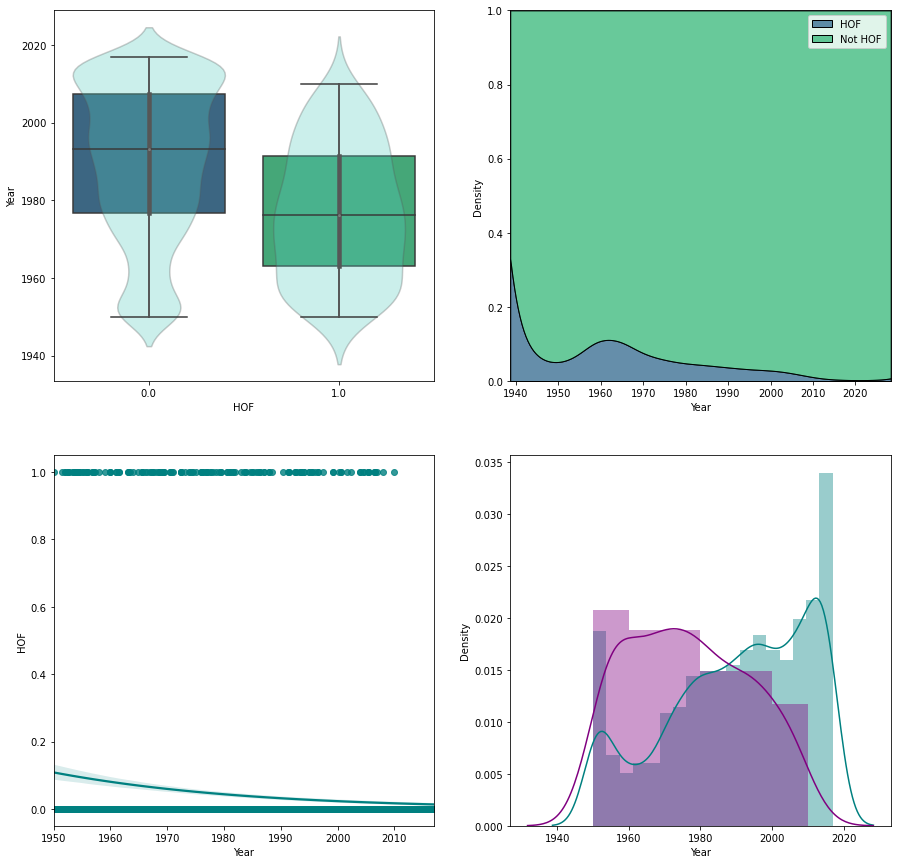

Pearson correlation of G_average to target HOF: 0.2388090854775363

*** Results for G_average ***
      count       mean        std   min        25%        50%        75%  \
HOF                                                                        
0.0  3794.0  39.124532  21.775252   1.0  21.000000  41.000000  57.416667   
1.0   154.0  66.340246   9.565467  11.0  62.558271  67.320513  72.645833   

         max  
HOF           
0.0  82.0000  
1.0  81.4375  
t-statistic: 32.1, p-value: 1.09e-85
None


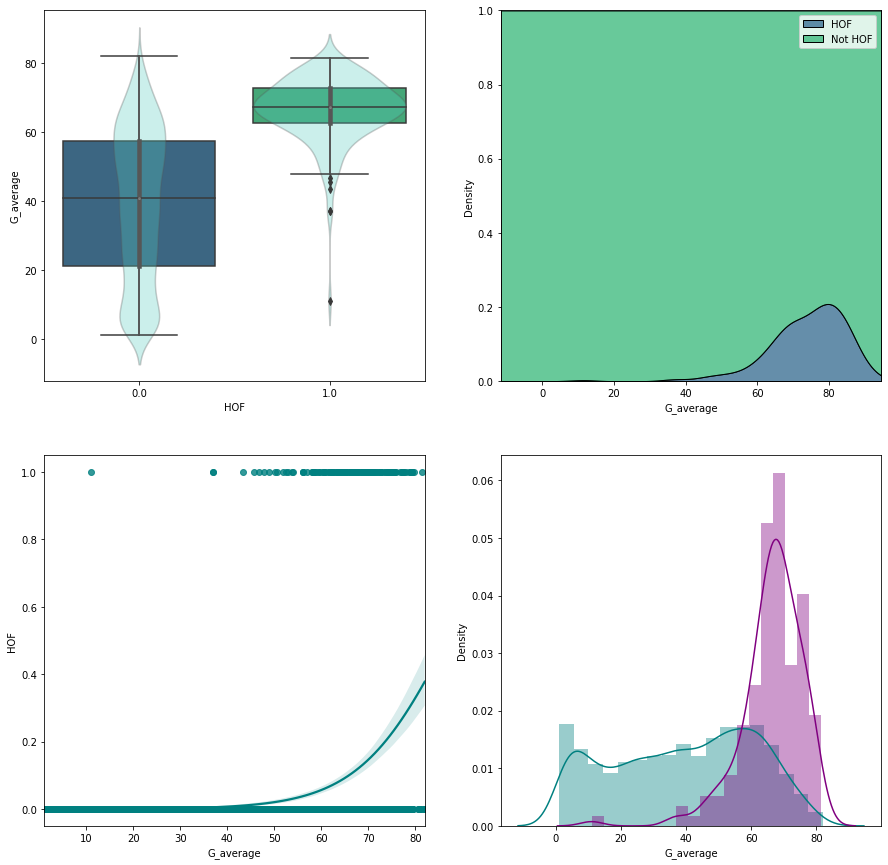

Pearson correlation of GS_average to target HOF: 0.33144229758789856

*** Results for GS_average ***
      count       mean        std  min        25%      50%        75%     max
HOF                                                                          
0.0  2673.0  14.125692  17.780889  0.0   0.000000   6.0000  22.666667  82.000
1.0    76.0  52.384001  20.554252  0.0  43.984375  59.4375  66.760181  78.125
t-statistic: nan, p-value: nan
None


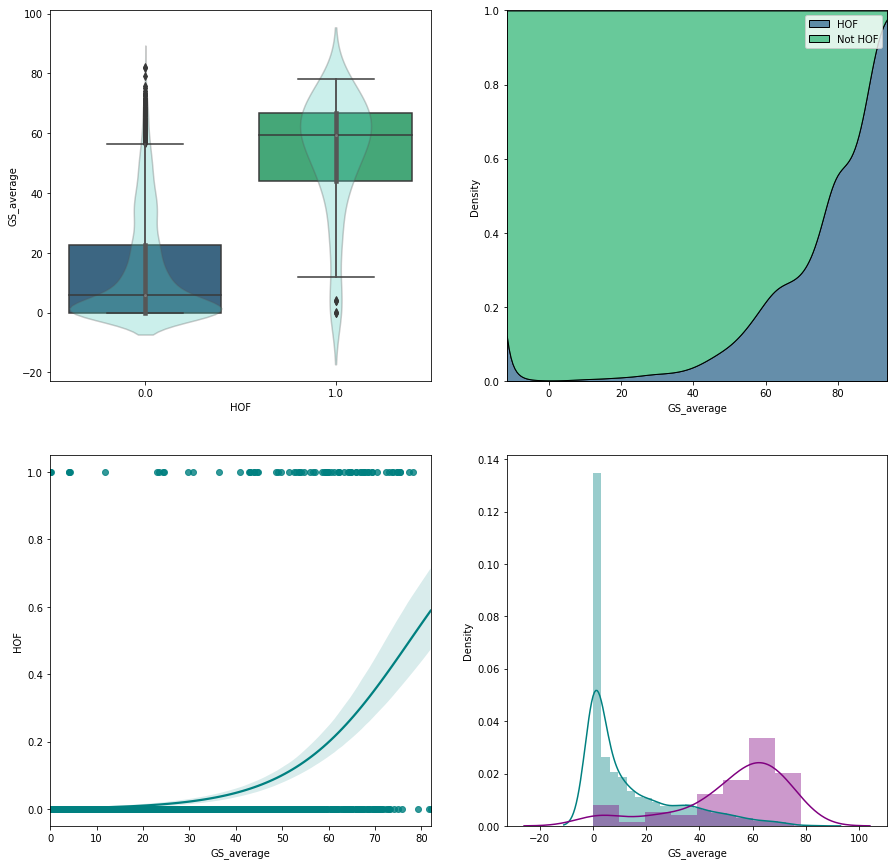

Pearson correlation of MP_average to target HOF: 0.3824616958985679

*** Results for MP_average ***
      count         mean         std    min          25%          50%  \
HOF                                                                     
0.0  3642.0   767.902984  661.967009    0.0   171.500000   600.854167   
1.0   153.0  2149.811150  519.515064  126.0  1944.555556  2256.277778   

             75%     max  
HOF                       
0.0  1239.397727  2954.0  
1.0  2456.777778  3190.6  
t-statistic: nan, p-value: nan
None


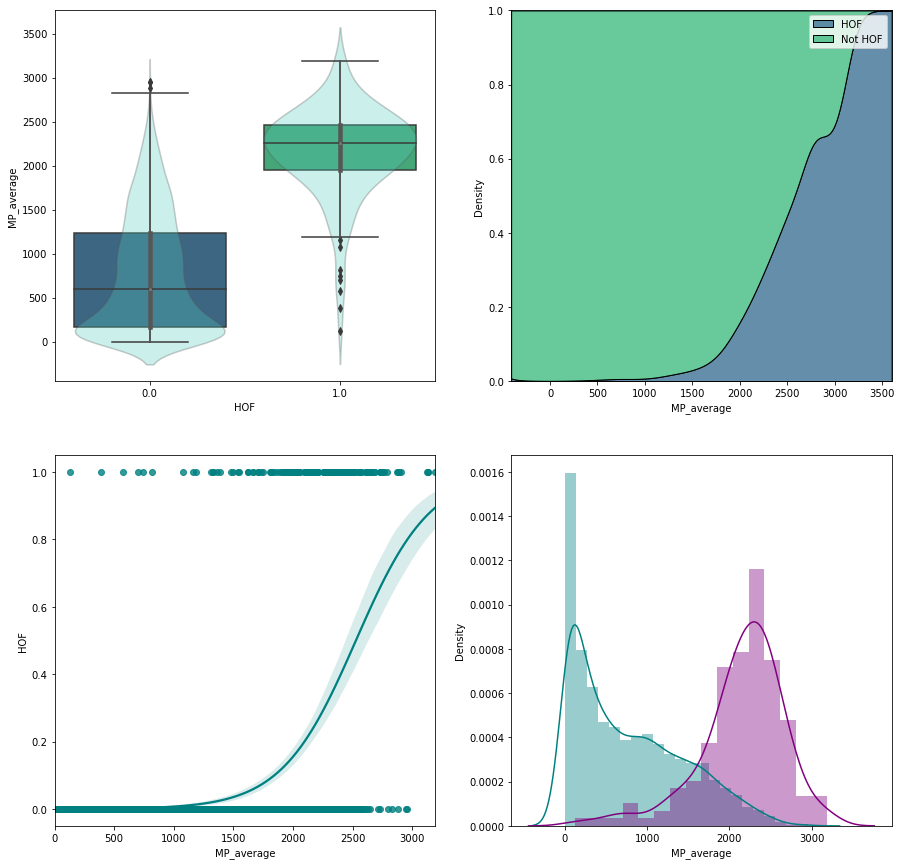

Pearson correlation of PER to target HOF: 0.22178936278723704

*** Results for PER ***
      count       mean       std        min        25%        50%        75%  \
HOF                                                                            
0.0  3639.0  10.438258  6.383408 -48.600000   8.200000  10.987500  13.391319   
1.0   153.0  17.718404  3.783923   6.966667  15.641667  17.745455  20.075000   

           max  
HOF             
0.0  88.300000  
1.0  27.373333  
t-statistic: nan, p-value: nan
None


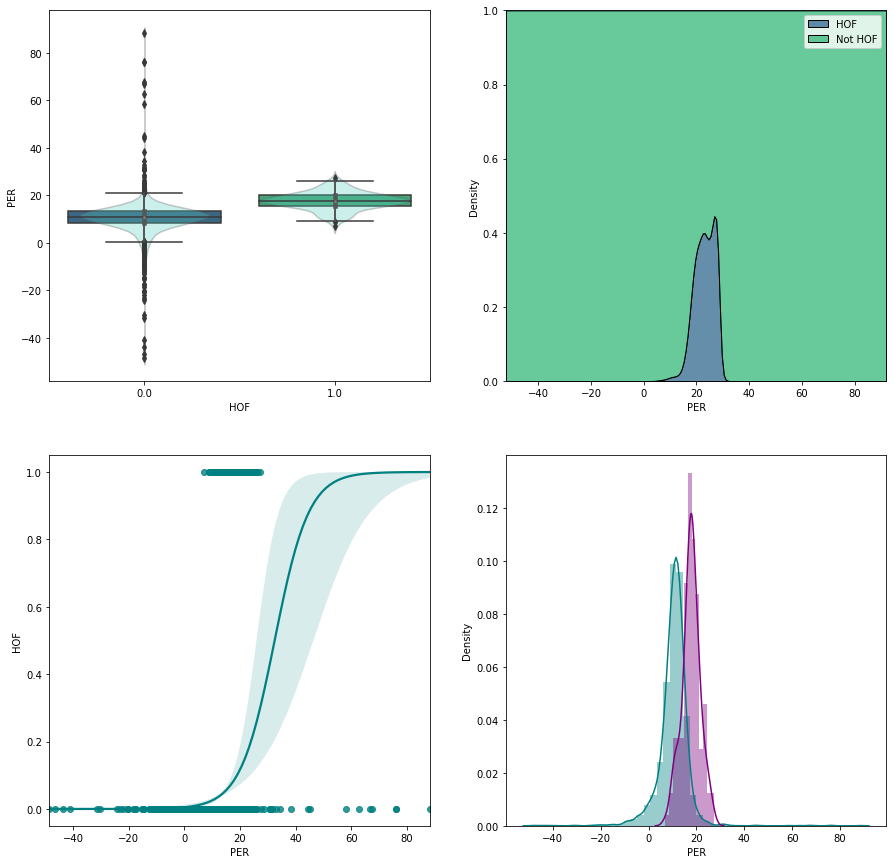

Pearson correlation of TS% to target HOF: 0.1023502614492637

*** Results for TS% ***
      count      mean       std     min       25%       50%       75%  \
HOF                                                                     
0.0  3781.0  0.460895  0.103908  0.0000  0.418833  0.478500  0.519750   
1.0   154.0  0.515222  0.053679  0.3598  0.480475  0.517258  0.555989   

          max  
HOF            
0.0  1.136000  
1.0  0.635154  
t-statistic: nan, p-value: nan
None


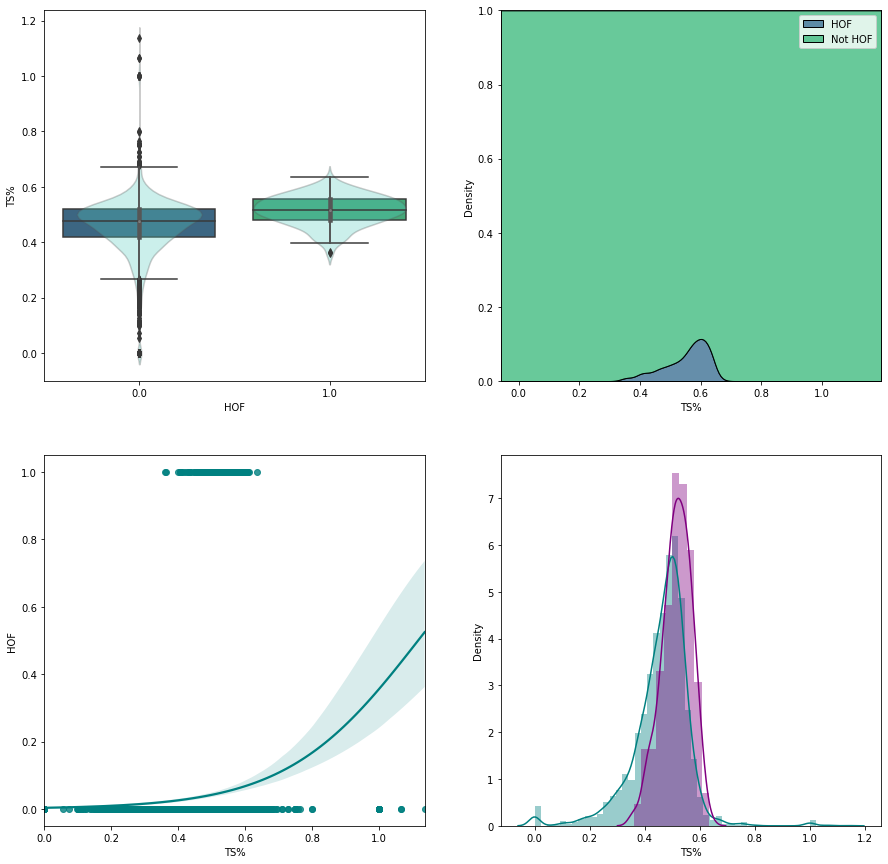

Pearson correlation of 3PAr to target HOF: -0.07274220349115605

*** Results for 3PAr ***
      count      mean       std  min       25%       50%       75%       max
HOF                                                                         
0.0  2768.0  0.156917  0.178654  0.0  0.007000  0.076958  0.284157  1.000000
1.0    82.0  0.079743  0.102451  0.0  0.007245  0.027222  0.124594  0.402316
t-statistic: nan, p-value: nan
None


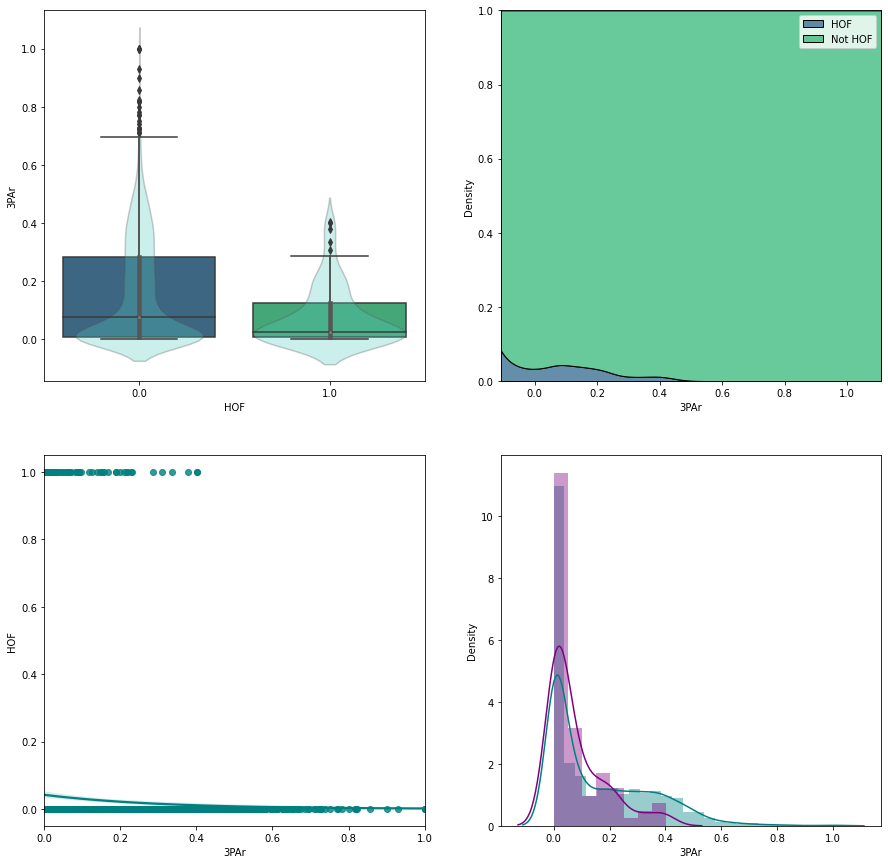

Pearson correlation of FTr to target HOF: 0.05289153593669834

*** Results for FTr ***
      count      mean       std       min       25%       50%       75%  \
HOF                                                                       
0.0  3780.0  0.329920  0.219878  0.000000  0.207000  0.291500  0.403115   
1.0   154.0  0.389144  0.122655  0.159333  0.298942  0.366571  0.447594   

        max  
HOF          
0.0  3.0000  
1.0  0.9455  
t-statistic: nan, p-value: nan
None


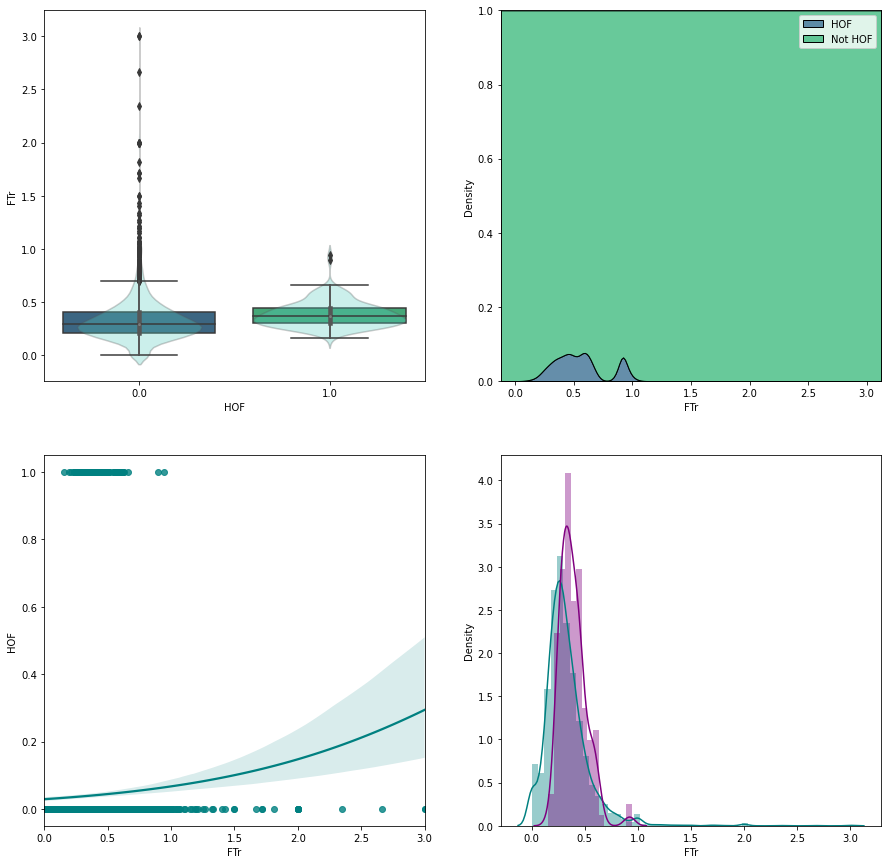

Pearson correlation of ORB% to target HOF: -0.008906542101096761

*** Results for ORB% ***
      count      mean       std       min   25%       50%       75%  \
HOF                                                                   
0.0  3062.0  6.485119  5.405204  0.000000  2.75  5.726786  9.100000   
1.0   103.0  6.216730  3.204181  1.633333  3.35  6.071429  8.065909   

            max  
HOF              
0.0  100.000000  
1.0   16.735714  
t-statistic: nan, p-value: nan
None


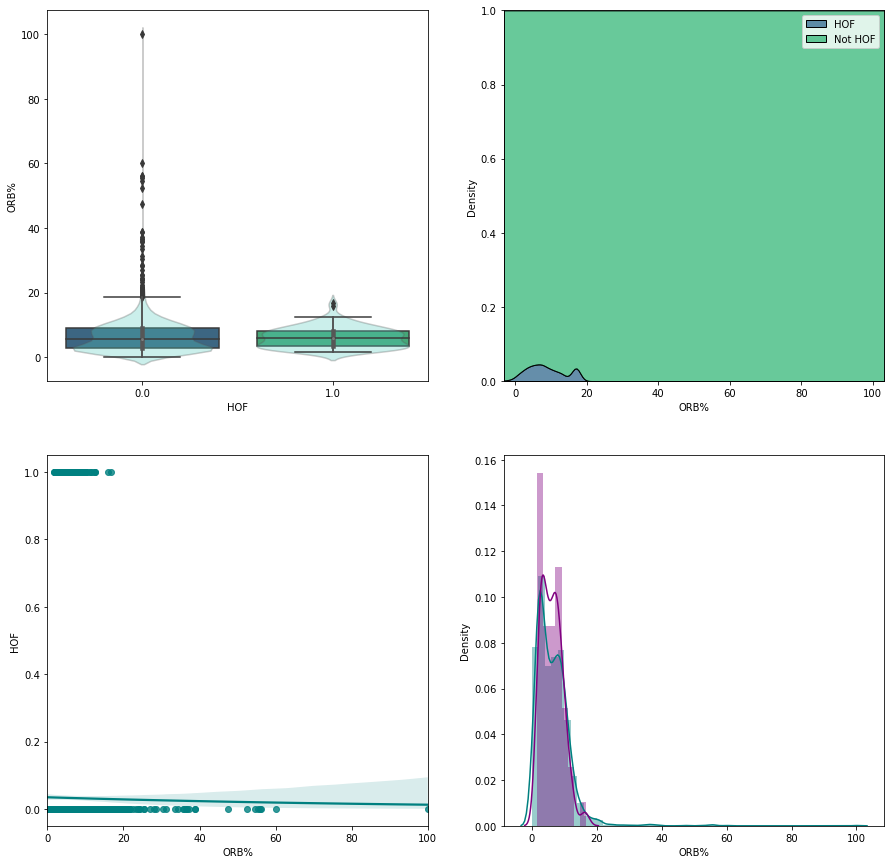

Pearson correlation of DRB% to target HOF: 0.06372623278174279

*** Results for DRB% ***
      count       mean       std   min       25%        50%        75%  \
HOF                                                                      
0.0  3062.0  13.200028  6.587337  0.00  8.541346  12.269048  17.500000   
1.0   103.0  15.575938  7.088419  4.15  9.287778  14.760000  22.376923   

            max  
HOF              
0.0  100.000000  
1.0   29.492857  
t-statistic: nan, p-value: nan
None


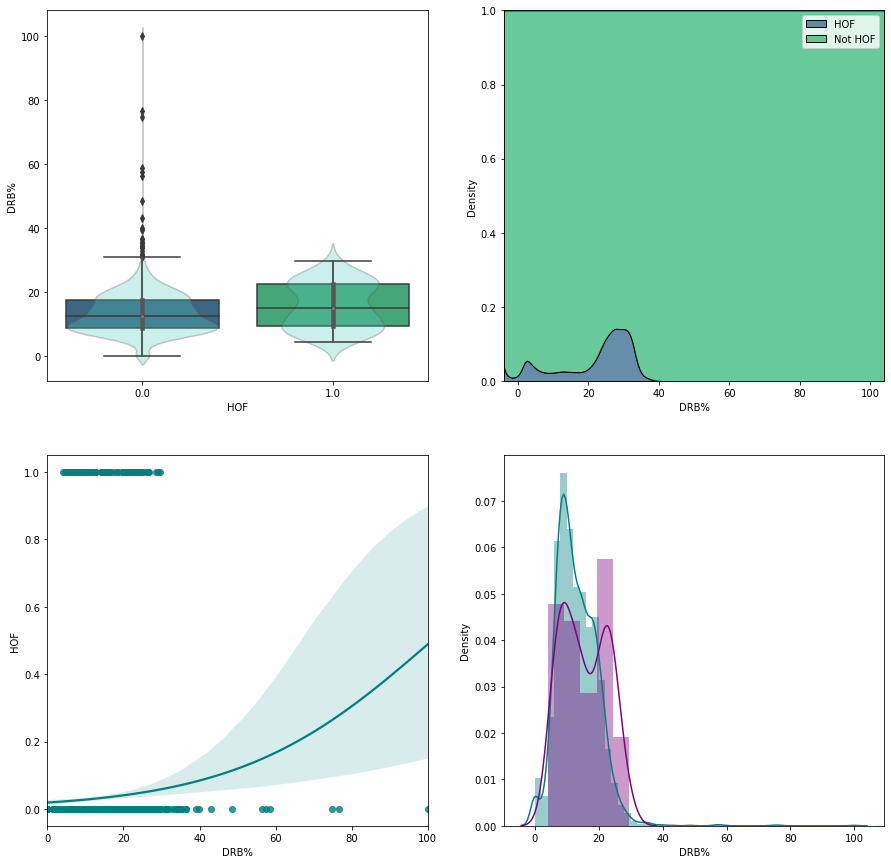

Pearson correlation of TRB% to target HOF: 0.04347091383626531

*** Results for TRB% ***
      count       mean       std  min       25%        50%        75%  \
HOF                                                                     
0.0  3184.0   9.831993  5.192280  0.0  5.978750   9.100000  13.062857   
1.0   109.0  11.092484  4.935712  3.3  6.426316  10.333333  15.435714   

           max  
HOF             
0.0  86.400000  
1.0  23.185714  
t-statistic: nan, p-value: nan
None


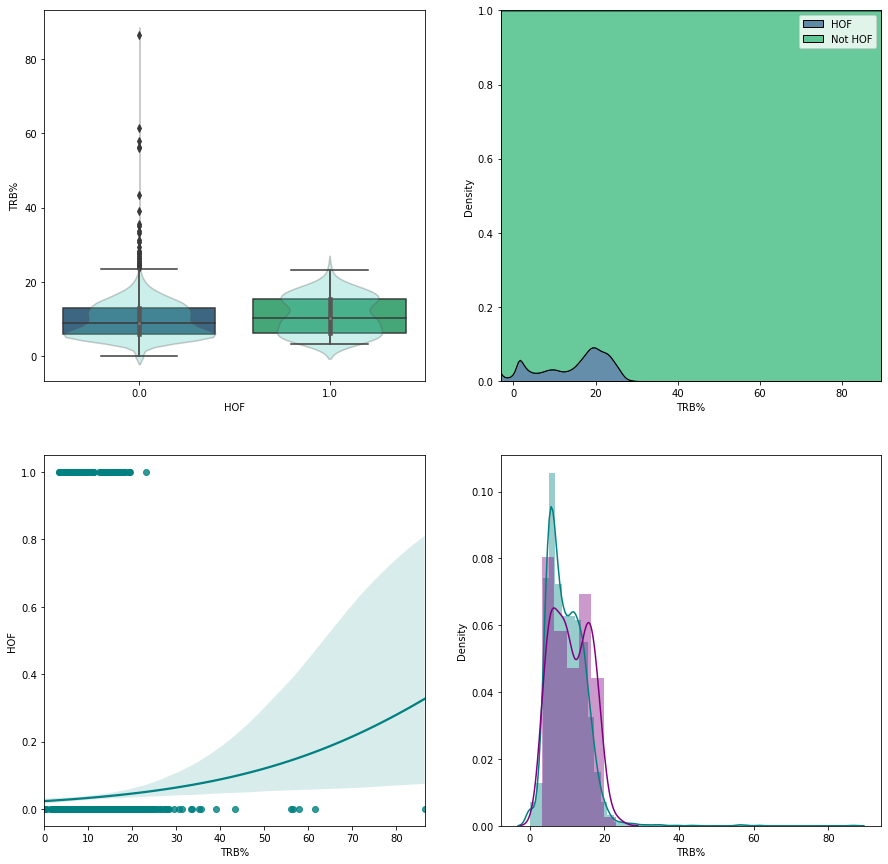

Pearson correlation of AST% to target HOF: 0.107283374630196

*** Results for AST% ***
      count       mean       std  min        25%        50%        75%  \
HOF                                                                      
0.0  3304.0  11.778419  8.349295  0.0   6.075000   9.629167  15.638839   
1.0   122.0  16.639556  8.393368  4.3  10.386898  15.171429  20.572500   

            max  
HOF              
0.0  100.000000  
1.0   49.431579  
t-statistic: nan, p-value: nan
None


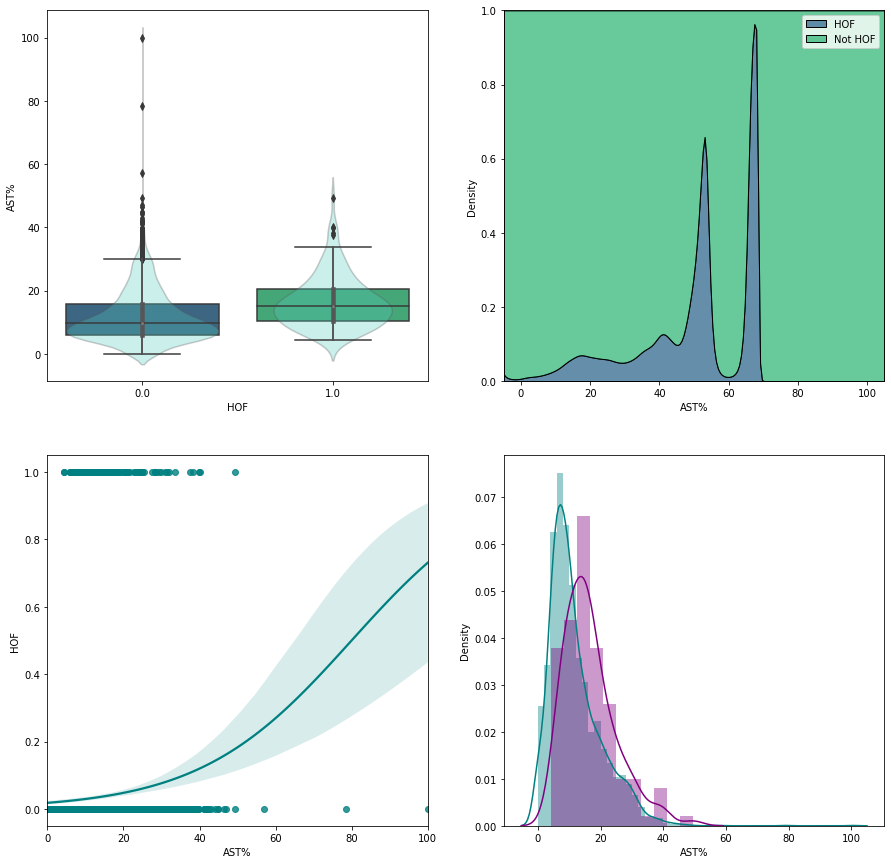

Pearson correlation of STL% to target HOF: 0.013405725715434214

*** Results for STL% ***
      count      mean       std   min       25%       50%       75%   max
HOF                                                                      
0.0  3062.0  1.644162  1.099208  0.00  1.075000  1.500000  2.044048  13.4
1.0   103.0  1.726329  0.659632  0.45  1.275595  1.683333  2.136364   3.6
t-statistic: nan, p-value: nan
None


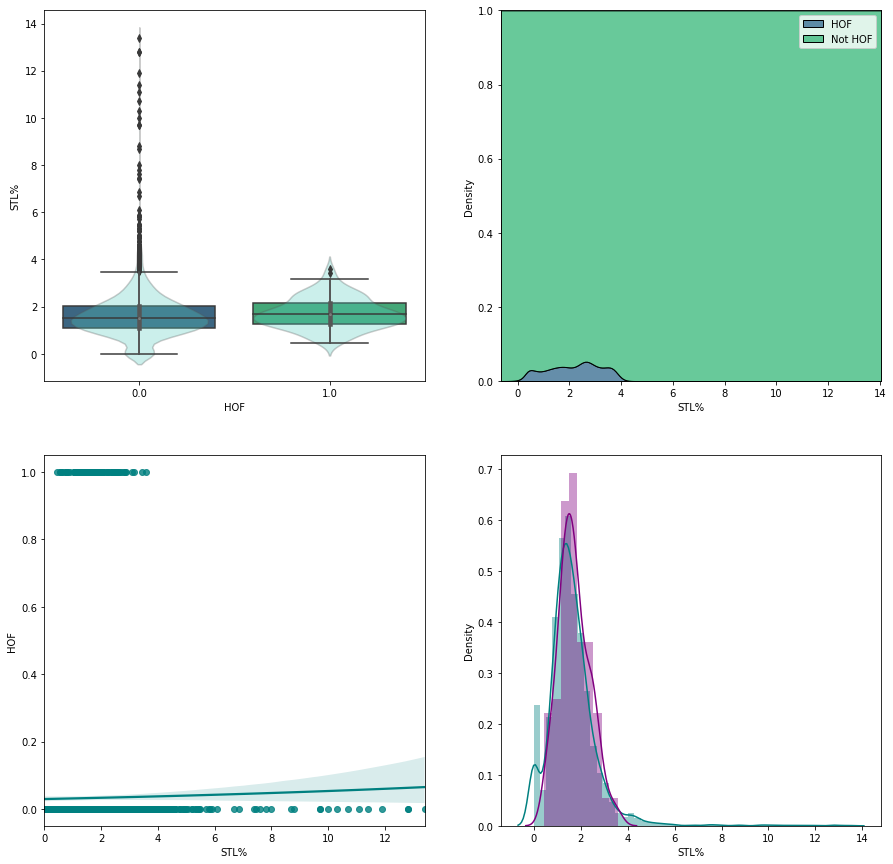

Pearson correlation of BLK% to target HOF: 0.0391338926512763

*** Results for BLK% ***
      count      mean       std  min       25%       50%       75%       max
HOF                                                                         
0.0  3062.0  1.310683  1.530625  0.0  0.325000  0.825000  1.743333  26.30000
1.0   103.0  1.648635  1.561498  0.1  0.457519  1.142857  2.408333   6.88125
t-statistic: nan, p-value: nan
None


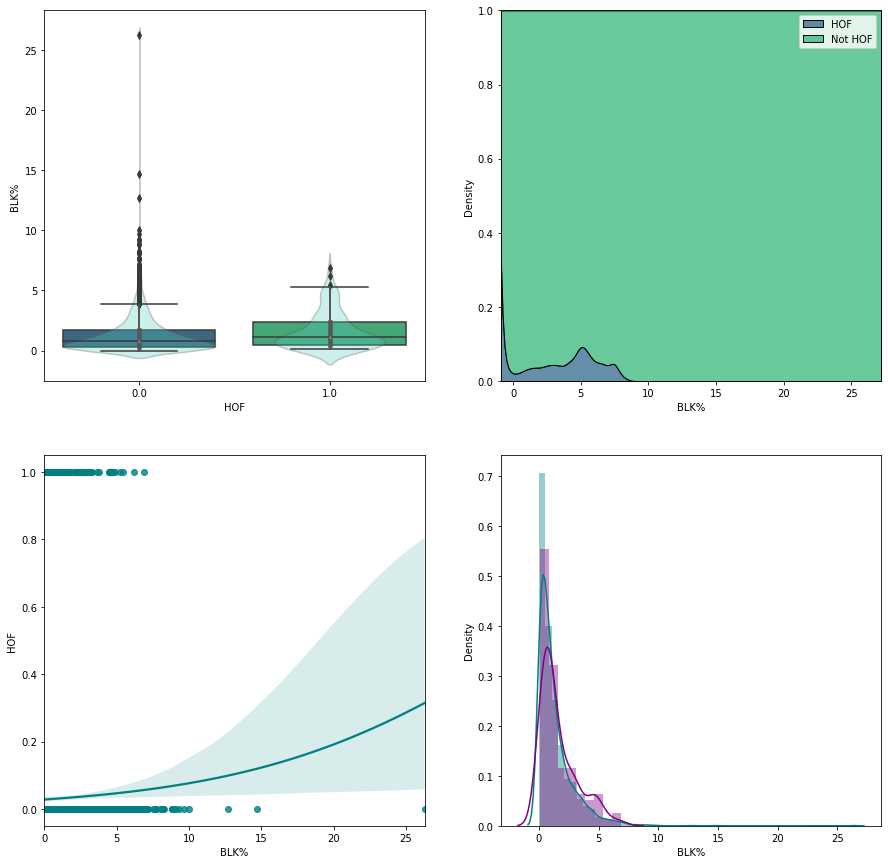

Pearson correlation of TOV% to target HOF: -0.030226516506916507

*** Results for TOV% ***
      count       mean       std       min        25%        50%        75%  \
HOF                                                                           
0.0  2870.0  15.736376  7.299506  0.000000  11.903571  14.800000  18.471875   
1.0    86.0  14.439354  2.938045  9.293333  12.558242  13.792157  16.202647   

        max  
HOF          
0.0  100.00  
1.0   22.25  
t-statistic: nan, p-value: nan
None


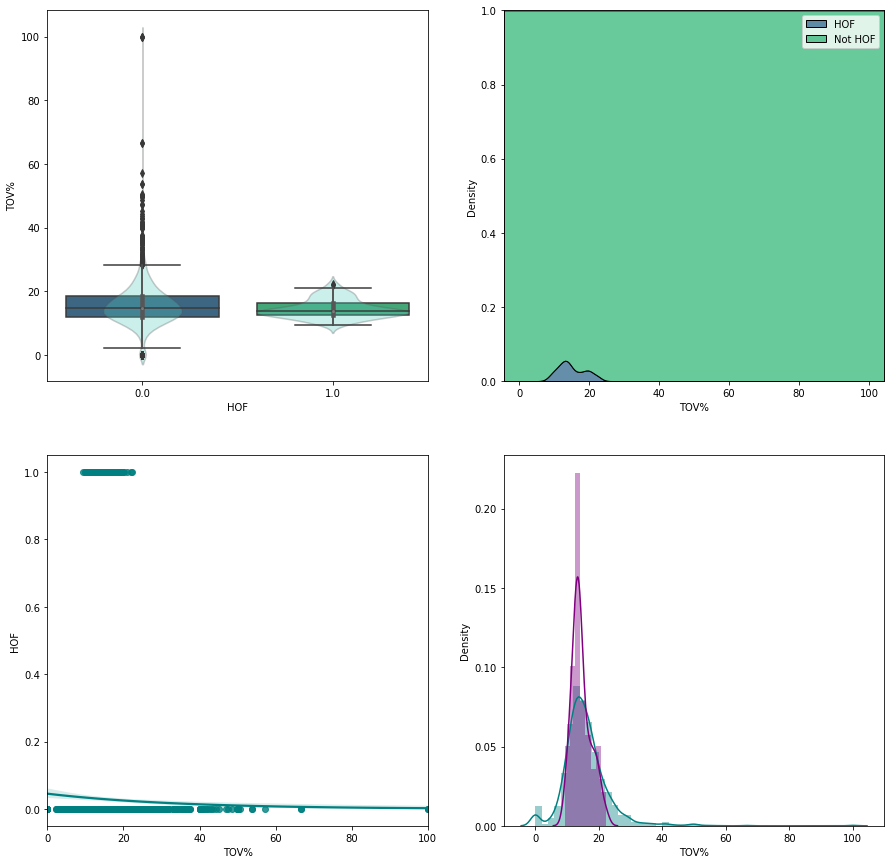

Pearson correlation of USG% to target HOF: 0.13607318084235748

*** Results for USG% ***
      count       mean       std        min        25%      50%        75%  \
HOF                                                                          
0.0  2877.0  18.808266  5.034100   0.000000  15.700000  18.5000  21.433333   
1.0    86.0  22.913564  4.492008  10.711765  20.723214  23.0375  25.663038   

      max  
HOF        
0.0  56.6  
1.0  33.6  
t-statistic: nan, p-value: nan
None


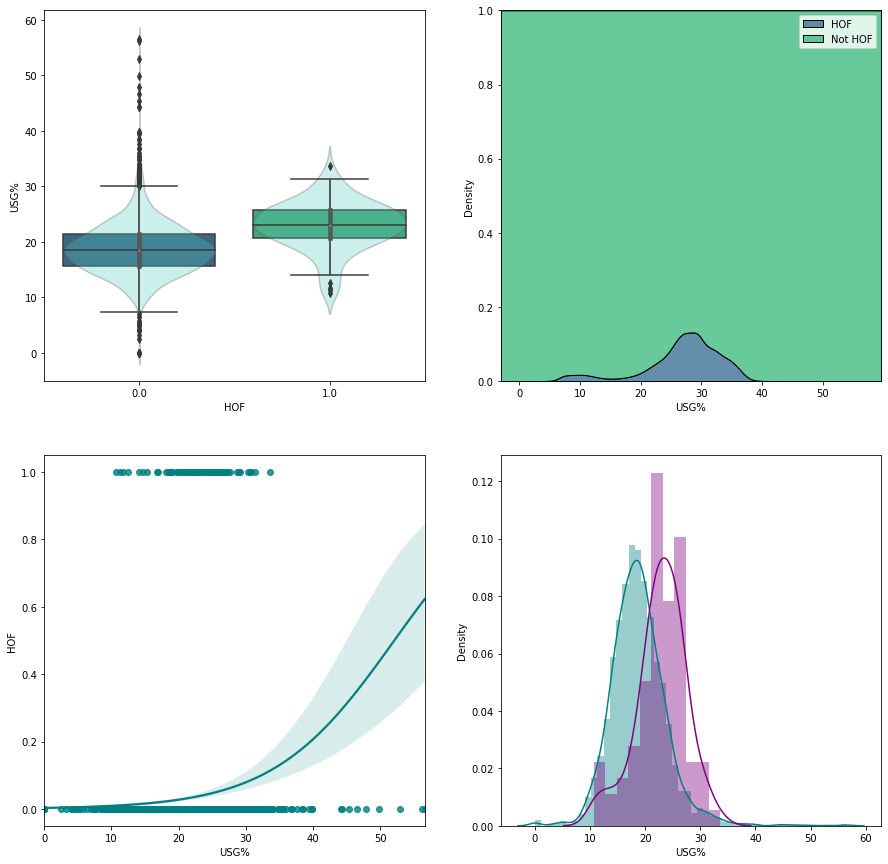

Pearson correlation of OWS_average to target HOF: 0.470859392001751

*** Results for OWS_average ***
      count      mean       std   min       25%       50%       75%    max
HOF                                                                       
0.0  3793.0  0.526989  1.144816 -3.70 -0.100000  0.100000  0.914286  15.60
1.0   154.0  3.901264  2.485549 -2.22  2.348438  3.733333  5.365625  10.85
t-statistic: nan, p-value: nan
None


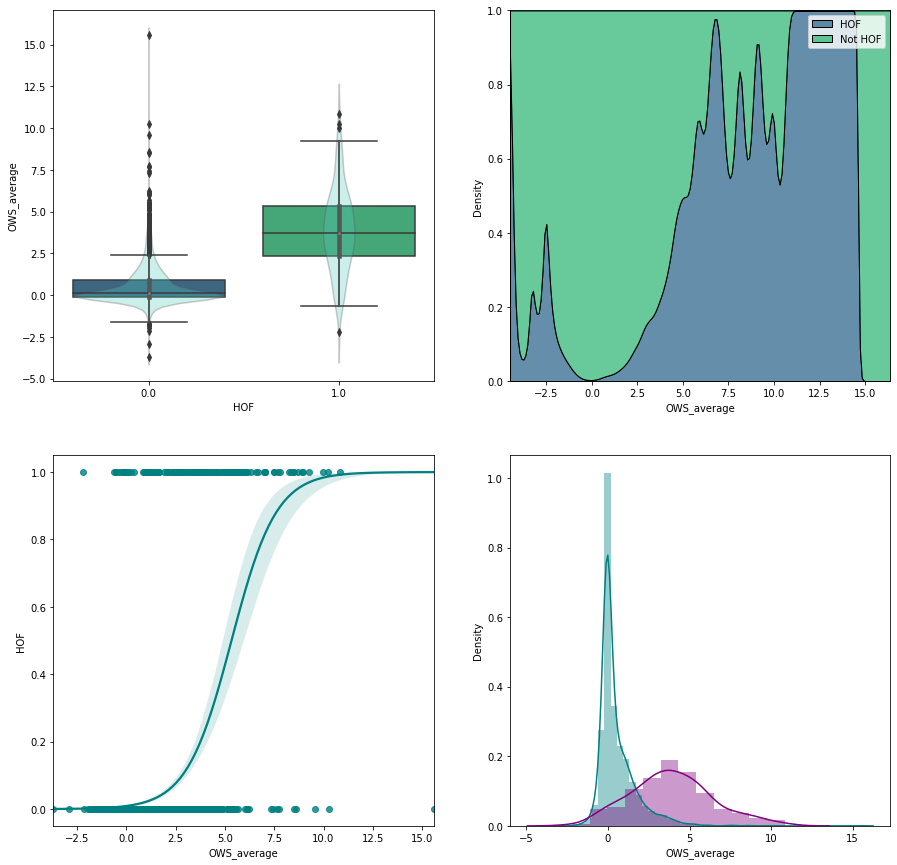

Pearson correlation of DWS_average to target HOF: 0.45169524750363693

*** Results for DWS_average ***
      count      mean       std  min       25%       50%       75%        max
HOF                                                                          
0.0  3793.0  0.719758  0.747292 -0.9  0.100000  0.475000  1.120000   5.200000
1.0   154.0  2.762311  1.379390  0.2  1.891667  2.552885  3.428269  10.276923
t-statistic: nan, p-value: nan
None


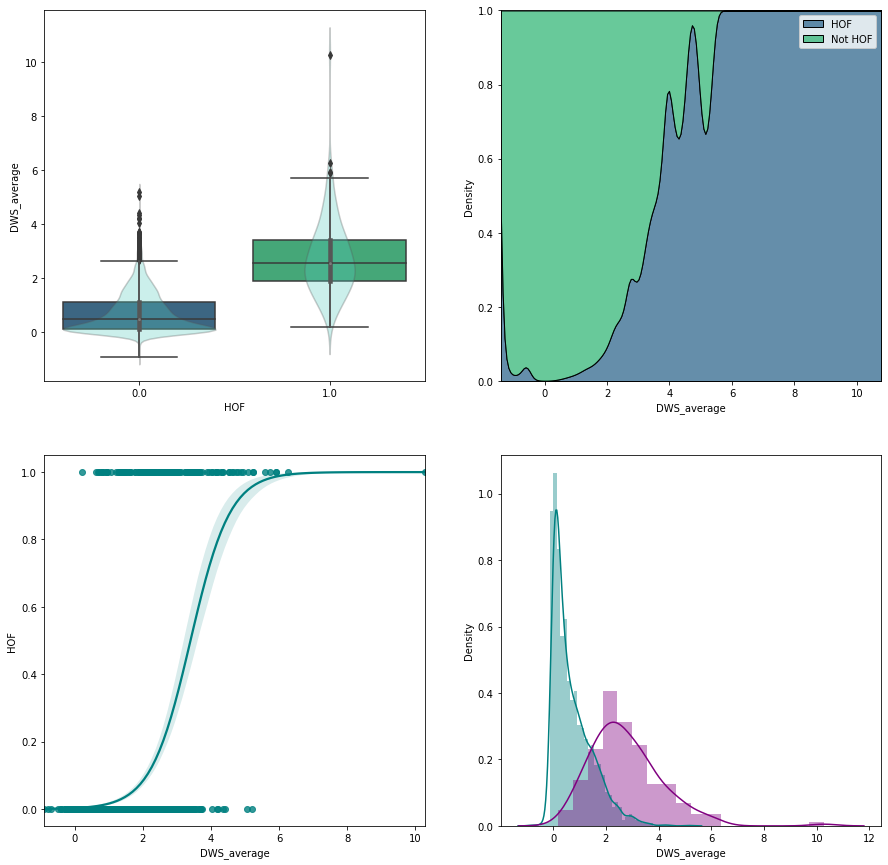

Pearson correlation of WS_average to target HOF: 0.5070855084454169

*** Results for WS_average ***
      count      mean       std   min       25%       50%       75%    max
HOF                                                                       
0.0  3793.0  1.248622  1.711106 -1.75  0.000000  0.600000  2.000000  17.95
1.0   154.0  6.662201  3.054516 -0.14  4.869805  6.484615  8.245312  16.48
t-statistic: nan, p-value: nan
None


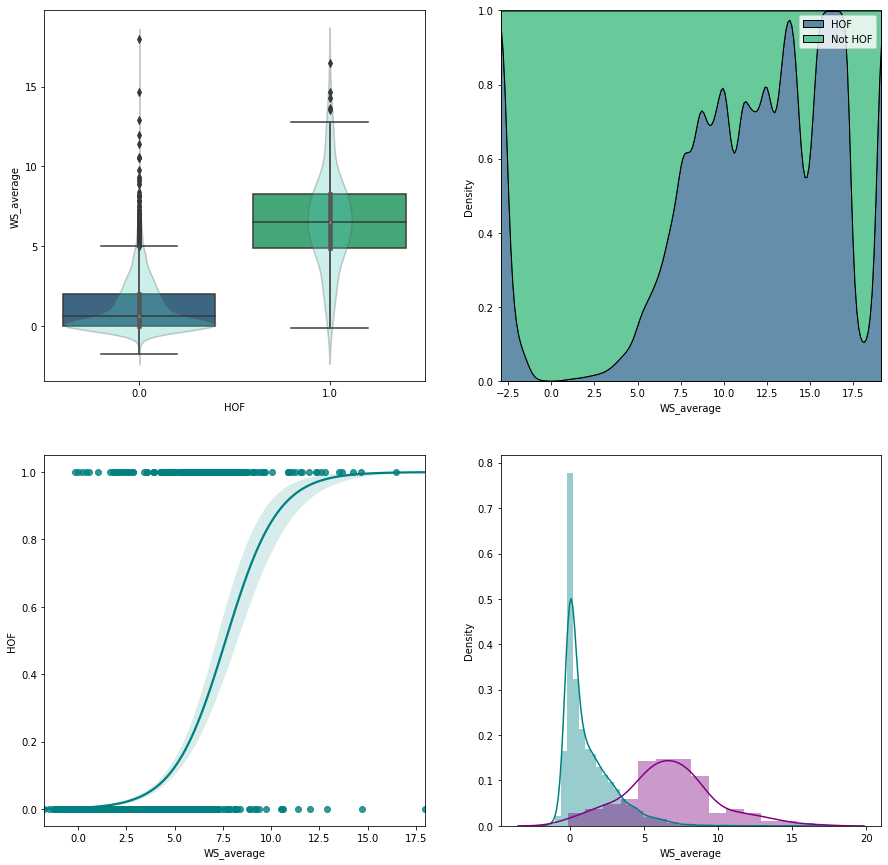

Pearson correlation of WS/48 to target HOF: 0.1722353409765193

*** Results for WS/48 ***
      count      mean       std    min     25%       50%       75%    max
HOF                                                                      
0.0  3639.0  0.027954  0.121438 -2.062 -0.0035  0.046400  0.083760  1.442
1.0   153.0  0.134082  0.053967 -0.077  0.1070  0.136308  0.169409  0.318
t-statistic: nan, p-value: nan
None


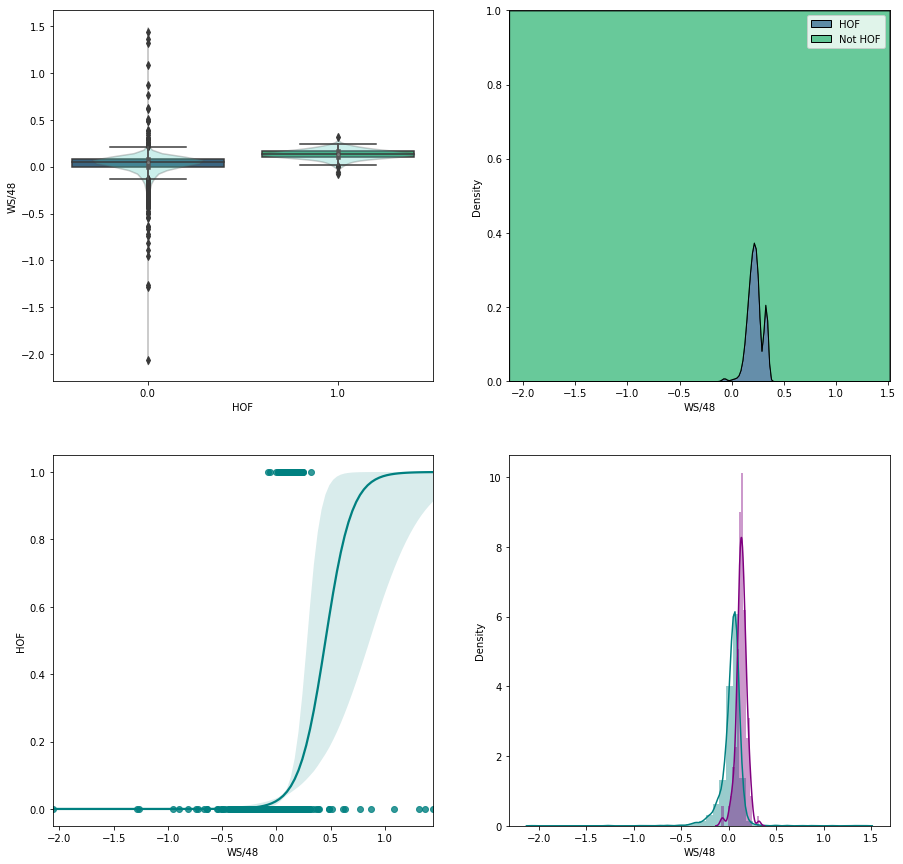

Pearson correlation of OBPM to target HOF: 0.1940335365682578

*** Results for OBPM ***
      count      mean       std   min      25%   50%       75%        max
HOF                                                                      
0.0  3064.0 -3.071475  3.862868 -46.4 -4.46875 -2.65 -1.011648  39.800000
1.0   103.0  1.186102  2.140012  -5.4  0.09375  1.30  2.592500   6.453333
t-statistic: nan, p-value: nan
None


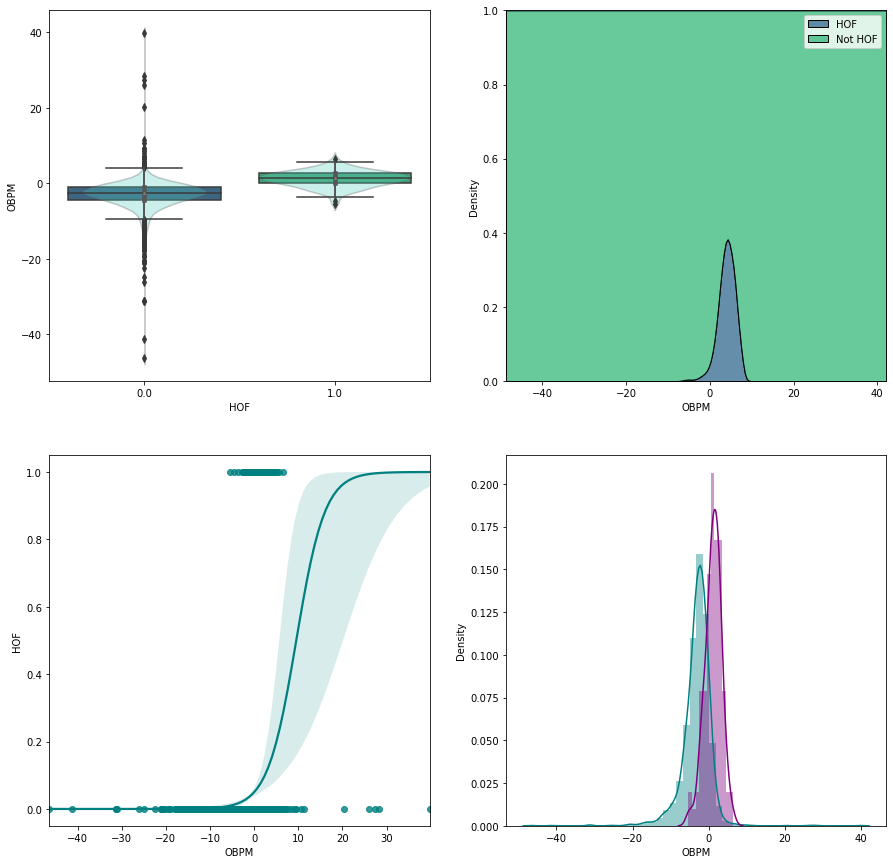

Pearson correlation of DBPM to target HOF: 0.11979357796965616

*** Results for DBPM ***
      count      mean       std   min       25%       50%     75%        max
HOF                                                                         
0.0  3064.0 -1.095237  2.270365 -23.3 -2.128571 -0.966667  0.1675  17.100000
1.0   103.0  0.439195  1.789158  -3.7 -1.004167  0.368421  1.7000   4.847059
t-statistic: nan, p-value: nan
None


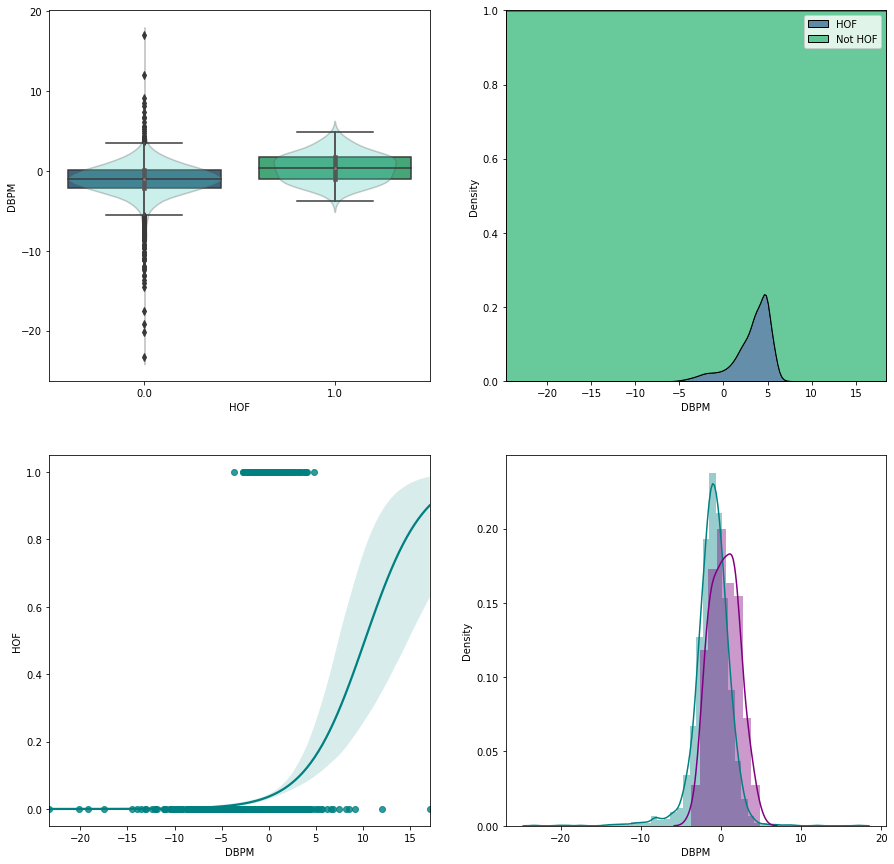

Pearson correlation of BPM to target HOF: 0.21032664343509486

*** Results for BPM ***
      count      mean       std    min       25%   50%       75%    max
HOF                                                                    
0.0  3064.0 -4.166738  4.836481 -53.60 -5.950000 -3.45 -1.368590  26.60
1.0   103.0  1.628153  2.524928  -8.35  0.329167  1.60  2.932566   7.46
t-statistic: nan, p-value: nan
None


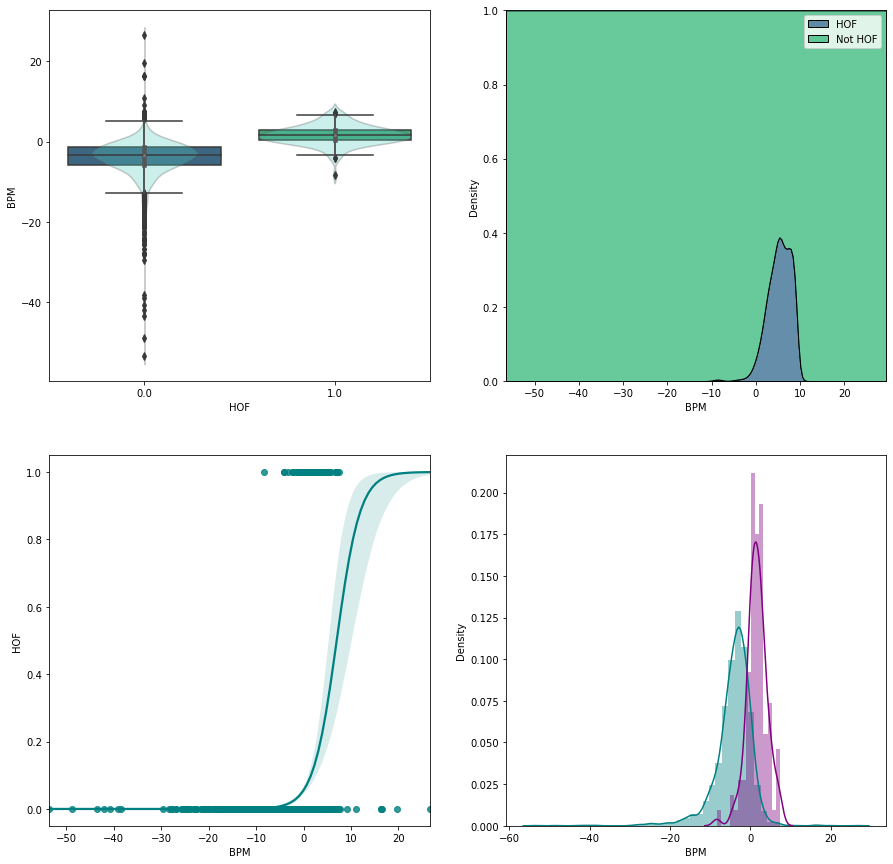

Pearson correlation of VORP_average to target HOF: 0.46892786860325264

*** Results for VORP_average ***
      count      mean       std  min       25%       50%       75%       max
HOF                                                                         
0.0  3064.0  0.183192  0.710734 -1.2 -0.166667 -0.033333  0.300000  8.285714
1.0   103.0  2.423917  1.494251 -0.8  1.546875  2.350000  3.194375  6.966667
t-statistic: nan, p-value: nan
None


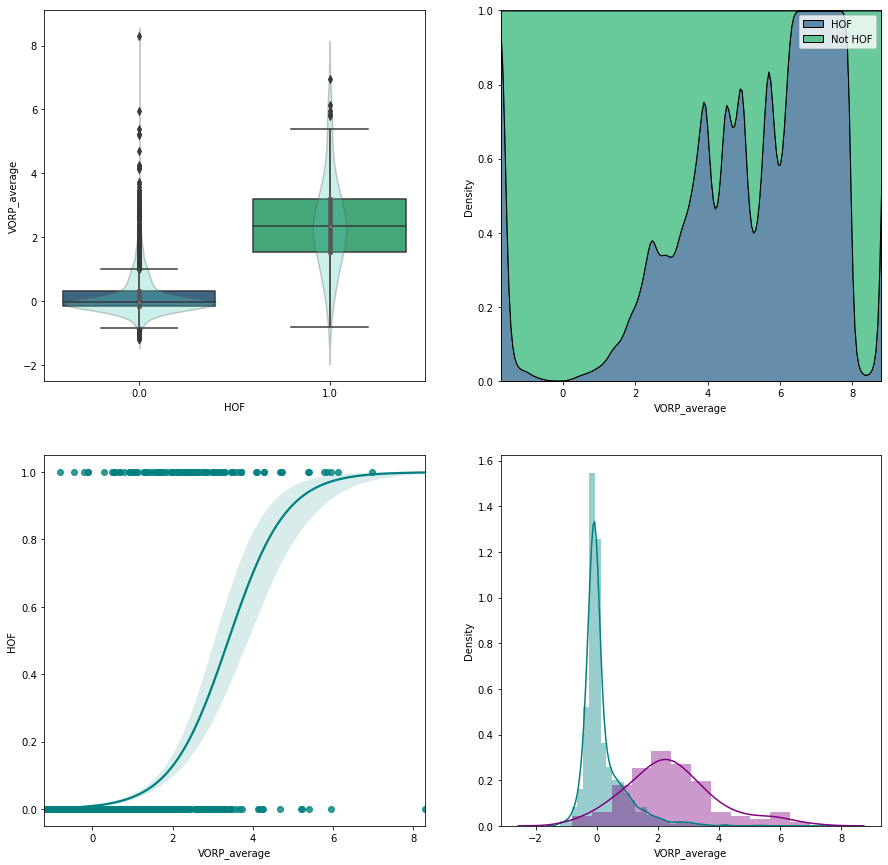

Pearson correlation of FG_average to target HOF: 0.44799143795647284

*** Results for FG_average ***
      count        mean         std   min         25%         50%         75%  \
HOF                                                                             
0.0  3794.0  115.158652  116.351190   0.0   22.000000   78.100000  174.590909   
1.0   154.0  421.742785  162.743057  13.0  317.918269  433.863636  526.486607   

       max  
HOF         
0.0  744.5  
1.0  845.4  
t-statistic: 23.1, p-value: 7.85e-53
None


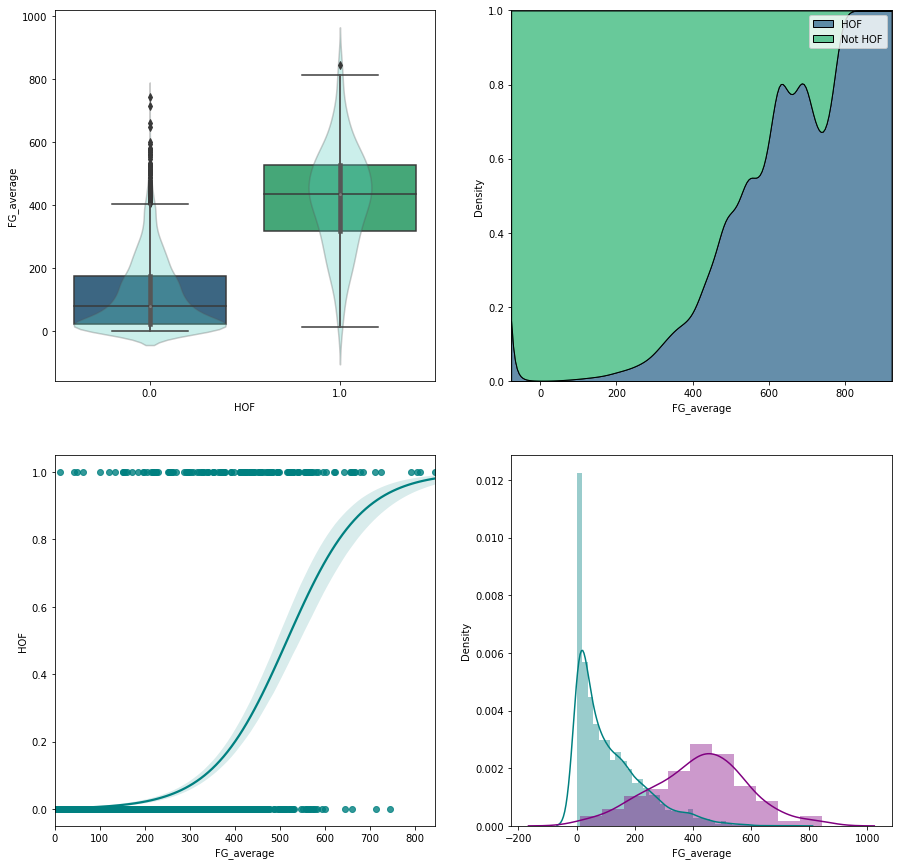

Pearson correlation of FGA_average to target HOF: 0.44089639465468633

*** Results for FGA_average ***
      count        mean         std   min         25%       50%          75%  \
HOF                                                                            
0.0  3794.0  262.687849  253.255619   0.0   55.000000  185.3125   401.305556   
1.0   154.0  912.807137  322.867621  35.0  716.877193  946.1250  1130.175339   

             max  
HOF               
0.0  1485.928571  
1.0  1635.800000  
t-statistic: 24.7, p-value: 1.49e-56
None


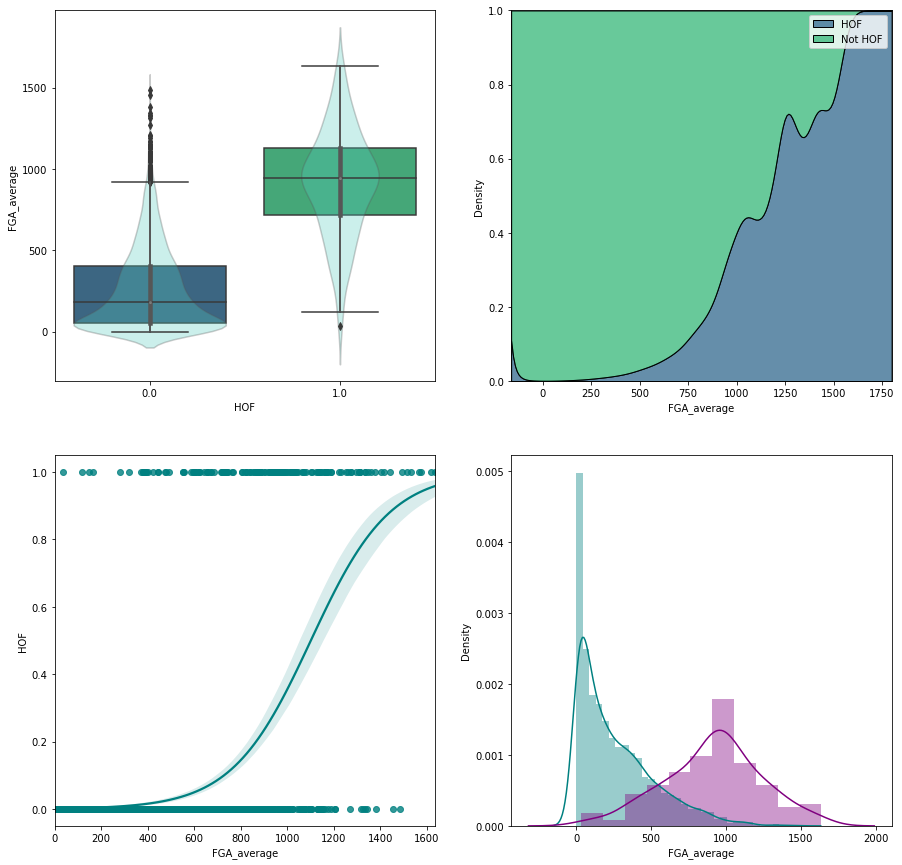

Pearson correlation of FG% to target HOF: 0.0933624165651608

*** Results for FG% ***
      count      mean       std    min       25%       50%     75%       max
HOF                                                                         
0.0  3780.0  0.402382  0.105596  0.000  0.358000  0.413464  0.4570  1.000000
1.0   154.0  0.452710  0.056336  0.284  0.423021  0.456397  0.4915  0.596538
t-statistic: nan, p-value: nan
None


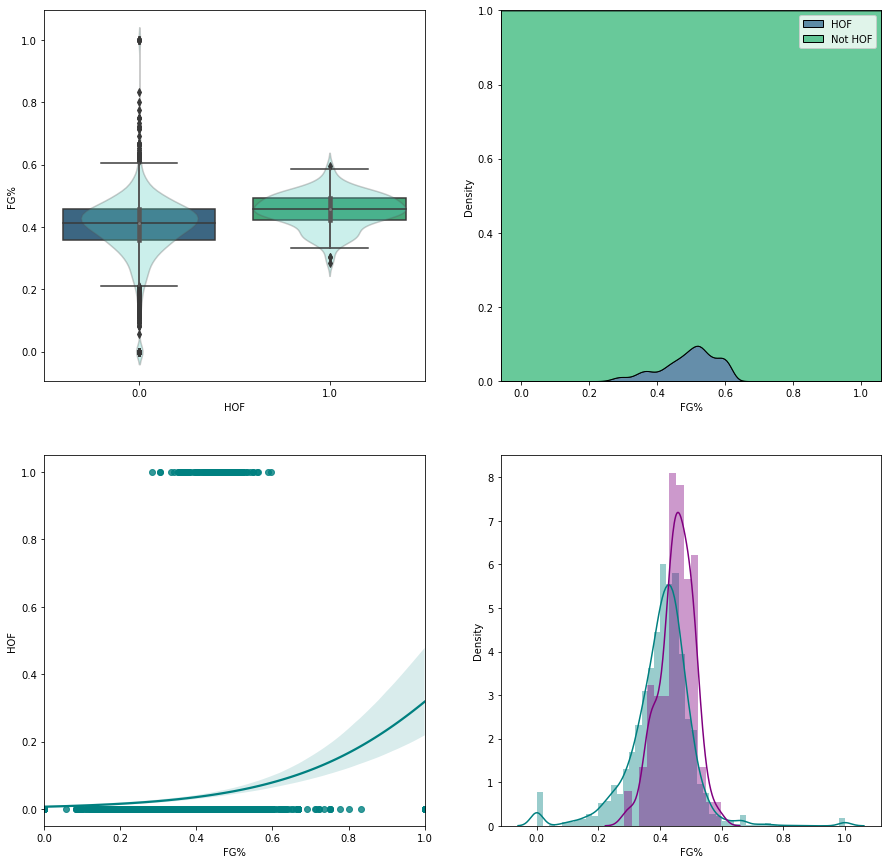

Pearson correlation of 3P_average to target HOF: 0.0522794857249326

*** Results for 3P_average ***
      count       mean        std  min   25%       50%       75%         max
HOF                                                                         
0.0  2781.0  14.759581  26.315236  0.0  0.00  1.750000  17.00000  239.625000
1.0    82.0  23.106096  35.054776  0.0  0.75  4.536842  37.45625  156.473684
t-statistic: nan, p-value: nan
None


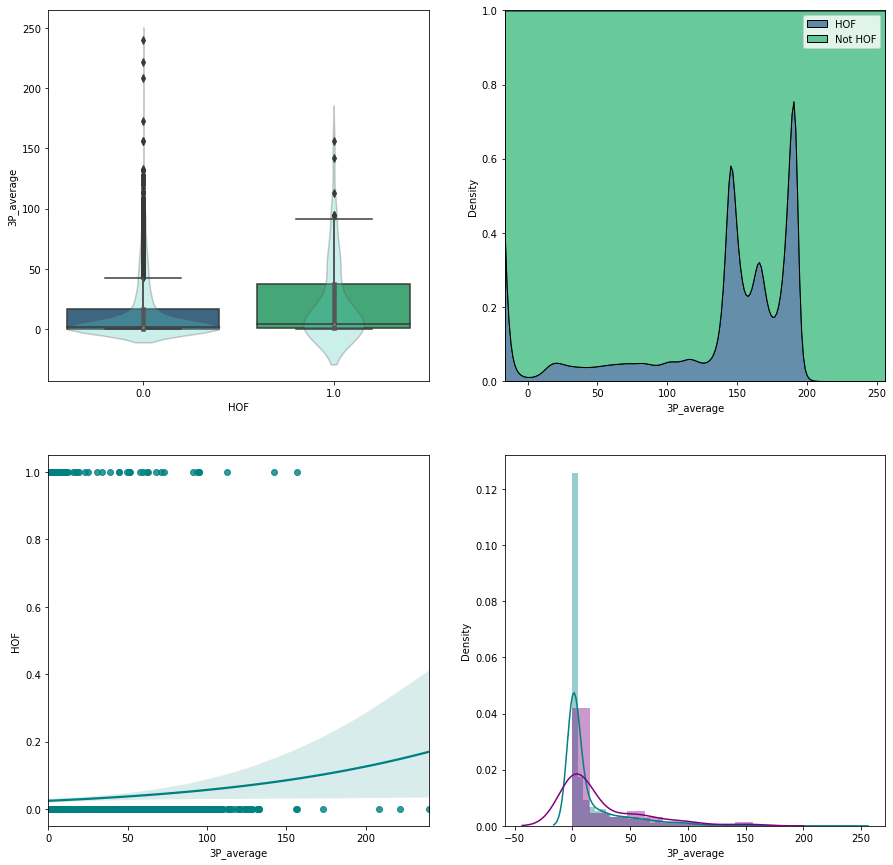

Pearson correlation of 3PA_average to target HOF: 0.056513819308726024

*** Results for 3PA_average ***
      count       mean        std  min       25%        50%         75%    max
HOF                                                                           
0.0  2781.0  43.151953  71.700767  0.0  1.000000   7.636364   52.375000  563.4
1.0    82.0  67.720678  93.877626  0.0  5.621875  16.800000  116.436842  391.0
t-statistic: nan, p-value: nan
None


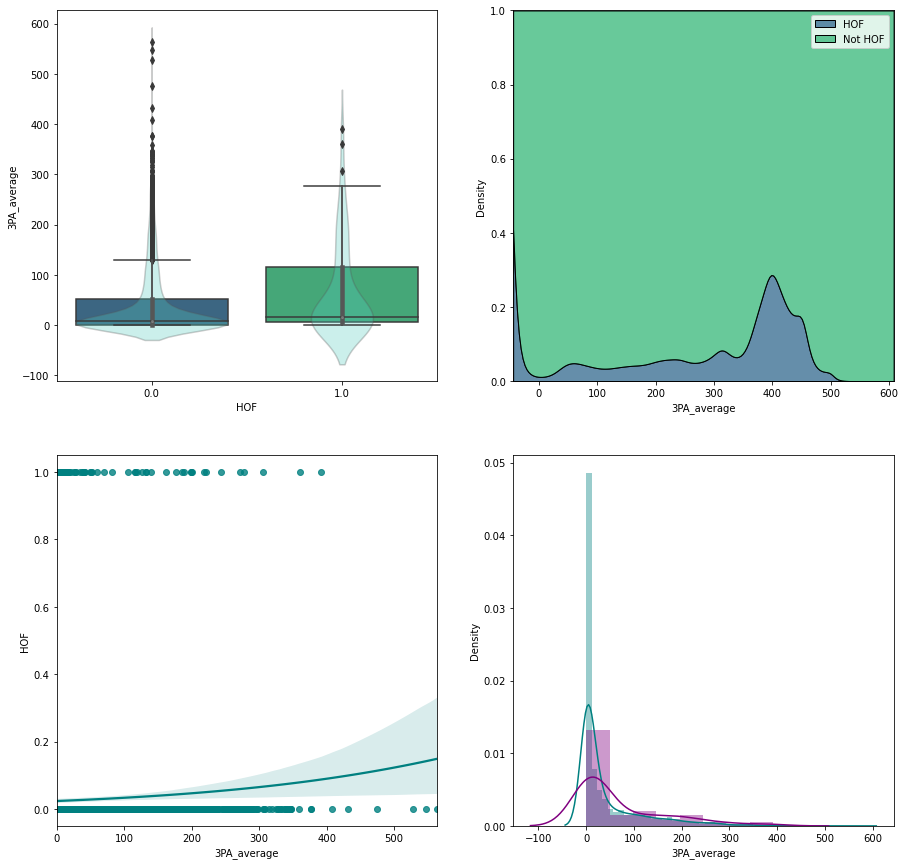

Pearson correlation of 3P% to target HOF: -0.007645118390695112

*** Results for 3P% ***
      count      mean       std  min       25%      50%       75%    max
HOF                                                                     
0.0  2402.0  0.221315  0.158313  0.0  0.095298  0.24285  0.328741  1.000
1.0    81.0  0.214538  0.132467  0.0  0.118200  0.22200  0.299846  0.693
t-statistic: nan, p-value: nan
None


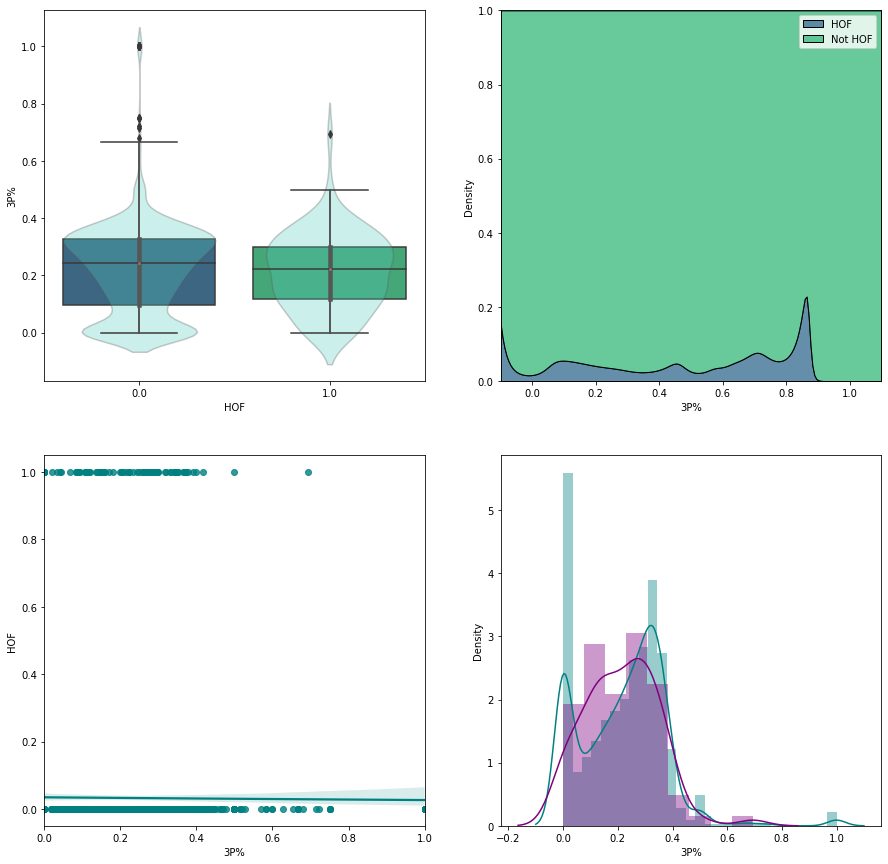

Pearson correlation of 2P_average to target HOF: 0.47353104450798944

*** Results for 2P_average ***
      count        mean         std   min         25%         50%         75%  \
HOF                                                                             
0.0  3794.0  104.438435  107.484883   0.0   19.500000   70.083333  156.134921   
1.0   154.0  410.083856  161.907186  13.0  299.940909  417.833333  522.722756   

            max  
HOF              
0.0  661.666667  
1.0  845.400000  
t-statistic: 23.2, p-value: 7.02e-53
None


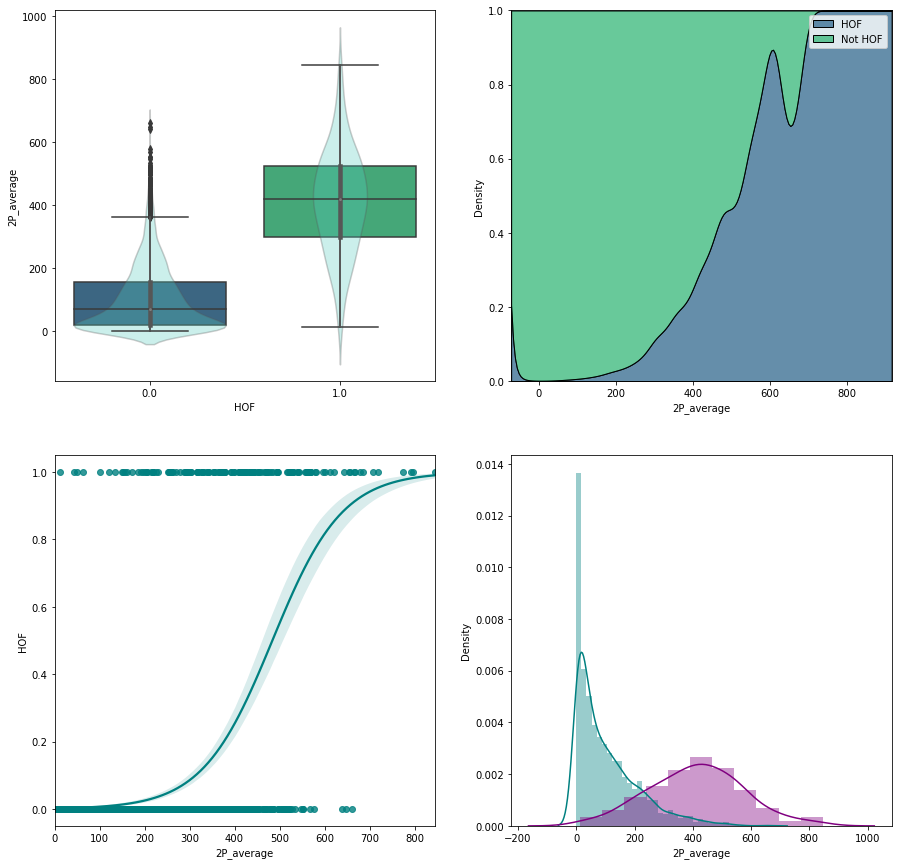

Pearson correlation of 2PA_average to target HOF: 0.4751686197078645

*** Results for 2PA_average ***
      count        mean         std   min         25%         50%         75%  \
HOF                                                                             
0.0  3794.0  231.398743  227.874160   0.0   47.000000  159.500000   350.00000   
1.0   154.0  878.985634  321.938928  35.0  646.808036  899.634615  1063.64881   

             max  
HOF               
0.0  1453.166667  
1.0  1594.200000  
t-statistic: 24.7, p-value: 2.24e-56
None


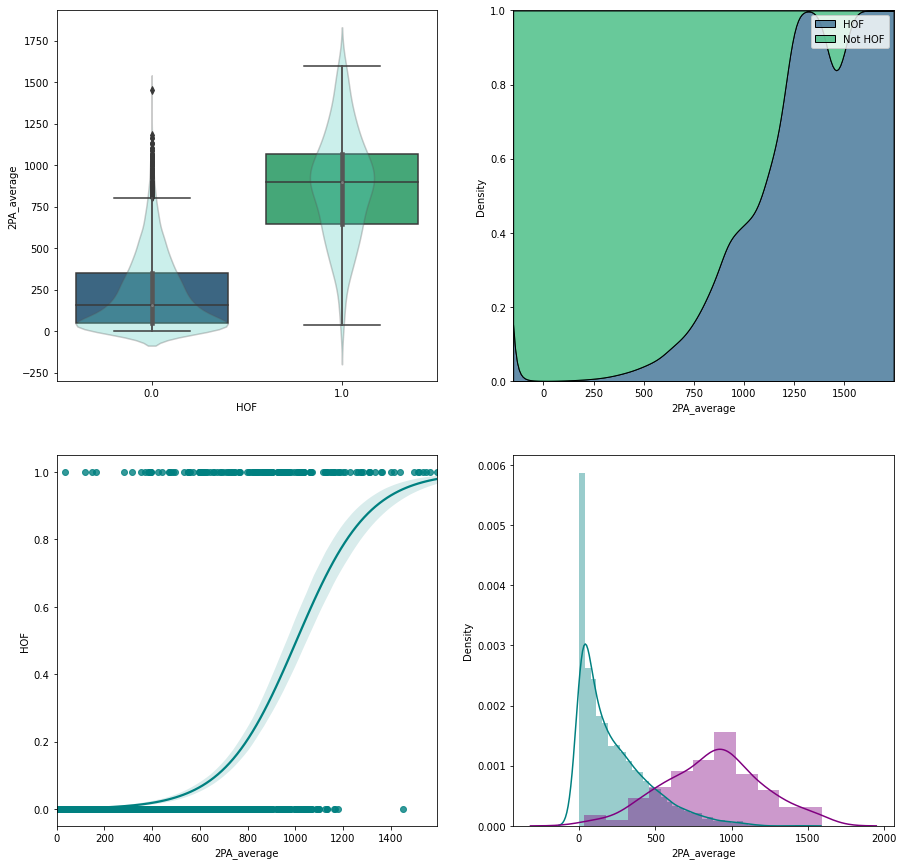

Pearson correlation of 2P% to target HOF: 0.07254091231048514

*** Results for 2P% ***
      count      mean       std    min       25%       50%       75%       max
HOF                                                                           
0.0  3776.0  0.417266  0.111096  0.000  0.368500  0.434000  0.474670  1.000000
1.0   154.0  0.458314  0.059250  0.284  0.423768  0.467607  0.503819  0.597308
t-statistic: nan, p-value: nan
None


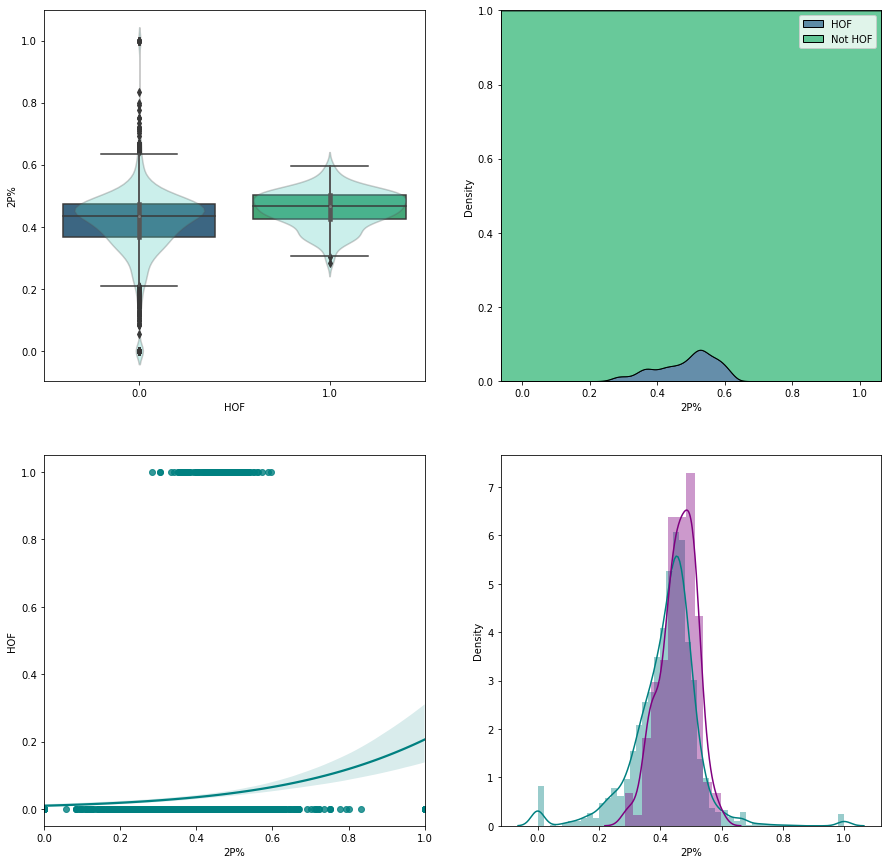

Pearson correlation of eFG% to target HOF: 0.0703842262520768

*** Results for eFG% ***
      count      mean       std    min       25%       50%       75%       max
HOF                                                                           
0.0  3780.0  0.419537  0.110706  0.000  0.370000  0.437261  0.480369  1.500000
1.0   154.0  0.459243  0.059609  0.284  0.424518  0.467171  0.504702  0.596615
t-statistic: nan, p-value: nan
None


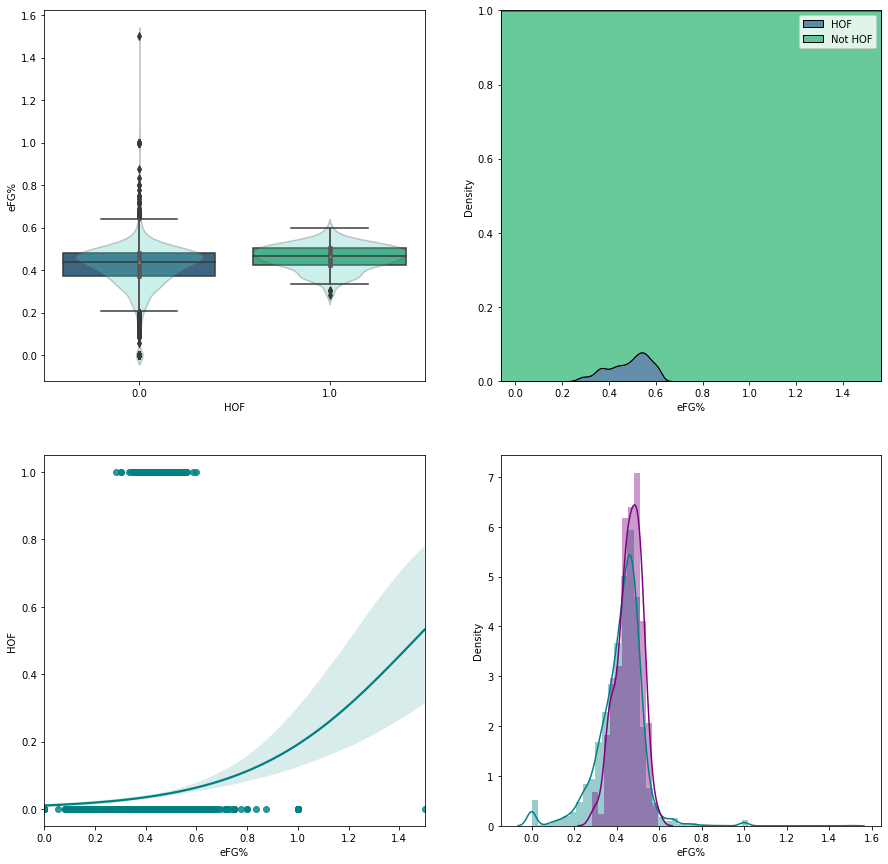

Pearson correlation of FT_average to target HOF: 0.505252359869385

*** Results for FT_average ***
      count        mean         std   min    25%         50%         75%  \
HOF                                                                        
0.0  3794.0   58.925680   64.772984   0.0   10.0   36.500000   88.212121   
1.0   154.0  261.705185  109.635701  13.0  180.6  254.512019  333.540179   

        max  
HOF          
0.0  528.25  
1.0  562.00  
t-statistic: 22.8, p-value: 1.02e-51
None


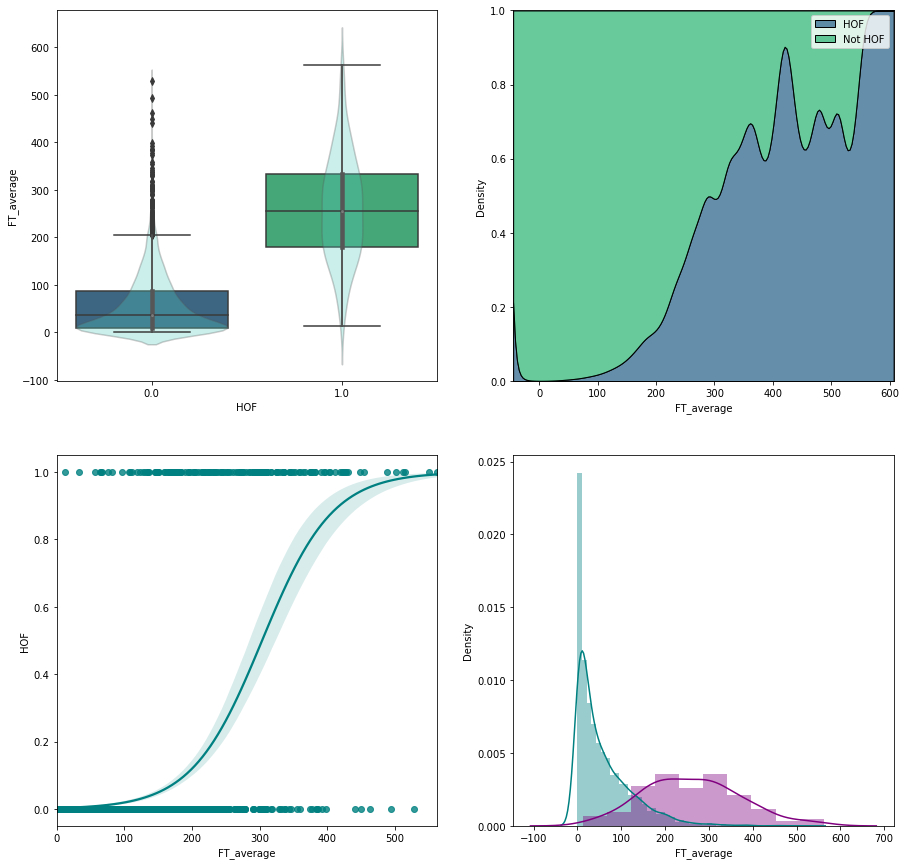

Pearson correlation of FTA_average to target HOF: 0.5053870797348392

*** Results for FTA_average ***
      count        mean         std   min         25%         50%         75%  \
HOF                                                                             
0.0  3794.0   80.416475   84.276934   0.0   16.000000   52.343137  121.187500   
1.0   154.0  343.776607  139.628716  23.0  241.571429  330.955556  440.269231   

       max  
HOF         
0.0  635.0  
1.0  790.8  
t-statistic: 23.2, p-value: 9.15e-53
None


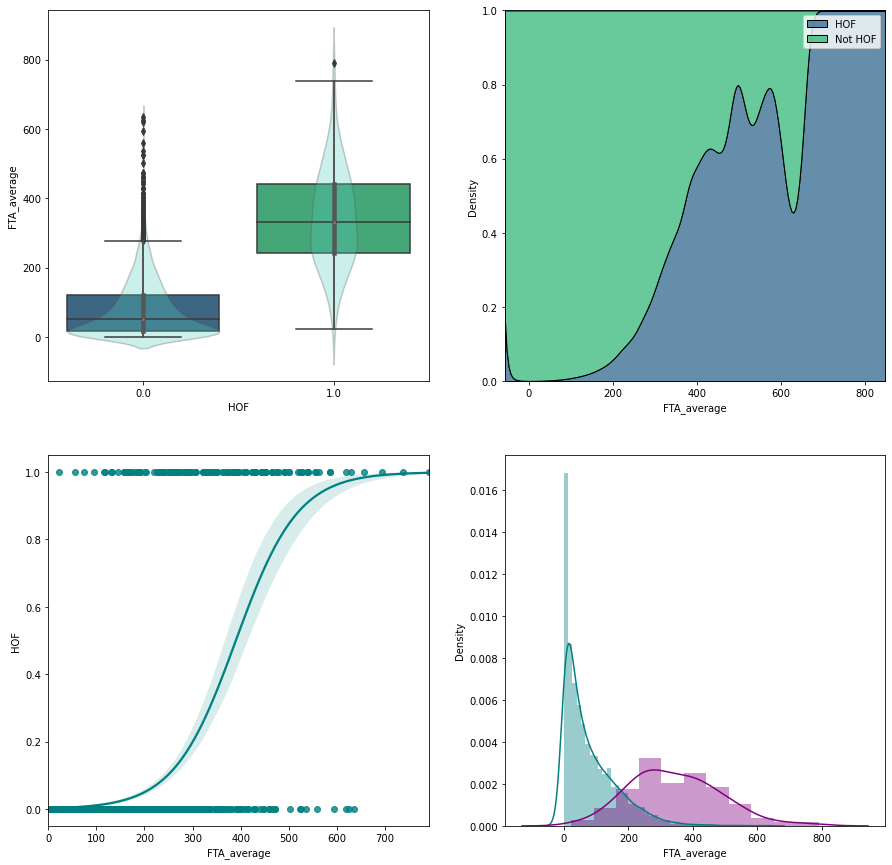

Pearson correlation of FT% to target HOF: 0.08413761729578198

*** Results for FT% ***
      count      mean       std       min       25%       50%       75%  \
HOF                                                                       
0.0  3643.0  0.690239  0.145619  0.000000  0.623000  0.712667  0.780500   
1.0   154.0  0.751679  0.080970  0.399706  0.717929  0.763696  0.801444   

        max  
HOF          
0.0  1.0000  
1.0  0.9096  
t-statistic: nan, p-value: nan
None


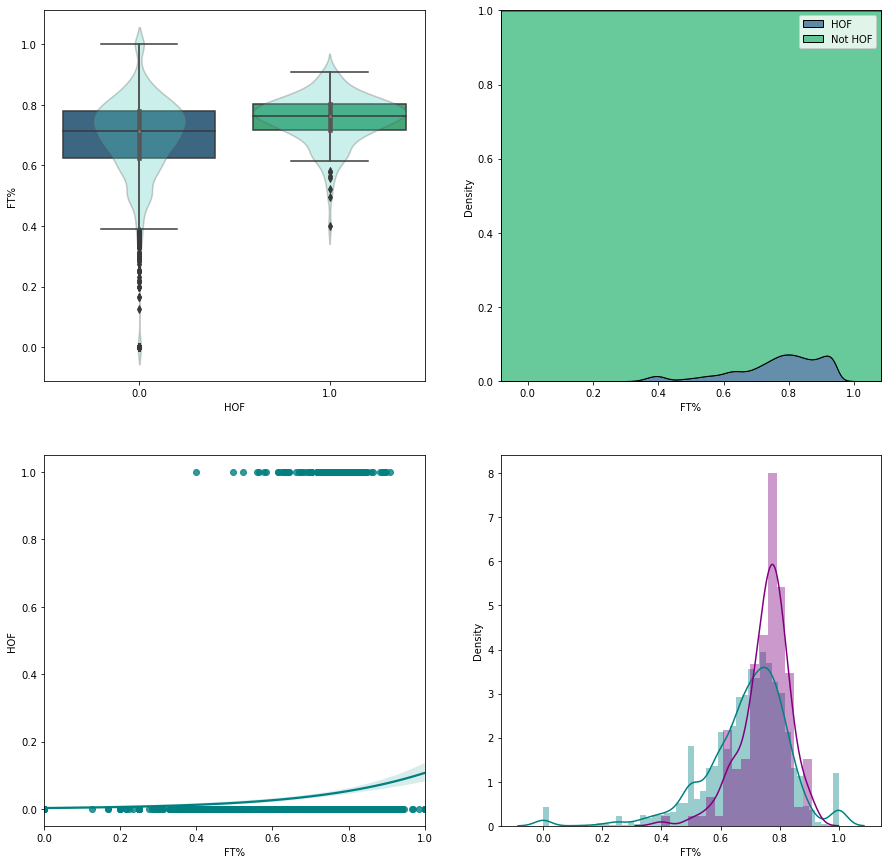

Pearson correlation of ORB_average to target HOF: 0.2922466781418919

*** Results for ORB_average ***
      count        mean        std   min        25%    50%         75%     max
HOF                                                                           
0.0  3064.0   41.064274  44.372336   0.0   8.276786   25.1   60.175000  357.20
1.0   103.0  119.017863  66.699049  10.0  64.430921  117.4  158.003676  336.55
t-statistic: nan, p-value: nan
None


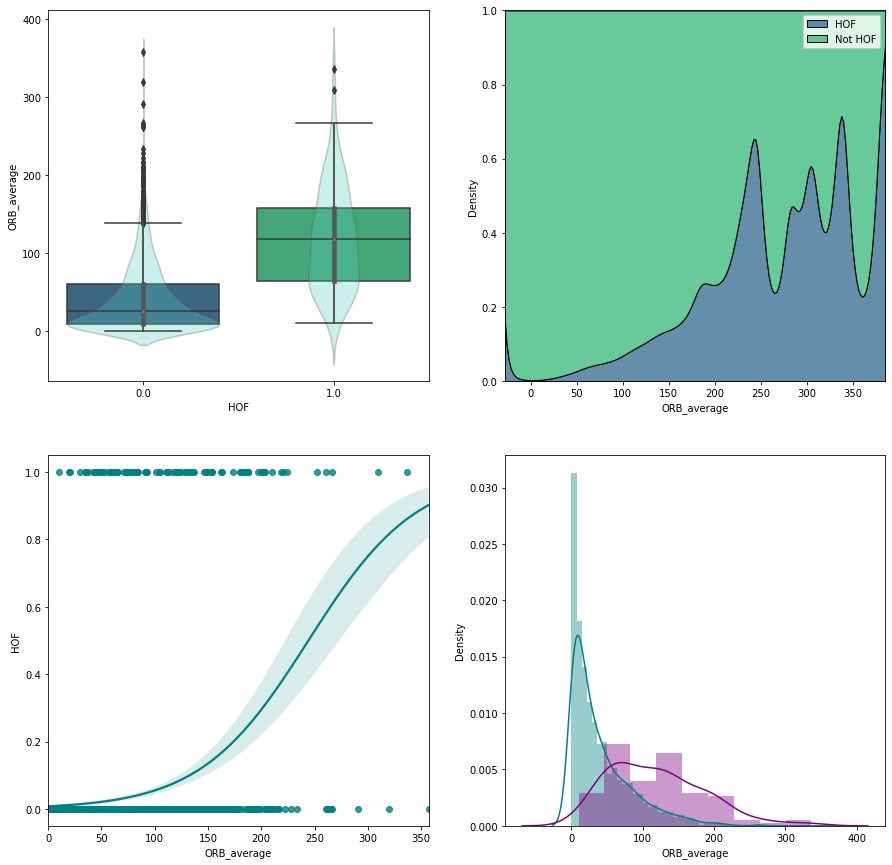

Pearson correlation of DRB_average to target HOF: 0.35123263520528775

*** Results for DRB_average ***
      count        mean         std   min         25%    50%         75%  \
HOF                                                                        
0.0  3064.0   94.307578   96.902176   0.0   19.000000   64.0  141.000000   
1.0   103.0  304.350963  155.908536  24.0  191.341912  277.8  406.020833   

        max  
HOF          
0.0  673.50  
1.0  640.25  
t-statistic: nan, p-value: nan
None


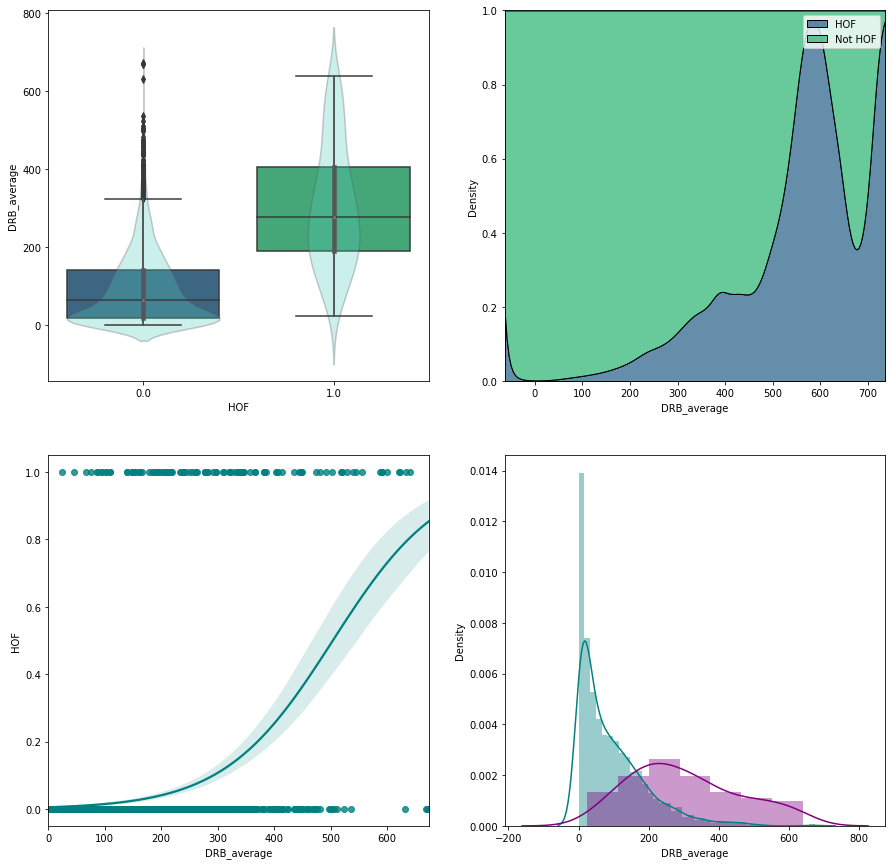

Pearson correlation of TRB_average to target HOF: 0.4203253910879831

*** Results for TRB_average ***
      count        mean         std   min         25%         50%         75%  \
HOF                                                                             
0.0  3694.0  136.776321  141.049538   0.0   28.000000   92.078947  200.901786   
1.0   153.0  489.394625  276.927549  34.0  282.714286  446.000000  650.473684   

             max  
HOF               
0.0   989.200000  
1.0  1663.076923  
t-statistic: nan, p-value: nan
None


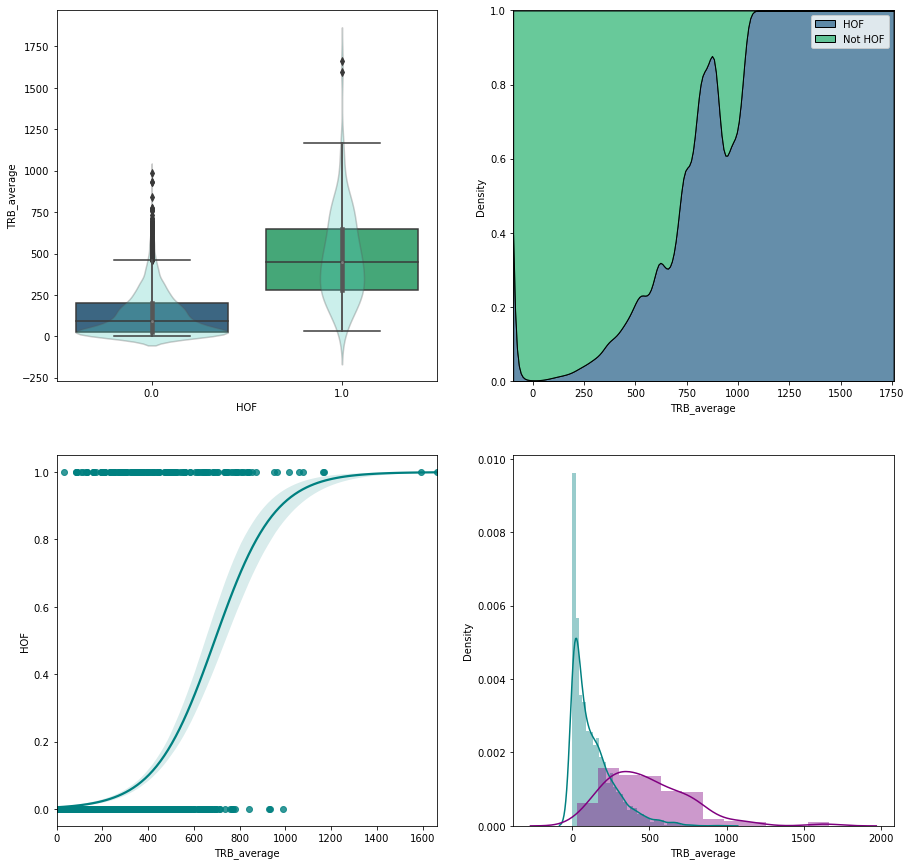

Pearson correlation of AST_average to target HOF: 0.3486863572488893

*** Results for AST_average ***
      count        mean         std  min         25%         50%       75%  \
HOF                                                                          
0.0  3794.0   68.661070   84.974653  0.0   10.000000   38.045455   94.1250   
1.0   154.0  237.736827  144.114365  6.0  136.831731  207.655882  297.9375   

            max  
HOF              
0.0  687.583333  
1.0  831.894737  
t-statistic: 14.5, p-value: 1.11e-30
None


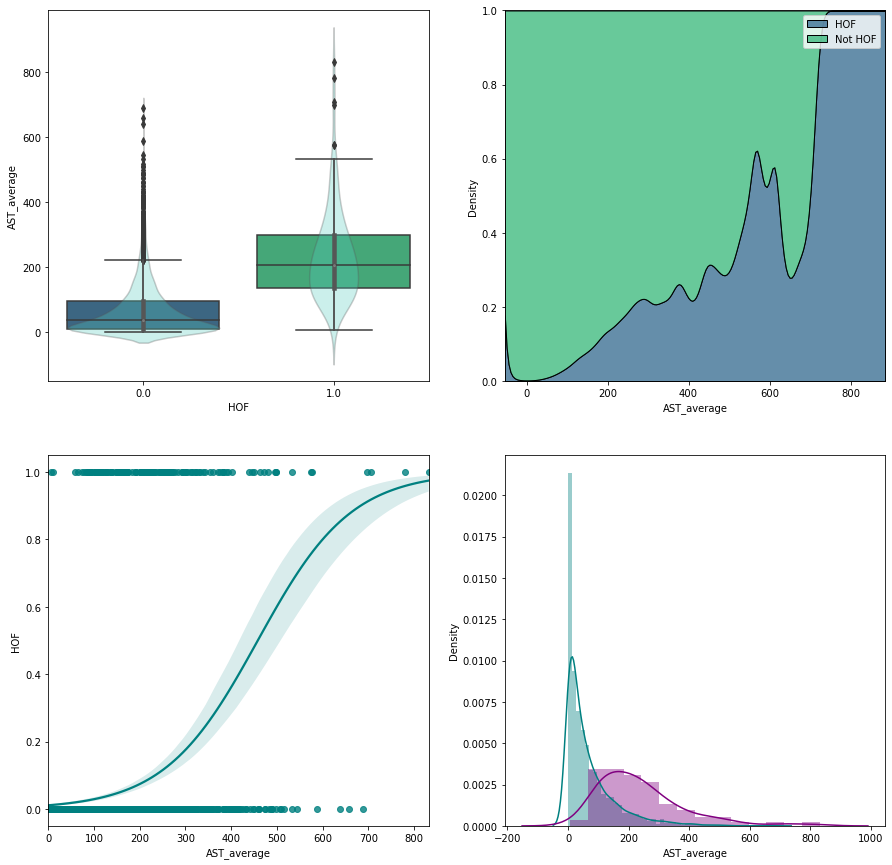

Pearson correlation of STL_average to target HOF: 0.319931368197405

*** Results for STL_average ***
      count       mean        std  min        25%        50%      75%  \
HOF                                                                     
0.0  3064.0  26.421772  26.341561  0.0   5.500000  18.839744  39.5250   
1.0   103.0  77.201366  35.437937  3.0  54.198684  73.444444  96.1125   

            max  
HOF              
0.0  192.000000  
1.0  171.842105  
t-statistic: nan, p-value: nan
None


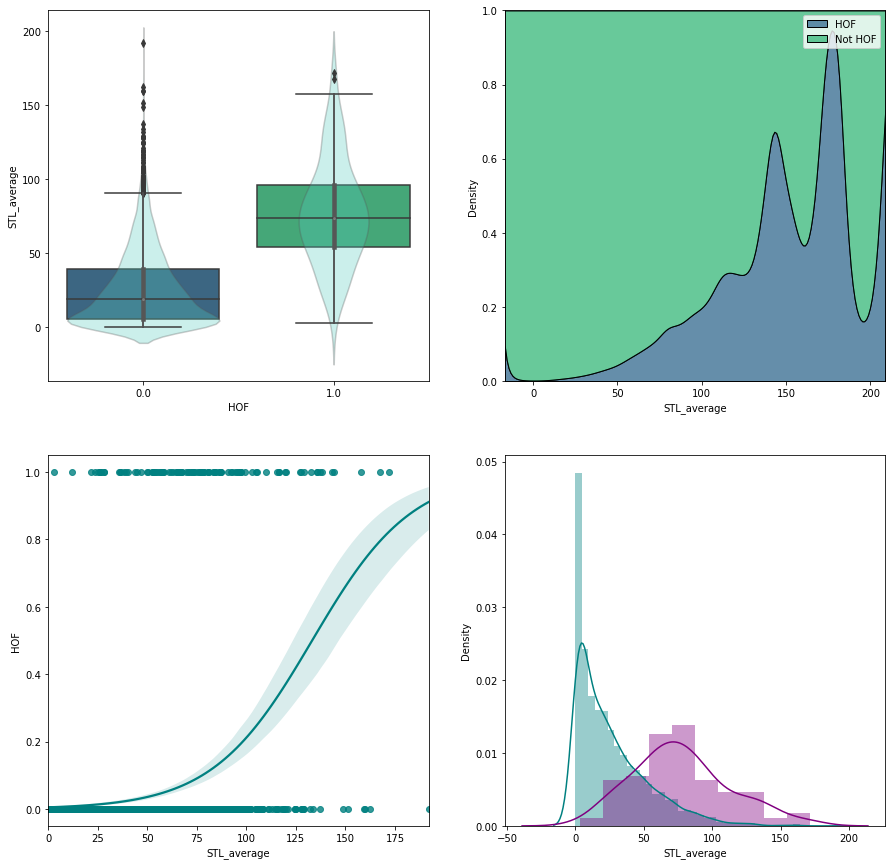

Pearson correlation of BLK_average to target HOF: 0.2871162586812915

*** Results for BLK_average ***
      count       mean        std   min        25%        50%        75%  \
HOF                                                                        
0.0  3064.0  15.170357  22.104798  0.00   2.000000   7.000000  18.895833   
1.0   103.0  55.044083  51.147457  3.25  16.948413  37.928571  71.689904   

            max  
HOF              
0.0  278.545455  
1.0  212.777778  
t-statistic: nan, p-value: nan
None


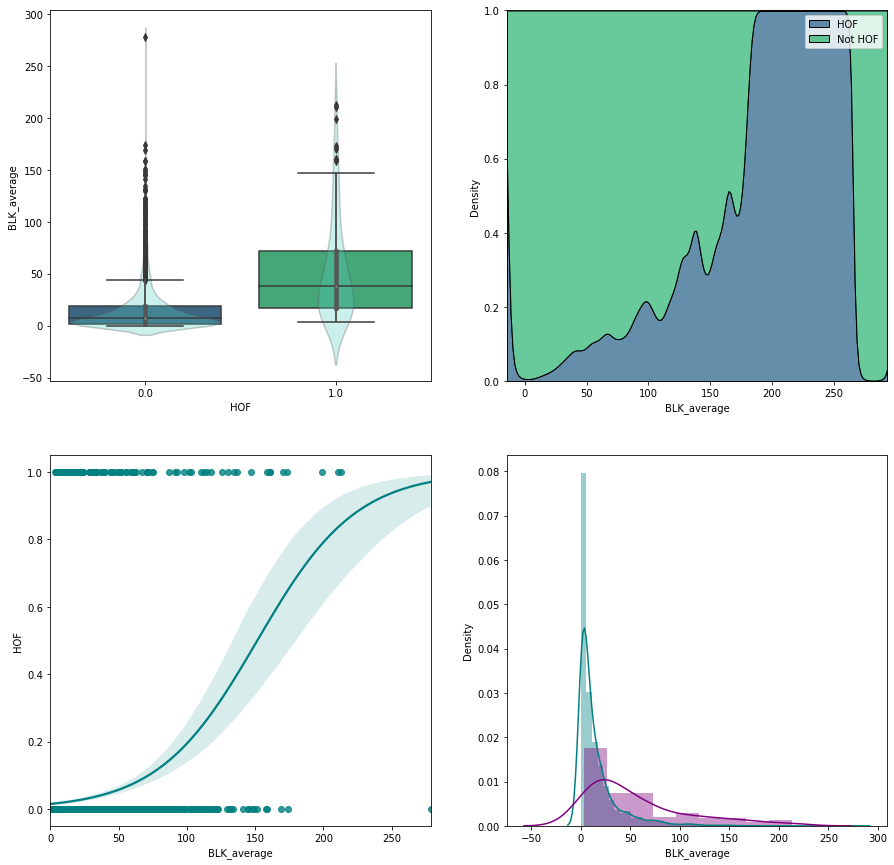

Pearson correlation of TOV_average to target HOF: 0.3829466454490093

*** Results for TOV_average ***
      count        mean        std        min         25%       50%  \
HOF                                                                   
0.0  2879.0   48.907585  45.902082   0.000000   11.055556   36.0000   
1.0    86.0  162.214389  45.313795  44.666667  135.827206  160.0625   

            75%         max  
HOF                          
0.0   73.750000  291.111111  
1.0  193.805556  283.230769  
t-statistic: nan, p-value: nan
None


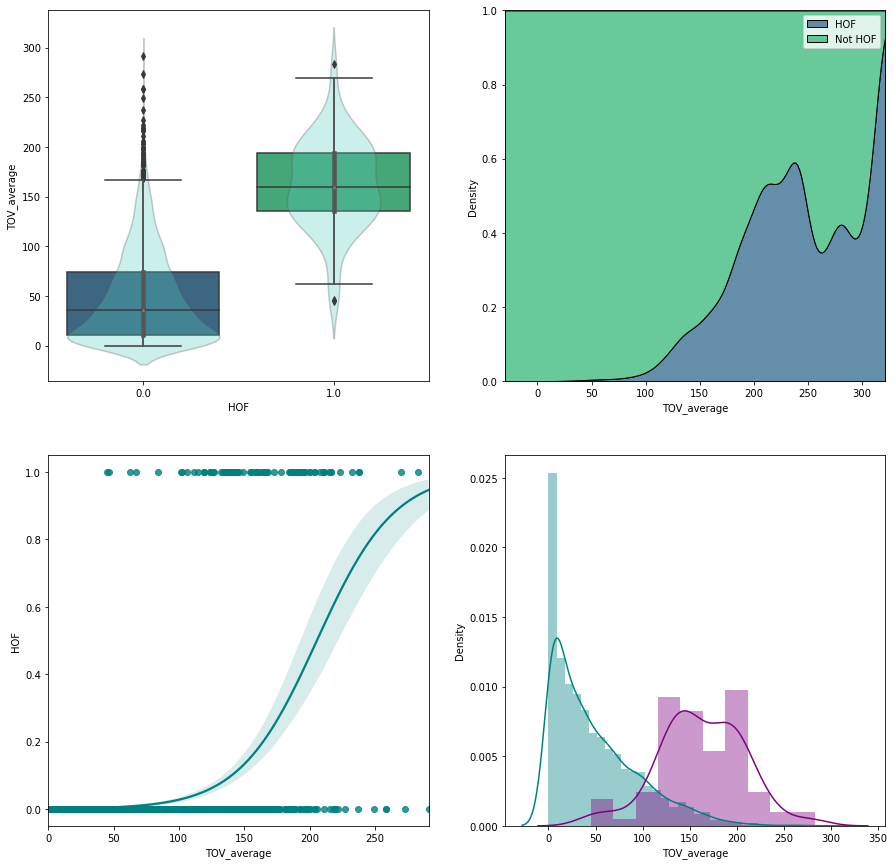

Pearson correlation of PF_average to target HOF: 0.32637940198134613

*** Results for PF_average ***
      count        mean        std   min         25%         50%         75%  \
HOF                                                                            
0.0  3794.0   79.692412  62.893228   0.0   22.000000   69.619048  127.212121   
1.0   154.0  190.920434  48.073245  29.0  160.483456  197.476190  227.725000   

            max  
HOF              
0.0  320.333333  
1.0  291.500000  
t-statistic: 27.8, p-value: 5.15e-66
None


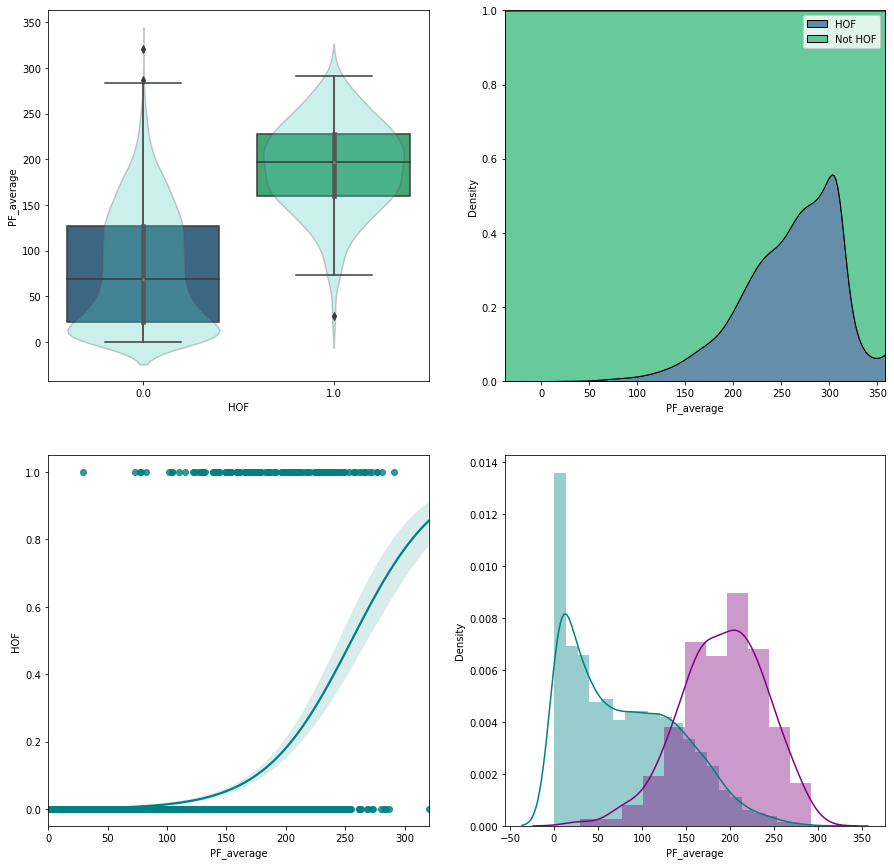

Pearson correlation of PTS_average to target HOF: 0.45550114881412096

*** Results for PTS_average ***
      count         mean         std   min         25%         50%  \
HOF                                                                  
0.0  3794.0   299.963200  303.898146   0.0   57.000000   202.00000   
1.0   154.0  1116.849685  419.469947  39.0  832.133117  1143.59375   

             75%          max  
HOF                            
0.0   455.855263  2056.214286  
1.0  1393.223684  2152.800000  
t-statistic: 23.9, p-value: 1.24e-54
None


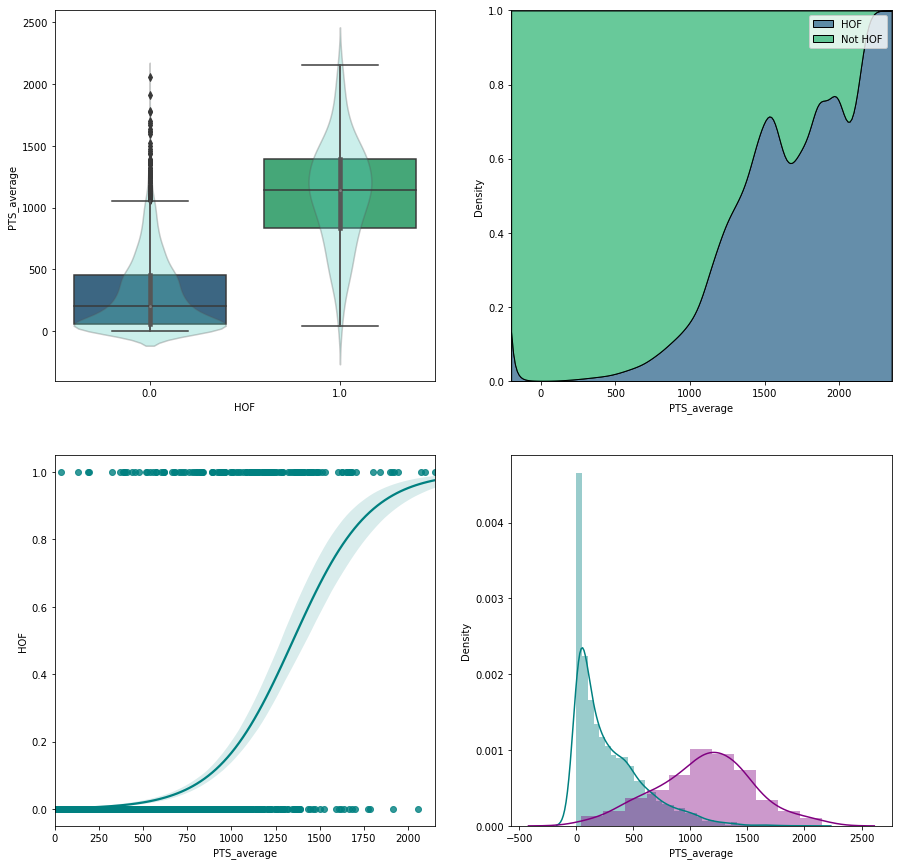

Pearson correlation of WOR_Year_average to target HOF: 0.3317343626814356

*** Results for WOR_Year_average ***
      count      mean       std   min    25%       50%       75%        max
HOF                                                                        
0.0  3794.0  0.386101  1.775510 -3.42 -0.405  0.000000  0.352558  22.371429
1.0   154.0  3.937640  4.529314 -1.26  0.000  1.954038  6.953019  18.810000
t-statistic: 9.7, p-value: 1.11e-17
None


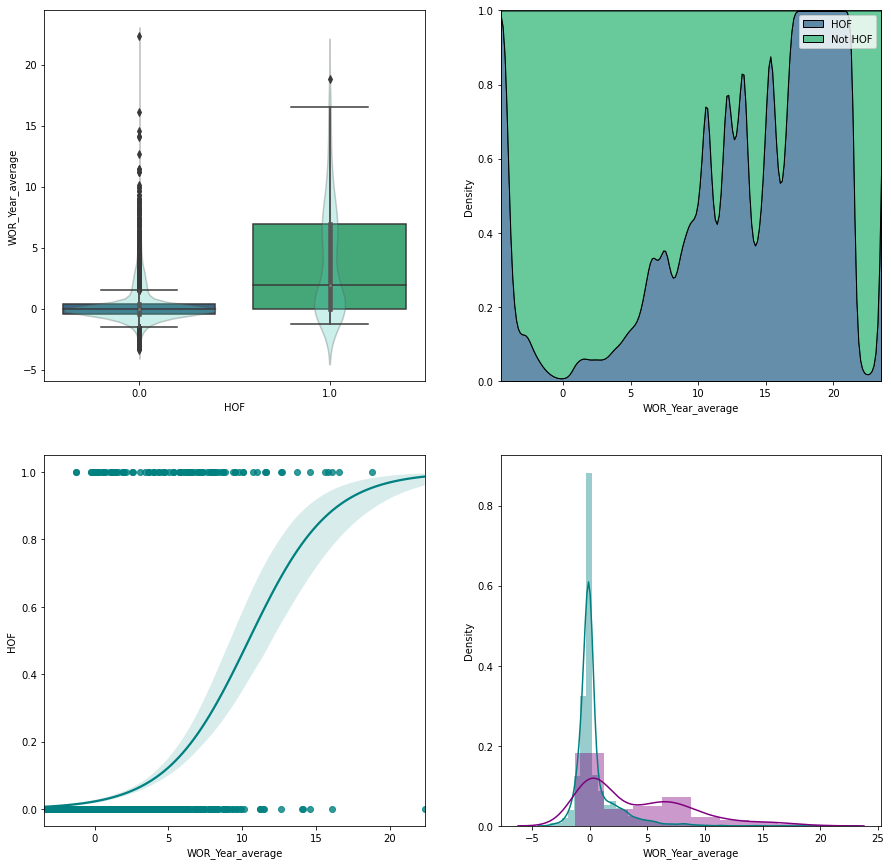

Pearson correlation of years_in_league to target HOF: 0.26434793576997834

*** Results for years_in_league ***
      count       mean       std  min   25%   50%   75%   max
HOF                                                          
0.0  3794.0   5.514233  4.785891  1.0  2.00   4.0   9.0  30.0
1.0   154.0  12.272727  4.500215  1.0  9.25  13.0  16.0  22.0
t-statistic: 18.2, p-value: 1.39e-41
None


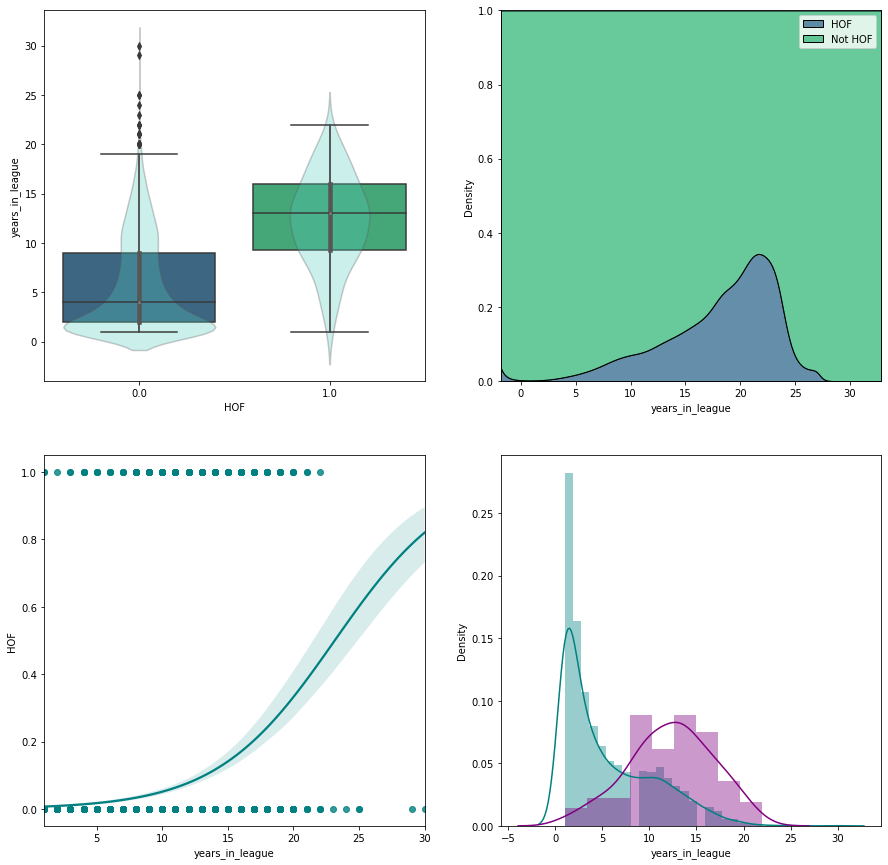

Pearson correlation of ppg to target HOF: 0.4404764573677337

*** Results for ppg ***
      count       mean       std       min        25%        50%        75%  \
HOF                                                                           
0.0  3794.0   5.626406  4.052559  0.000000   2.637379   4.569225   7.652516   
1.0   154.0  16.057943  5.486298  3.396875  12.455661  16.568545  19.314736   

           max  
HOF             
0.0  27.121076  
1.0  30.375528  
t-statistic: 23.3, p-value: 2.33e-53
None


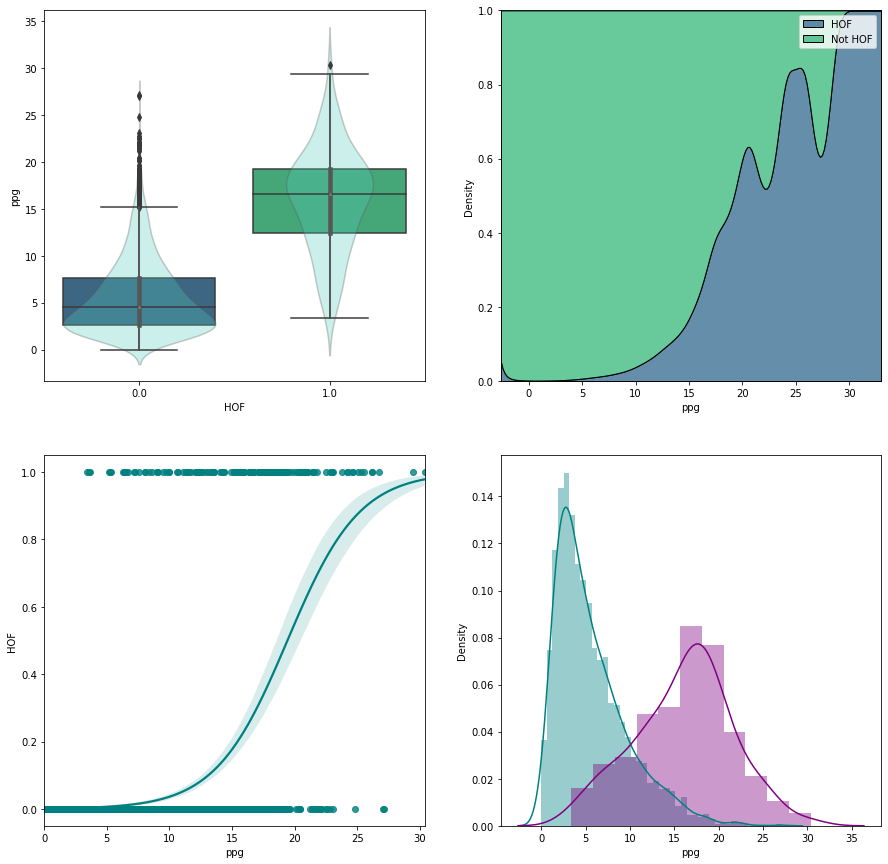

Pearson correlation of championship_average to target HOF: 0.1531763935682394

*** Results for championship_average ***
      count      mean       std  min  25%       50%       75%  max
HOF                                                               
0.0  3794.0  0.031595  0.117719  0.0  0.0  0.000000  0.000000  1.0
1.0   154.0  0.129310  0.202103  0.0  0.0  0.069048  0.151099  1.0
t-statistic: 6.0, p-value: 1.61e-08
None


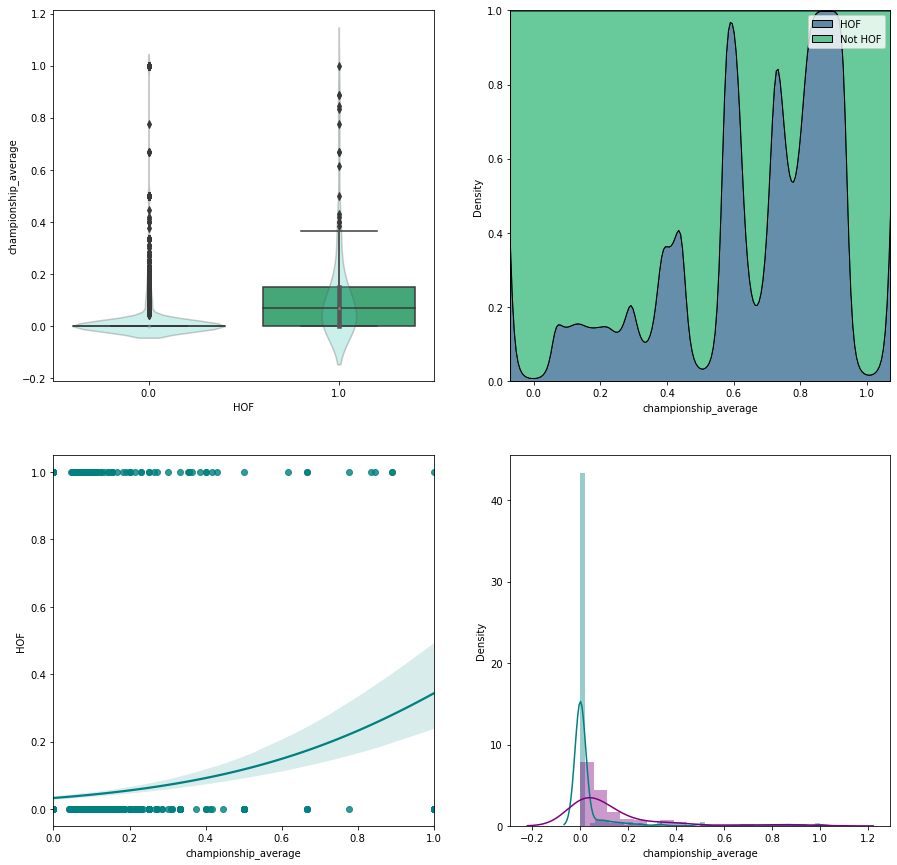

Pearson correlation of G_total to target HOF: 0.3370836562427302

*** Results for G_total ***
      count        mean         std   min     25%    50%      75%     max
HOF                                                                      
0.0  3794.0  271.934634  300.282903   1.0   36.00  136.5   457.75  1874.0
1.0   154.0  829.376623  330.654196  11.0  624.75  847.0  1038.00  1611.0
t-statistic: 20.6, p-value: 3.12e-47
None


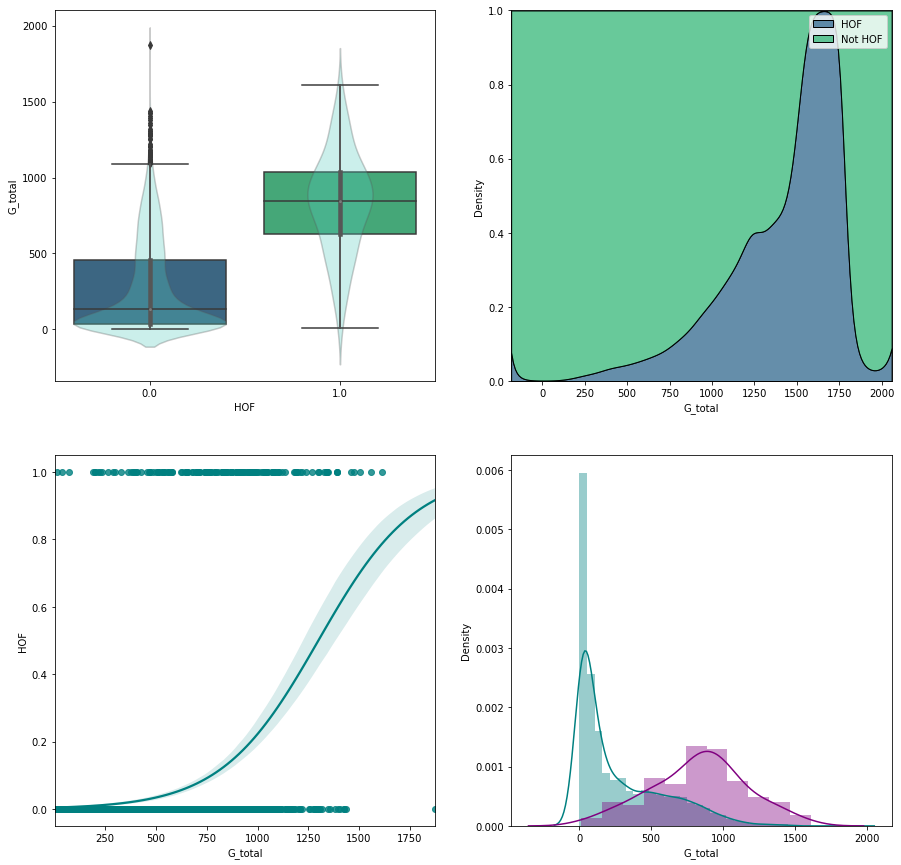

Pearson correlation of GS_total to target HOF: 0.22380720626725167

*** Results for GS_total ***
      count        mean         std  min  25%  50%     75%     max
HOF                                                               
0.0  3794.0   94.945967  189.947372  0.0  0.0  1.0   84.00  1363.0
1.0   154.0  340.746753  462.416013  0.0  0.0  0.0  738.25  1471.0
t-statistic: 6.6, p-value: 7.06e-10
None


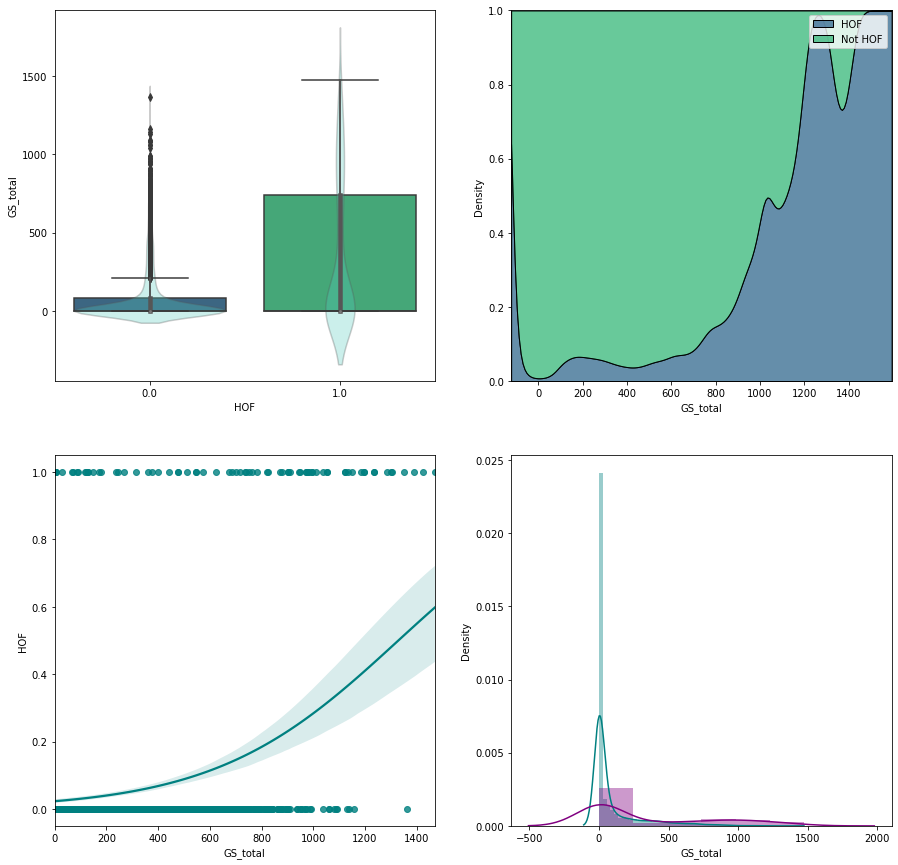

Pearson correlation of MP_total to target HOF: 0.4220934702012692

*** Results for MP_total ***
      count          mean           std  min      25%      50%       75%  \
HOF                                                                        
0.0  3794.0   6146.802847   8460.094888  0.0    227.5   1874.0   9566.75   
1.0   154.0  27026.500000  13070.911679  0.0  17643.5  28832.0  35868.75   

         max  
HOF           
0.0  52579.0  
1.0  57446.0  
t-statistic: 19.7, p-value: 2.53e-44
None


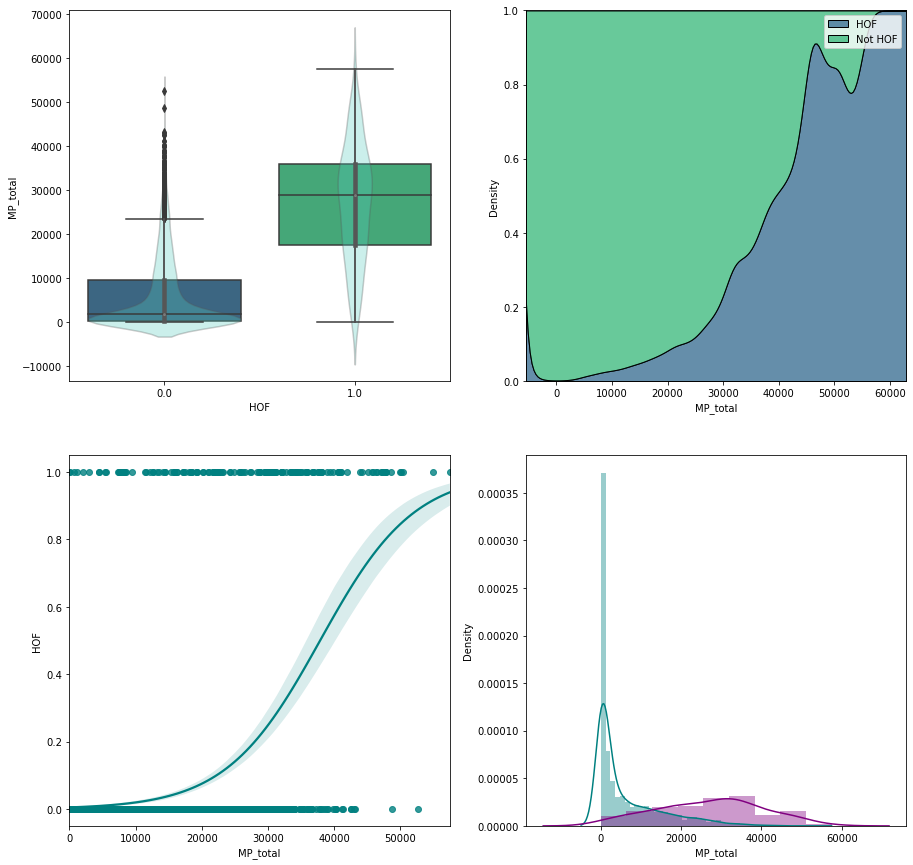

Pearson correlation of OWS_total to target HOF: 0.526697586406043

*** Results for OWS_total ***
      count       mean        std   min     25%   50%    75%    max
HOF                                                                
0.0  3794.0   5.824565  12.551620 -20.4  -0.200   0.3   6.10  143.8
1.0   154.0  52.120779  38.659627 -11.1  23.025  47.8  70.05  179.0
t-statistic: 14.8, p-value: 1.72e-31
None


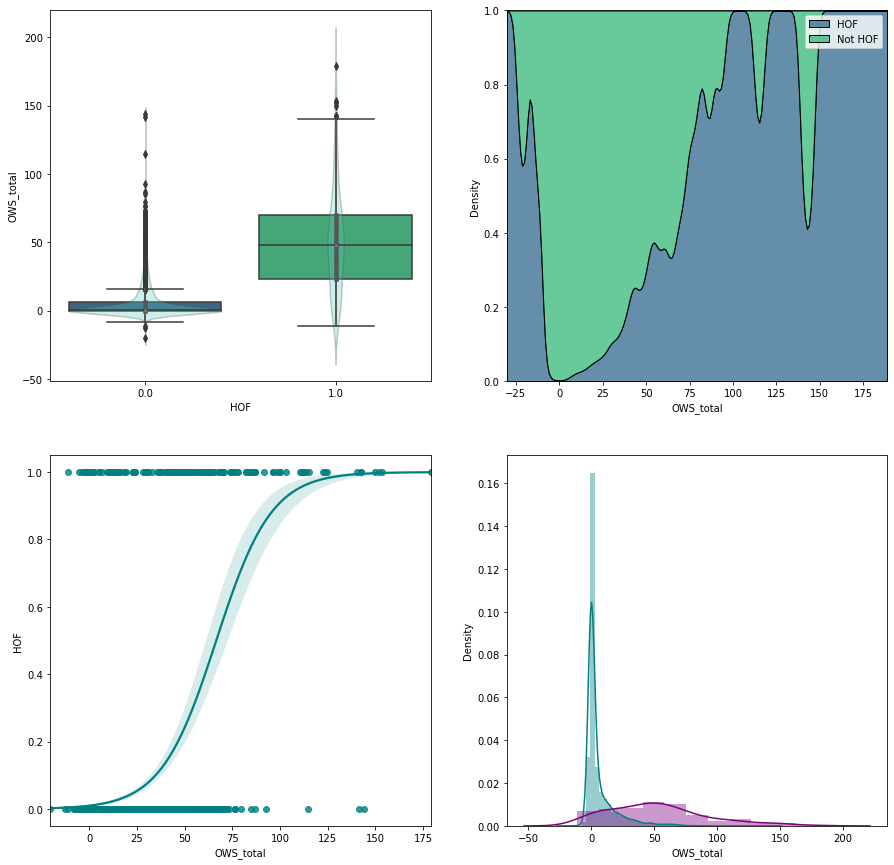

Pearson correlation of DWS_total to target HOF: 0.4904400691703006

*** Results for DWS_total ***
      count       mean        std  min     25%   50%     75%    max
HOF                                                                
0.0  3794.0   6.120559   9.283837 -0.9   0.200   1.7   8.700   65.6
1.0   154.0  35.877273  23.824383  0.2  19.825  31.6  47.125  133.6
t-statistic: 15.5, p-value: 3.47e-33
None


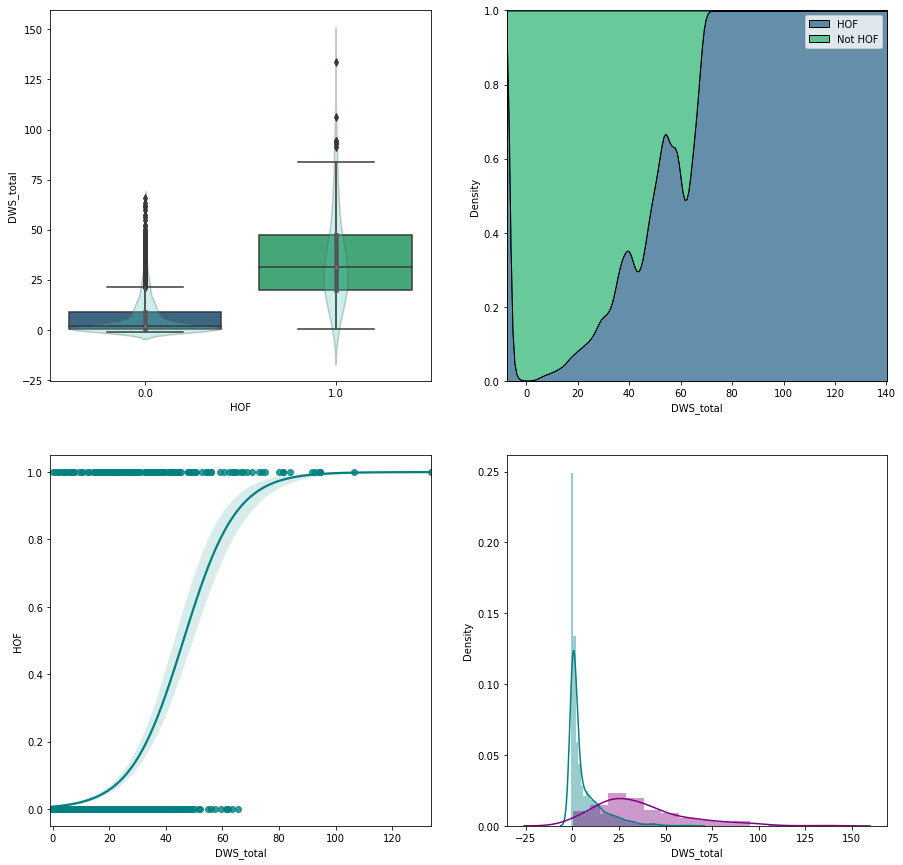

Pearson correlation of WS_total to target HOF: 0.5413556199332346

*** Results for WS_total ***
      count       mean        std  min     25%    50%      75%    max
HOF                                                                  
0.0  3794.0  11.950738  20.595404 -7.9   0.000   2.00   15.400  205.6
1.0   154.0  87.989610  54.544914 -0.7  49.225  83.35  117.175  273.3
t-statistic: 17.2, p-value: 7.11e-38
None


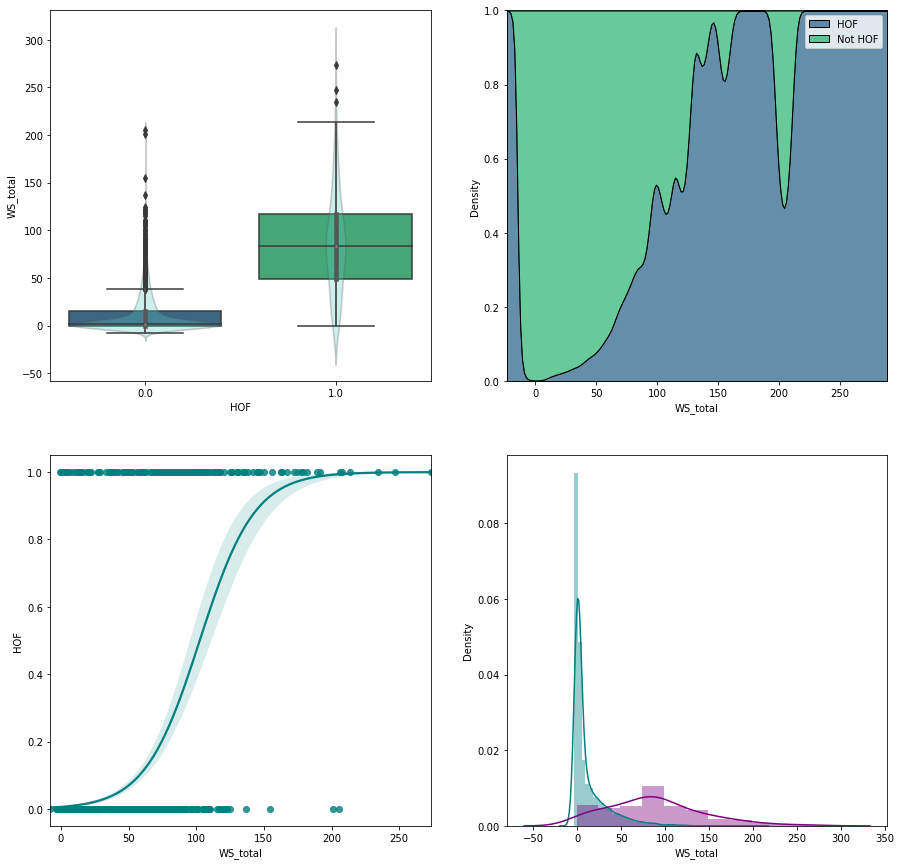

Pearson correlation of VORP_total to target HOF: 0.3956304057478851

*** Results for VORP_total ***
      count       mean        std  min  25%   50%     75%    max
HOF                                                             
0.0  3794.0   2.223221   7.155197 -8.5 -0.3  0.00   0.800  116.0
1.0   154.0  21.883766  27.305635 -3.2  0.0  6.85  38.175  104.5
t-statistic: 8.9, p-value: 1.27e-15
None


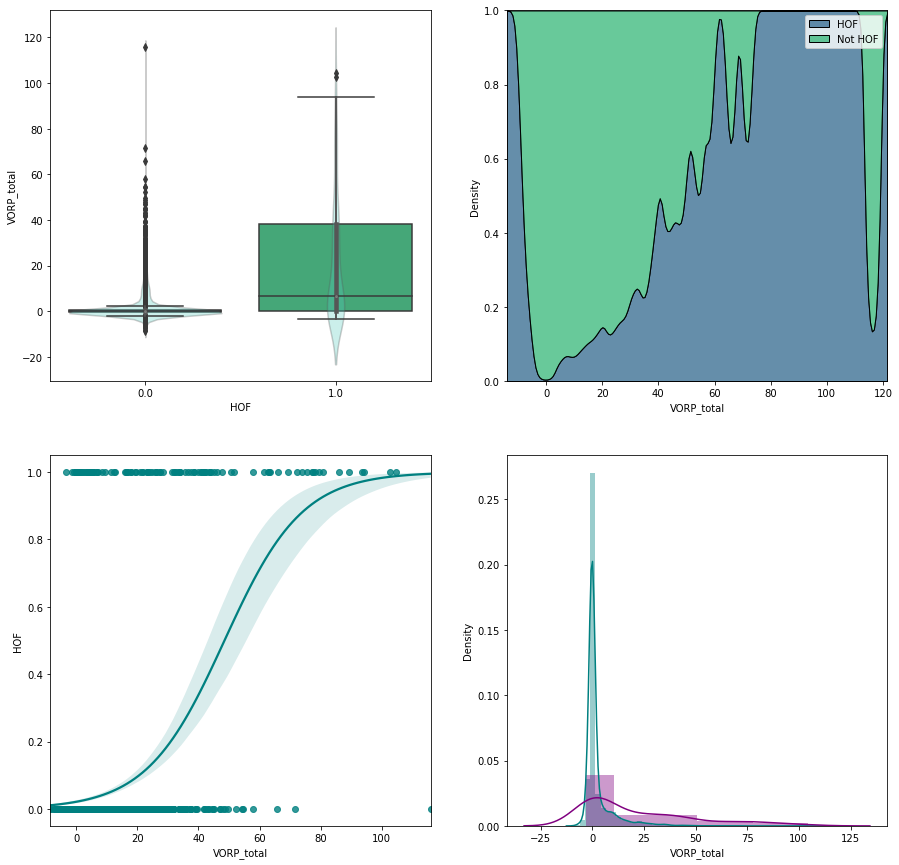

Pearson correlation of FG_total to target HOF: 0.4902192848280272

*** Results for FG_total ***
      count         mean          std   min     25%     50%     75%      max
HOF                                                                         
0.0  3794.0   976.016605  1468.600573   0.0    39.0   262.0  1336.0  11742.0
1.0   154.0  5518.298701  3101.603037  13.0  3058.0  5715.5  7361.0  15837.0
t-statistic: 18.1, p-value: 4e-40
None


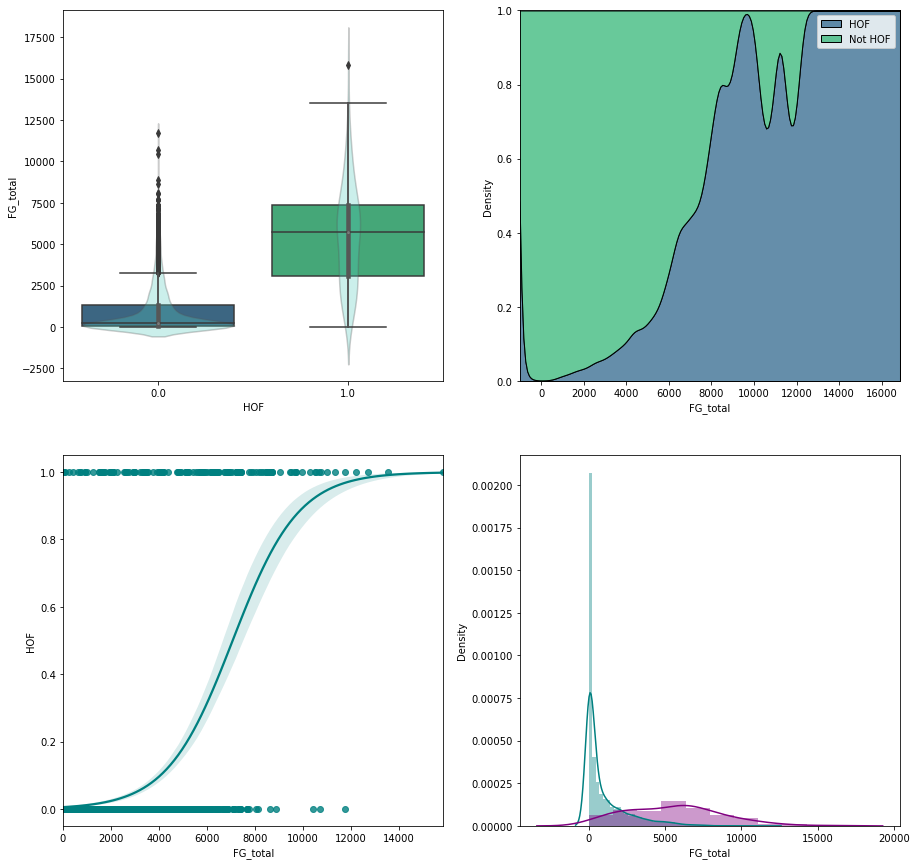

Pearson correlation of FGA_total to target HOF: 0.48662913108117156

*** Results for FGA_total ***
      count          mean          std   min      25%      50%       75%  \
HOF                                                                        
0.0  3794.0   2158.692936  3167.955953   0.0    99.00    631.5   3002.25   
1.0   154.0  11742.428571  6125.663578  35.0  6968.25  12449.0  15593.00   

         max  
HOF           
0.0  24797.0  
1.0  28307.0  
t-statistic: 19.3, p-value: 3.03e-43
None


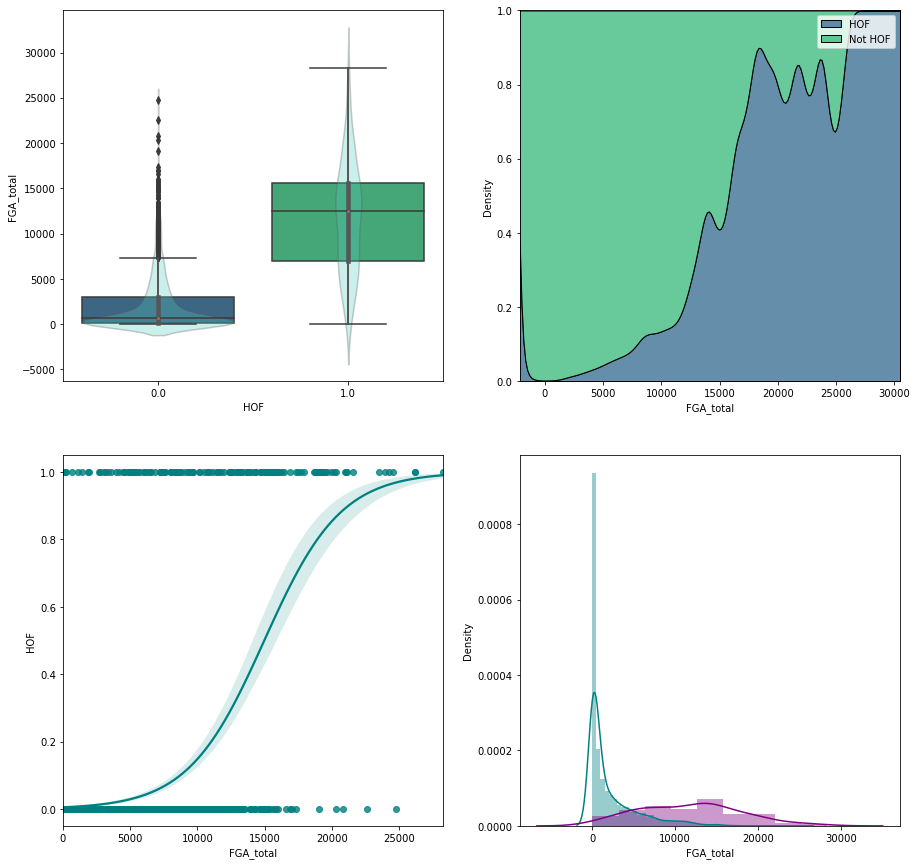

Pearson correlation of 3P_total to target HOF: 0.06882611954474228

*** Results for 3P_total ***
      count        mean         std  min  25%  50%    75%     max
HOF                                                              
0.0  3794.0   95.952557  255.331868  0.0  0.0  1.0  34.00  2242.0
1.0   154.0  191.629870  494.108929  0.0  0.0  0.0  54.25  2973.0
t-statistic: 2.4, p-value: 0.018
None


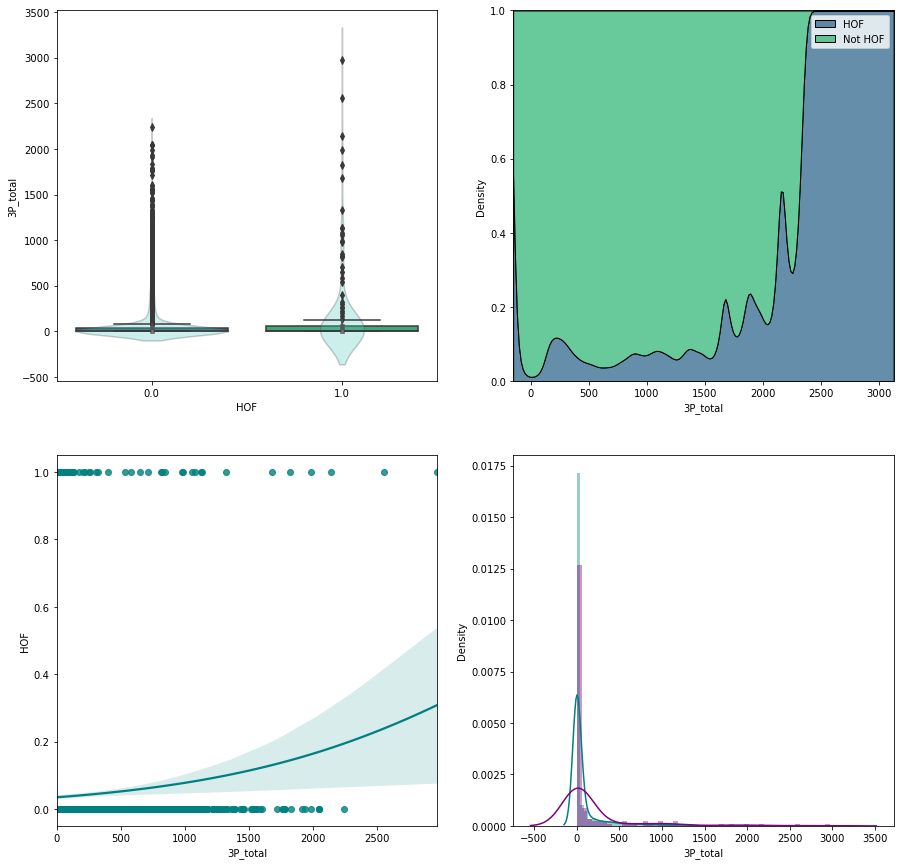

Pearson correlation of 3PA_total to target HOF: 0.07406673867863414

*** Results for 3PA_total ***
      count        mean          std  min  25%  50%    75%     max
HOF                                                               
0.0  3794.0  274.037164   695.679374  0.0  0.0  6.0  120.0  5895.0
1.0   154.0  554.616883  1344.121898  0.0  0.0  3.5  203.0  7429.0
t-statistic: 2.6, p-value: 0.0109
None


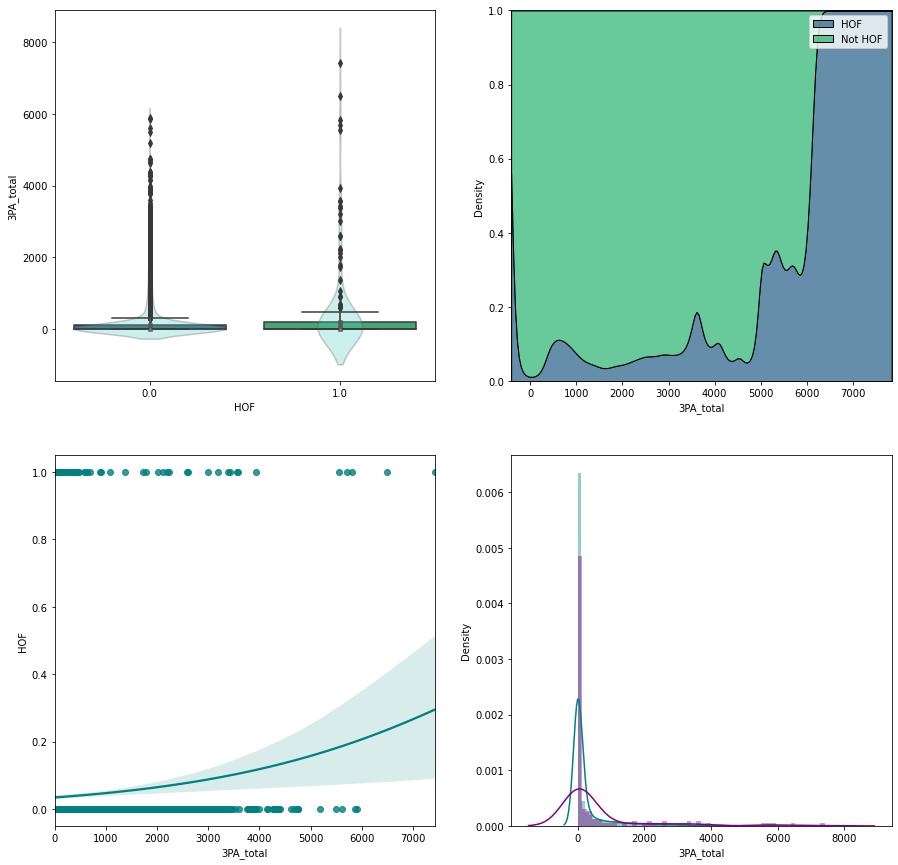

Pearson correlation of 2P_total to target HOF: 0.5128623933897775

*** Results for 2P_total ***
      count         mean          std   min     25%     50%      75%      max
HOF                                                                          
0.0  3794.0   880.064048  1341.992716   0.0    35.0   230.5  1198.25  11076.0
1.0   154.0  5326.668831  2989.919860  13.0  3058.0  5557.5  7124.75  15836.0
t-statistic: 18.4, p-value: 7.93e-41
None


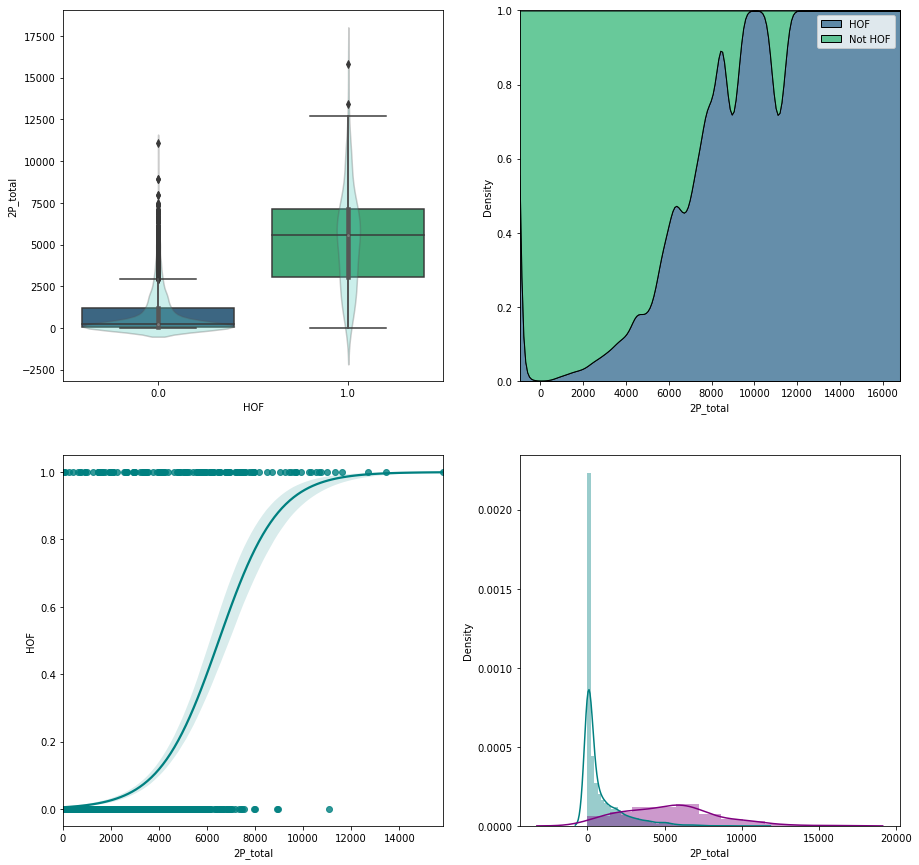

Pearson correlation of 2PA_total to target HOF: 0.5192408418787982

*** Results for 2PA_total ***
      count          mean          std   min      25%      50%       75%  \
HOF                                                                        
0.0  3794.0   1884.655772  2793.863509   0.0    89.00    530.0   2584.75   
1.0   154.0  11187.811688  5769.065985  35.0  6968.25  11448.0  14852.00   

         max  
HOF           
0.0  22799.0  
1.0  28289.0  
t-statistic: 19.9, p-value: 1.08e-44
None


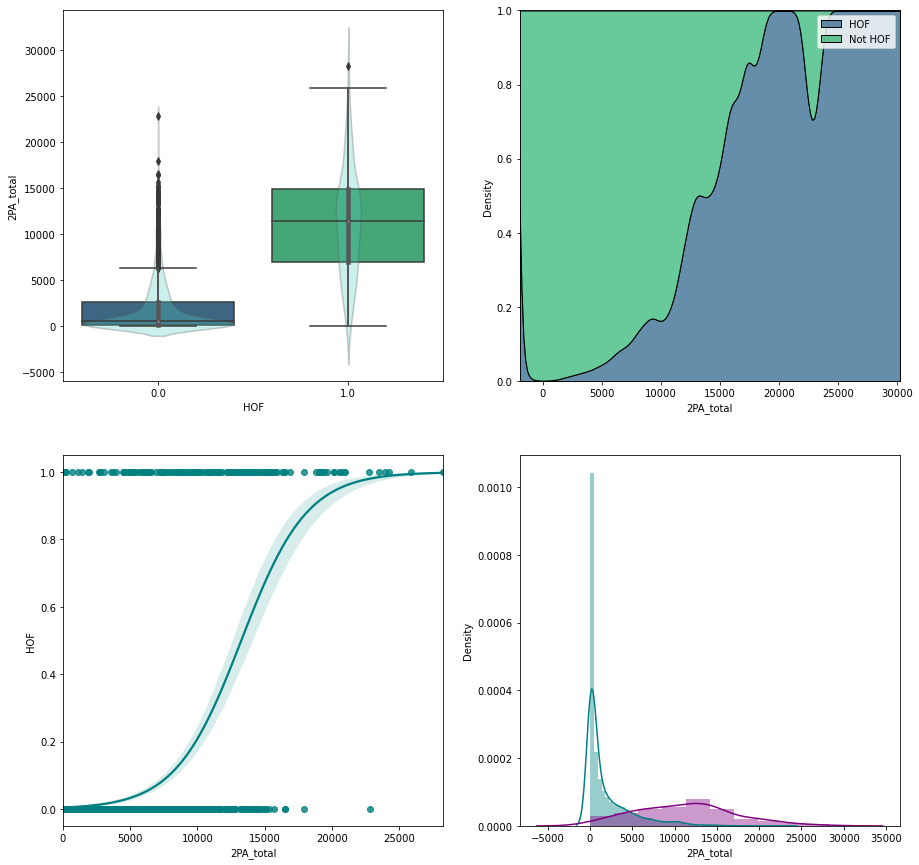

Pearson correlation of FT_total to target HOF: 0.5411534696425903

*** Results for FT_total ***
      count         mean          std   min      25%     50%      75%     max
HOF                                                                          
0.0  3794.0   493.012915   788.761057   0.0    19.25   132.0   637.75  7104.0
1.0   154.0  3355.331169  1926.865893  13.0  2076.50  3145.5  4522.25  9787.0
t-statistic: 18.4, p-value: 9.23e-41
None


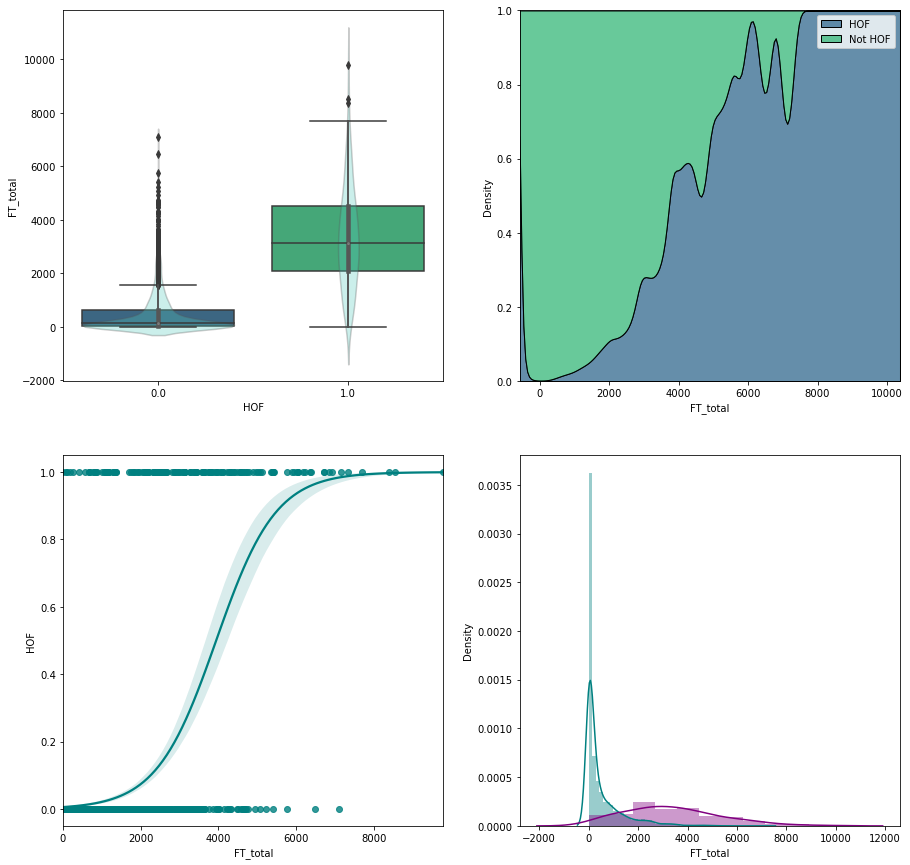

Pearson correlation of FTA_total to target HOF: 0.5434019193342383

*** Results for FTA_total ***
      count         mean          std   min     25%     50%      75%      max
HOF                                                                          
0.0  3794.0   660.059831  1024.421506   0.0    29.0   189.0   894.50   8752.0
1.0   154.0  4411.818182  2544.900184  23.0  2733.0  4117.5  5711.25  13188.0
t-statistic: 18.2, p-value: 2.08e-40
None


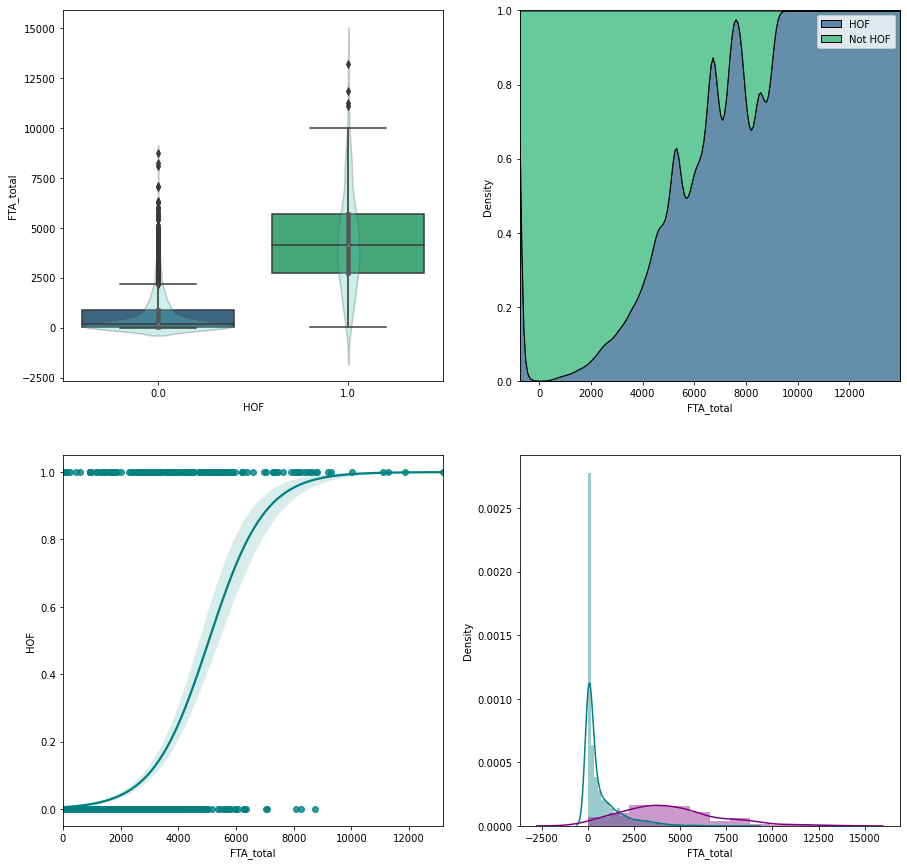

Pearson correlation of ORB_total to target HOF: 0.24500034117560468

*** Results for ORB_total ***
      count         mean          std  min  25%    50%      75%     max
HOF                                                                    
0.0  3794.0   281.571956   503.484099  0.0  2.0   47.0   334.75  4526.0
1.0   154.0  1002.662338  1261.634660  0.0  0.0  457.0  1601.00  6731.0
t-statistic: 7.1, p-value: 4.97e-11
None


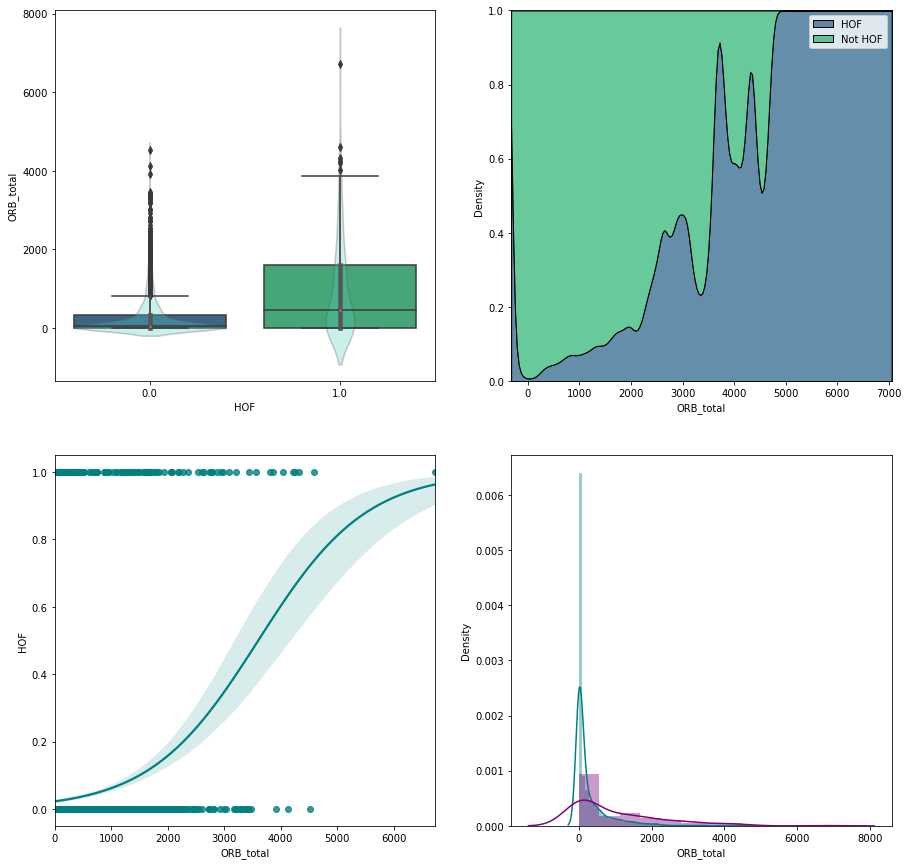

Pearson correlation of DRB_total to target HOF: 0.27796312028950215

*** Results for DRB_total ***
      count         mean          std  min  25%     50%      75%      max
HOF                                                                      
0.0  3794.0   659.967580  1125.683202  0.0  4.0   109.0   874.00   9452.0
1.0   154.0  2533.772727  3024.286489  0.0  0.0  1196.0  4009.75  11453.0
t-statistic: 7.7, p-value: 1.82e-12
None


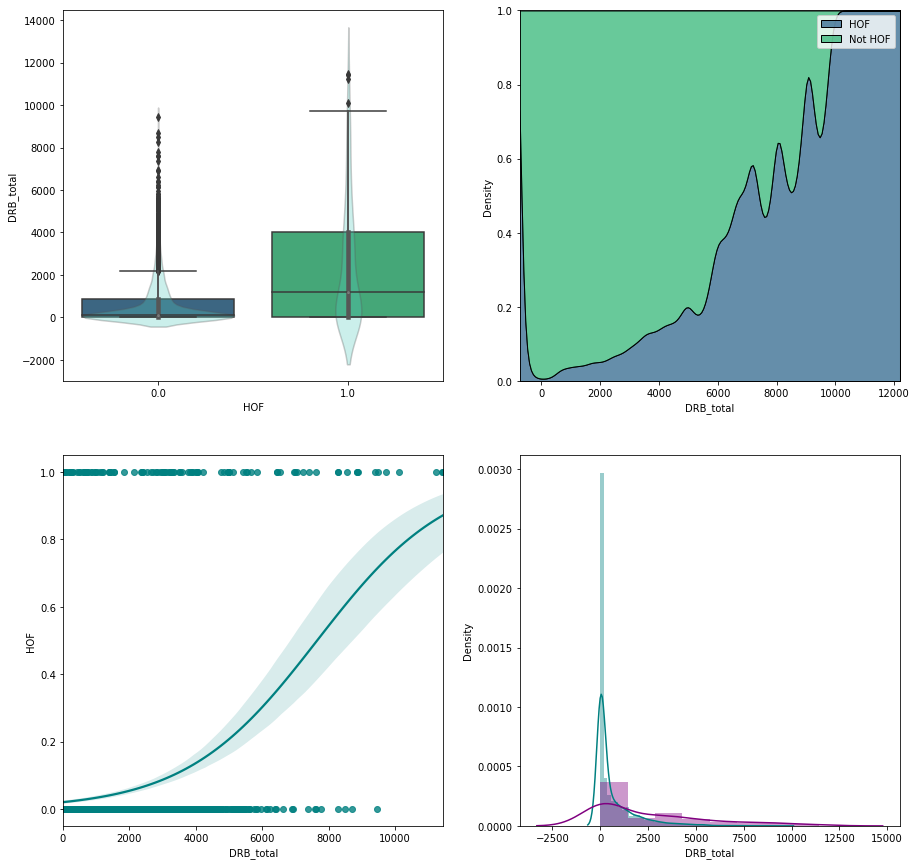

Pearson correlation of TRB_total to target HOF: 0.46232075325021443

*** Results for TRB_total ***
      count         mean          std  min     25%     50%     75%      max
HOF                                                                        
0.0  3794.0  1106.169742  1708.460938  0.0    40.0   294.0  1517.5  13017.0
1.0   154.0  6177.597403  4376.509104  0.0  3412.5  5230.5  7751.0  23924.0
t-statistic: 14.3, p-value: 3.32e-30
None


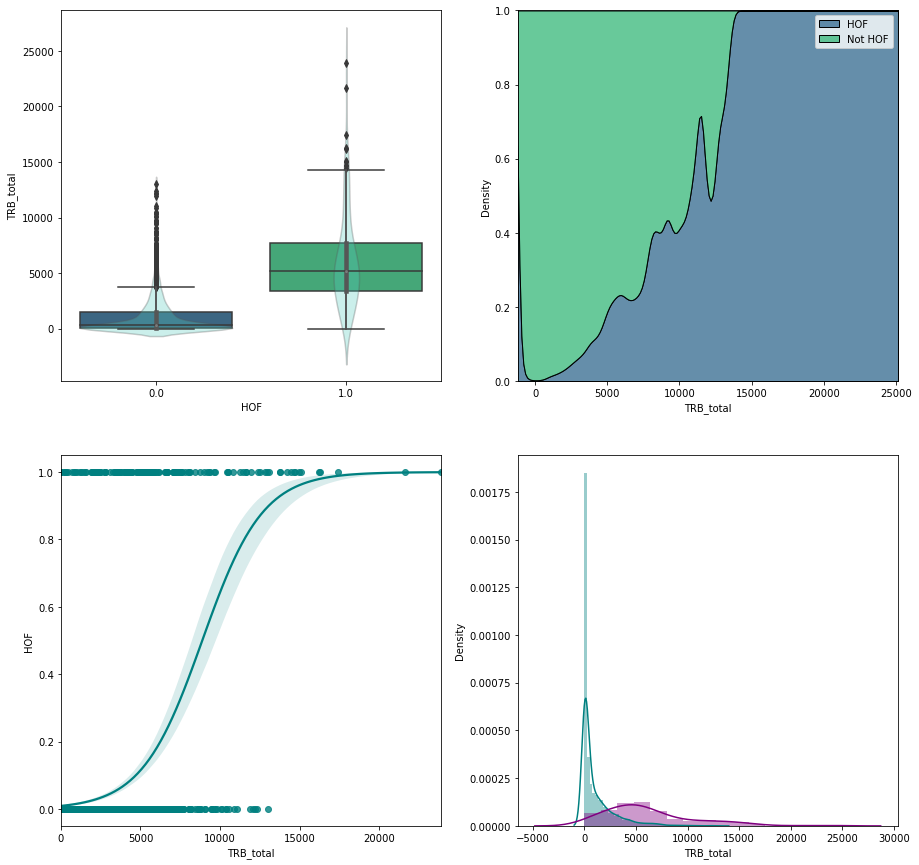

Pearson correlation of AST_total to target HOF: 0.40317059367383445

*** Results for AST_total ***
      count         mean          std  min     25%     50%      75%      max
HOF                                                                         
0.0  3794.0   578.229837  1024.828549  0.0    19.0   138.5   648.75  10334.0
1.0   154.0  3124.954545  2506.929464  6.0  1382.0  2515.0  4209.50  15806.0
t-statistic: 12.6, p-value: 2.04e-25
None


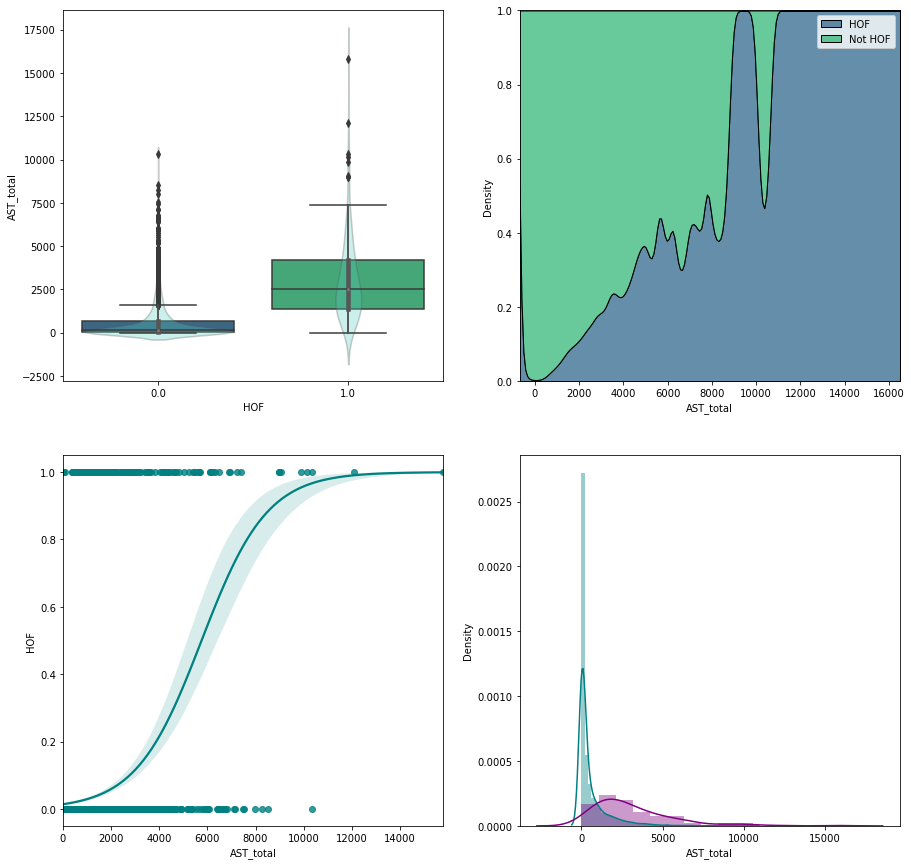

Pearson correlation of STL_total to target HOF: 0.2592947417031011

*** Results for STL_total ***
      count        mean         std  min  25%    50%      75%     max
HOF                                                                  
0.0  3794.0  181.353453  301.207449  0.0  1.0   33.0   232.00  2112.0
1.0   154.0  637.136364  733.865583  0.0  0.0  385.5  1085.75  3265.0
t-statistic: 7.7, p-value: 1.67e-12
None


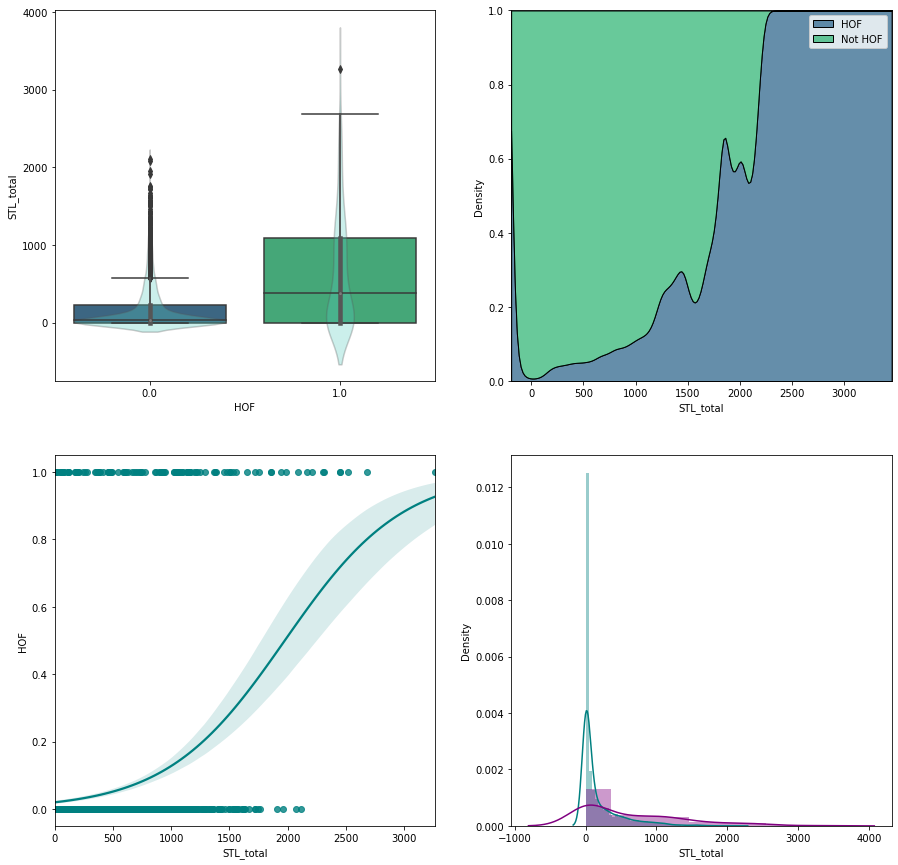

Pearson correlation of BLK_total to target HOF: 0.25390540336991685

*** Results for BLK_total ***
      count        mean         std  min  25%    50%    75%     max
HOF                                                                
0.0  3794.0  108.673432  246.052041  0.0  0.0   12.0  102.0  3064.0
1.0   154.0  499.863636  804.457216  0.0  0.0  112.5  663.0  3830.0
t-statistic: 6.0, p-value: 1.21e-08
None


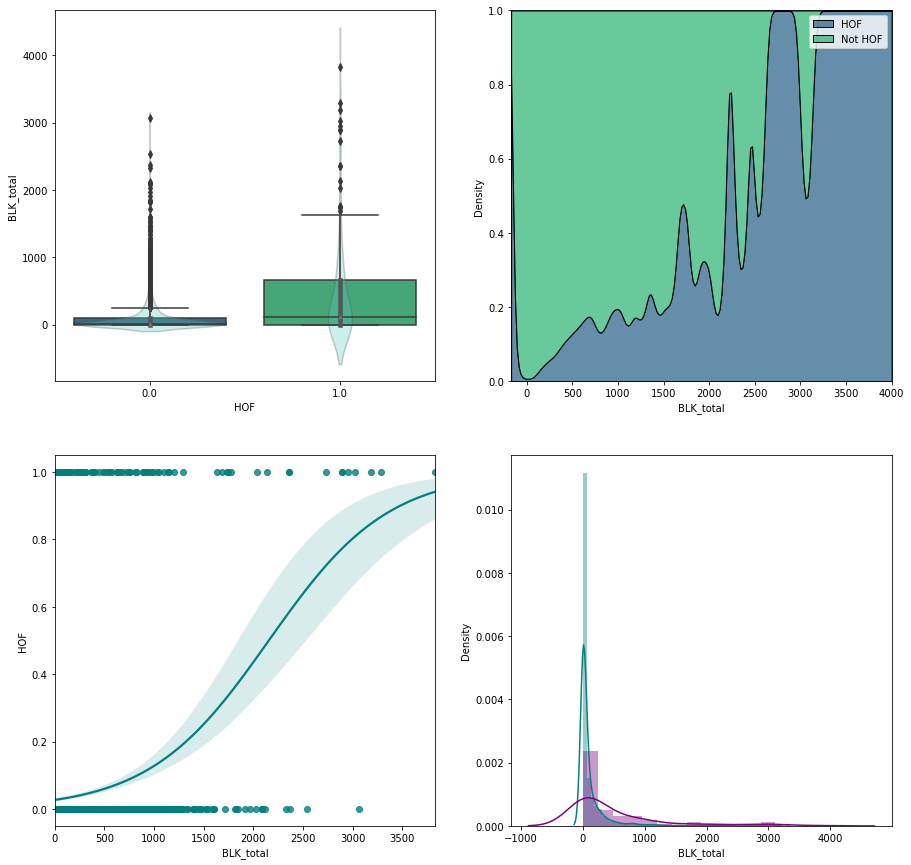

Pearson correlation of TOV_total to target HOF: 0.2629411990238913

*** Results for TOV_total ***
      count         mean          std  min  25%    50%     75%     max
HOF                                                                   
0.0  3794.0   315.539009   528.917373  0.0  0.0   47.0   403.0  3793.0
1.0   154.0  1133.636364  1334.494626  0.0  0.0  536.5  2321.0  4524.0
t-statistic: 7.6, p-value: 2.9e-12
None


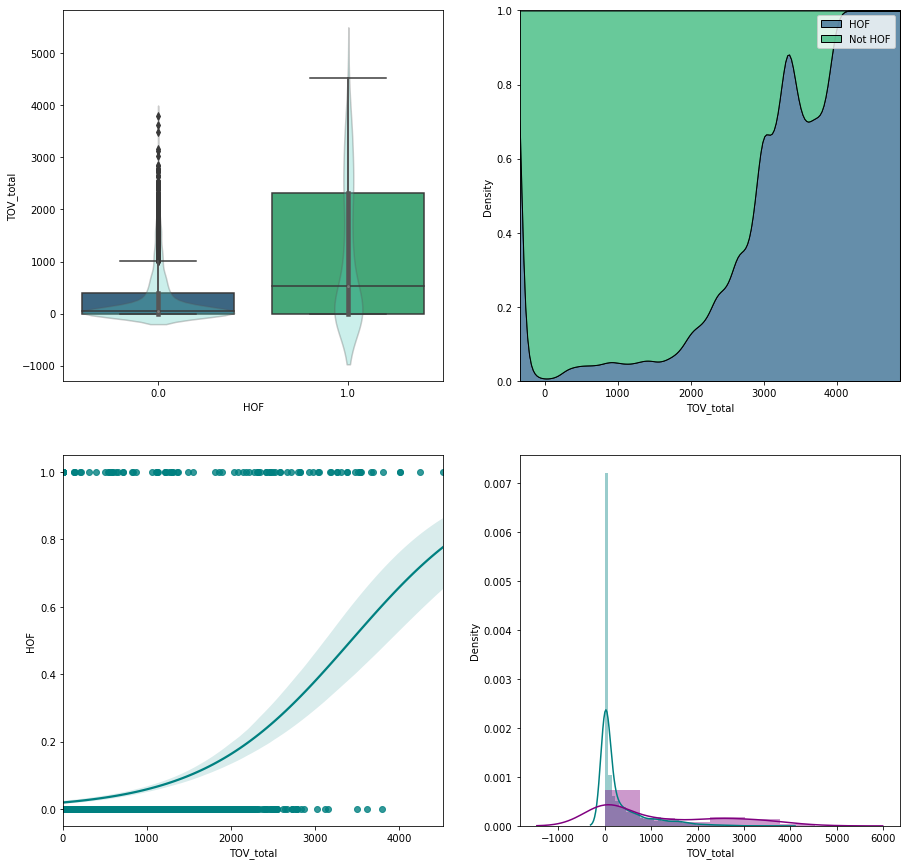

Pearson correlation of PF_total to target HOF: 0.3951529492139091

*** Results for PF_total ***
      count         mean         std   min     25%     50%      75%     max
HOF                                                                        
0.0  3794.0   610.645756  776.066059   0.0    40.0   228.5   965.00  4668.0
1.0   154.0  2350.129870  941.340004  29.0  1818.5  2371.5  2878.25  4657.0
t-statistic: 22.6, p-value: 6.07e-52
None


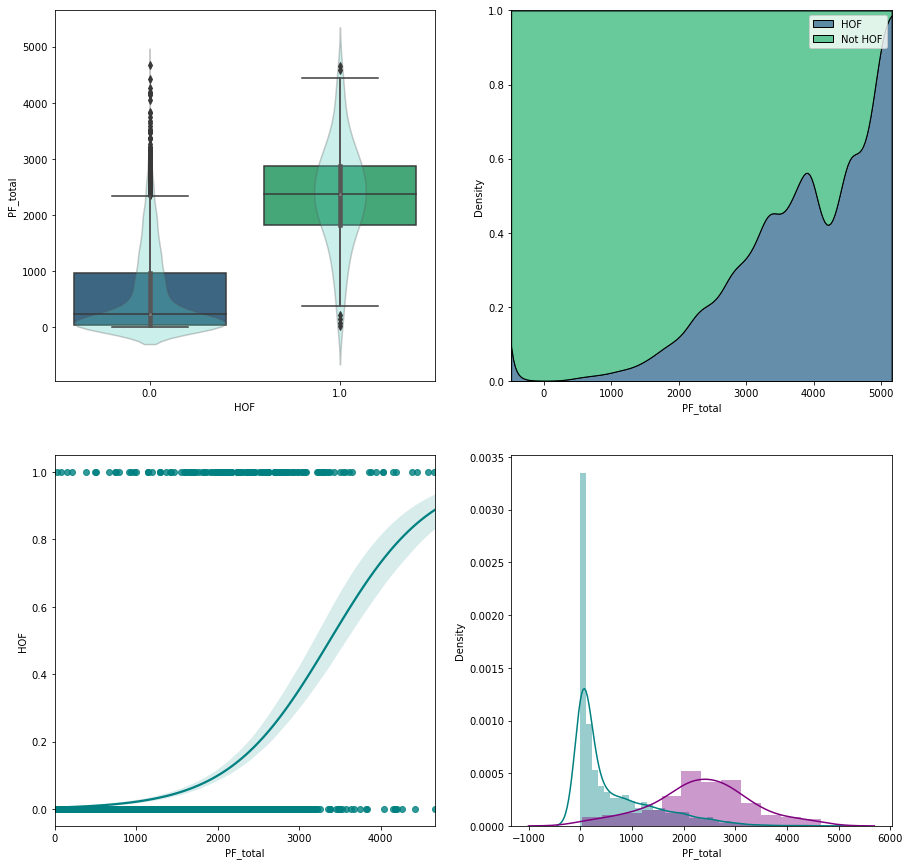

Pearson correlation of PTS_total to target HOF: 0.49549858771513033

*** Results for PTS_total ***
      count          mean          std   min     25%      50%       75%  \
HOF                                                                       
0.0  3794.0   2540.998682  3838.959169   0.0   100.0    686.5   3463.75   
1.0   154.0  14583.558442  8106.479615  39.0  8535.0  14618.0  19231.25   

         max  
HOF           
0.0  30260.0  
1.0  38387.0  
t-statistic: 18.4, p-value: 8.77e-41
None


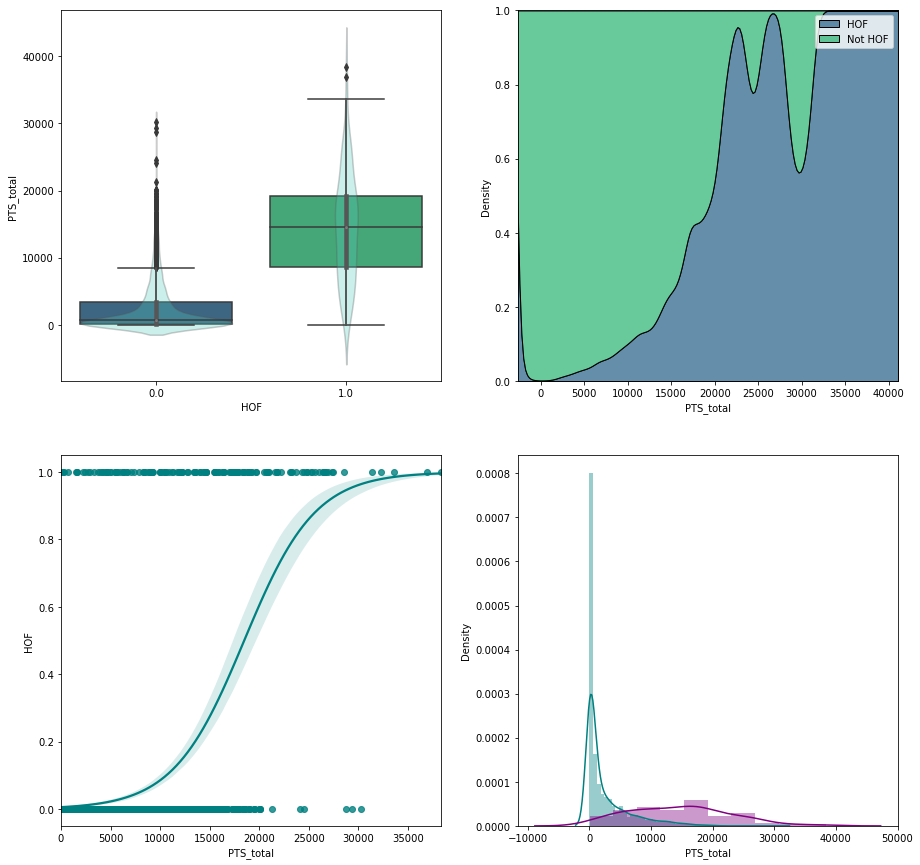

Pearson correlation of WOR_Year_total to target HOF: 0.3901562734577808

*** Results for WOR_Year_total ***
      count       mean        std    min   25%    50%       75%     max
HOF                                                                    
0.0  3794.0   6.119834  20.184125 -27.27 -1.08   0.00    2.1600  313.20
1.0   154.0  60.118831  74.889348 -12.42  0.00  19.71  103.4775  282.15
t-statistic: 8.9, p-value: 1.18e-15
None


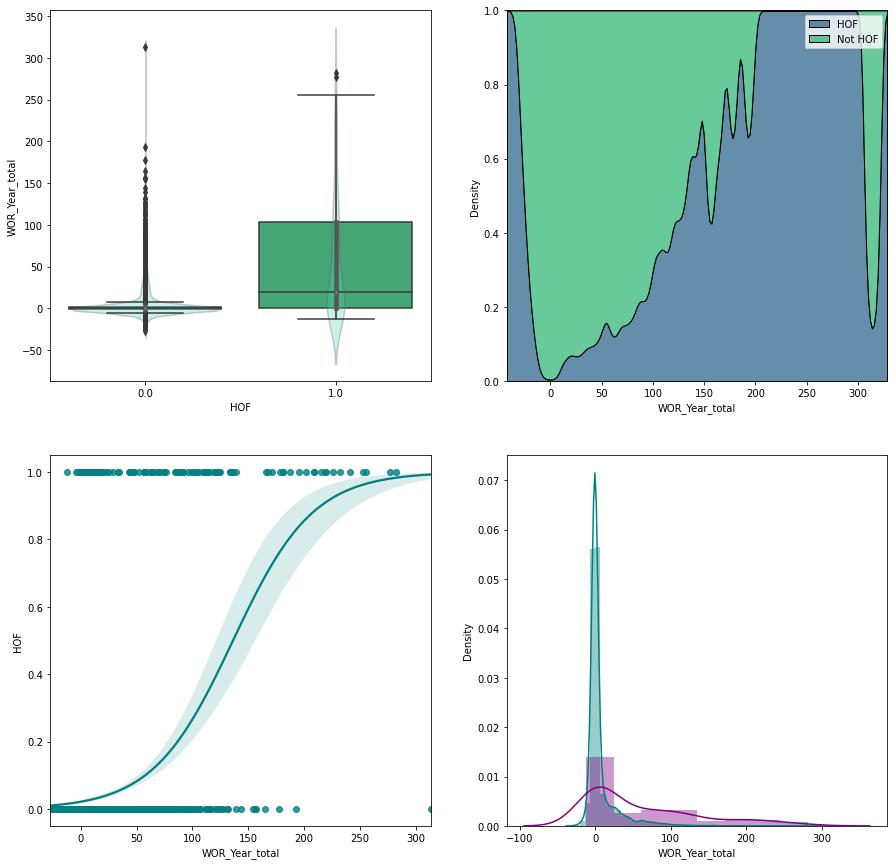

Pearson correlation of championship_total to target HOF: 0.3499243017307592

*** Results for championship_total ***
      count      mean       std  min  25%  50%  75%   max
HOF                                                      
0.0  3794.0  0.184502  0.562669  0.0  0.0  0.0  0.0   7.0
1.0   154.0  1.532468  2.178831  0.0  0.0  1.0  2.0  11.0
t-statistic: 7.7, p-value: 1.86e-12
None


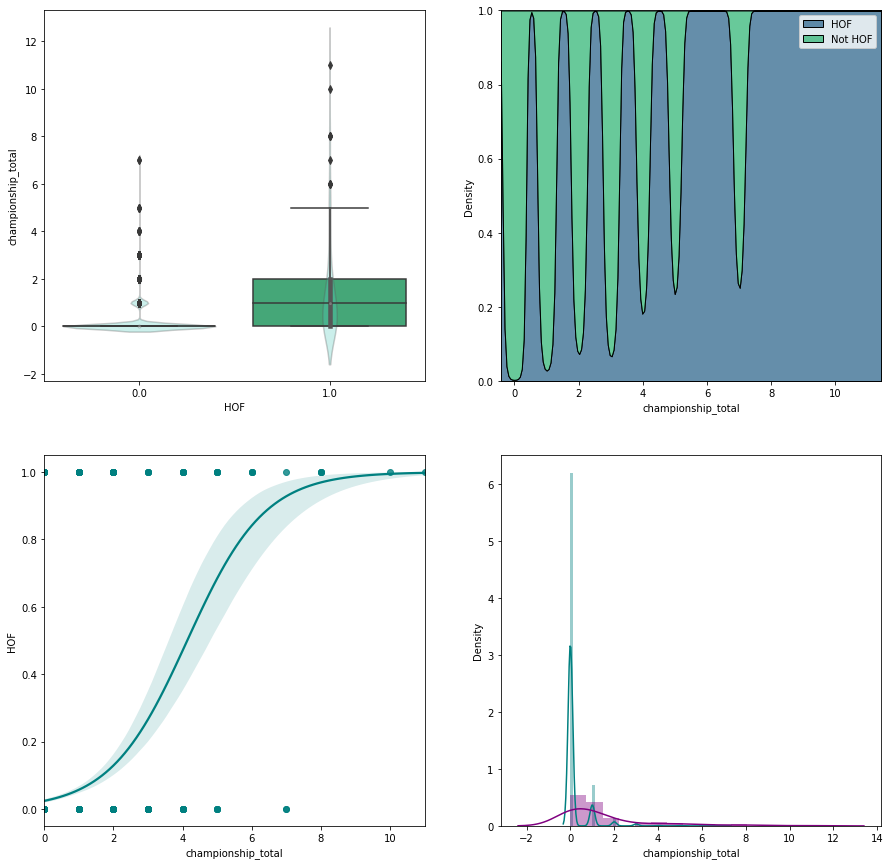

In [517]:
for col in continuous_cols:
    print("Pearson correlation of {} to target HOF: {}".format(col, career_df[col].corr(career_df.HOF)))
    univariate_breakdown(career_df, col ,'HOF')

In [100]:
career_df[continuous_cols + ["HOF"]].corr()

Year  G_average  GS_average  MP_average       PER  \
Year                  1.000000  -0.009117    0.032634   -0.013907  0.057316   
G_average            -0.009117   1.000000    0.716285    0.884041  0.405661   
GS_average            0.032634   0.716285    1.000000    0.895995  0.403232   
MP_average           -0.013907   0.884041    0.895995    1.000000  0.450796   
PER                   0.057316   0.405661    0.403232    0.450796  1.000000   
TS%                   0.302820   0.388613    0.315900    0.376218  0.742103   
3PAr                  0.452881   0.001927   -0.010444    0.024235 -0.060650   
FTr                  -0.107538  -0.065803   -0.031116   -0.050079  0.113410   
ORB%                 -0.066512  -0.127536   -0.072728   -0.141358  0.212559   
DRB%                  0.105364   0.050033    0.115709    0.052171  0.216054   
TRB%                  0.032046  -0.031747    0.035602   -0.034245  0.247563   
AST%                 -0.012746   0.181459    0.212554    0.250158  0.222288   
STL%                 -0.014202   0.016210    0.015290    0.031454  0.154110   
BLK%                  0.176083   0.028899    0.083538    0.007925  0.150610   
TOV%                 -0.164489  -0.129643   -0.125274   -0.142280 -0.313633   
USG%                 -0.047750  -0.036791    0.125214    0.083517  0.155424   
OWS_average           0.050497   0.531988    0.763247    0.749762  0.472990   
DWS_average          -0.002440   0.741755    0.830250    0.868100  0.426051   
WS_average            0.032640   0.670310    0.845848    0.863275  0.493339   
WS/48                 0.091651   0.407416    0.346954    0.407832  0.888830   
OBPM                  0.021180   0.505206    0.449943    0.534757  0.883349   
DBPM                  0.061283   0.387648    0.328455    0.350371  0.174252   
BPM                   0.045216   0.582528    0.514116    0.588773  0.784139   
VORP_average          0.025280   0.455968    0.728106    0.684702  0.415992   
FG_average            0.003336   0.783177    0.863289    0.942055  0.474292   
FGA_average          -0.044555   0.798092    0.859286    0.948446  0.458855   
FG%                   0.238487   0.341156    0.266492    0.316941  0.689455   
3P_average            0.321684   0.440160    0.482336    0.529842  0.218387   
3PA_average           0.328942   0.460425    0.496833    0.548486  0.222129   
3P%                   0.227398   0.080066    0.106191    0.129560  0.177323   
2P_average           -0.070830   0.763003    0.832688    0.915019  0.465822   
2PA_average          -0.149343   0.772863    0.829362    0.915626  0.448379   
2P%                   0.333004   0.317768    0.245652    0.297372  0.632626   
eFG%                  0.358451   0.346339    0.278880    0.329216  0.688625   
FT_average           -0.096902   0.703169    0.814611    0.872966  0.465437   
FTA_average          -0.113490   0.716202    0.821576    0.877460  0.465782   
FT%                   0.058092   0.279906    0.219040    0.297318  0.299295   
ORB_average          -0.104747   0.671950    0.676505    0.715260  0.382924   
DRB_average           0.001854   0.737547    0.804130    0.833517  0.421272   
TRB_average          -0.067559   0.720392    0.776966    0.818769  0.416067   
AST_average          -0.019570   0.656499    0.692532    0.789483  0.359623   
STL_average          -0.084272   0.764411    0.777930    0.867667  0.403111   
BLK_average           0.023290   0.503602    0.584762    0.552768  0.309973   
TOV_average          -0.120034   0.798533    0.838503    0.919287  0.434749   
PF_average           -0.125097   0.885813    0.780701    0.903112  0.398990   
PTS_average           0.007625   0.779329    0.867375    0.943736  0.479062   
WOR_Year_average      0.129682   0.402733    0.730006    0.612047  0.377440   
years_in_league       0.168800   0.562976    0.605389    0.680057  0.340808   
ppg                   0.009638   0.692759    0.827247    0.890404  0.526693   
championship_average -0.088261   0.060221    0.037865    0.058642  0.046329 

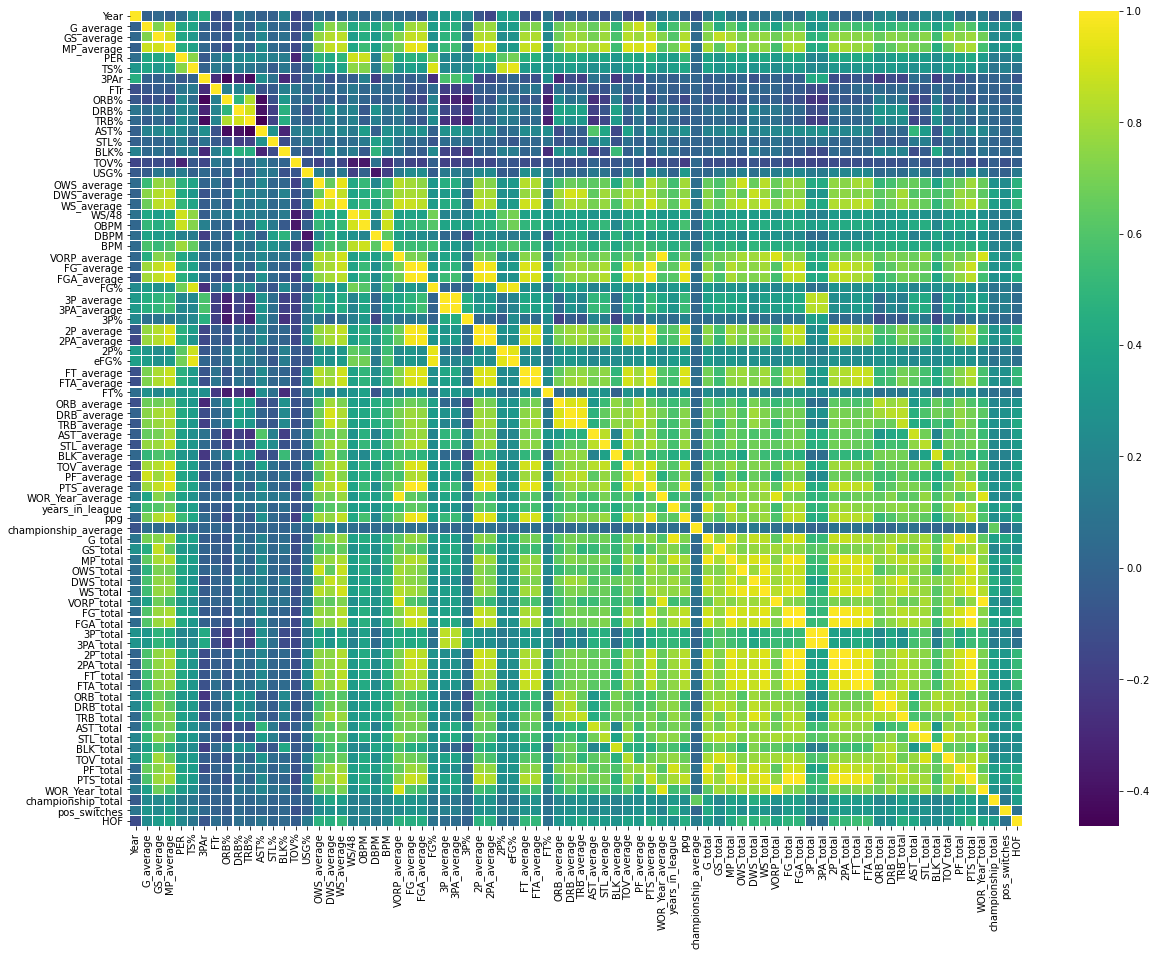

In [101]:
plt.subplots(figsize=(20,15))
sns.heatmap(career_df[continuous_cols + ["HOF"]].corr(), linewidths = 0.1, cmap = "viridis")
# params not used annot = True, fmt=".2"
plt.show()

# Categorical Column view

In [65]:
def univariate_barplot(df, feat1, feat2):
    plt.figure(figsize = (12,8))
    sns.barplot(y = df[feat1], x = df[feat2], palette = "viridis", orient = "h")
    plt.show()

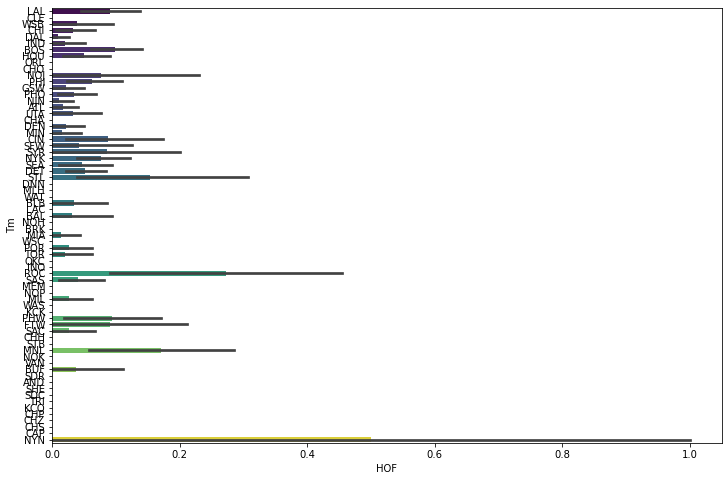

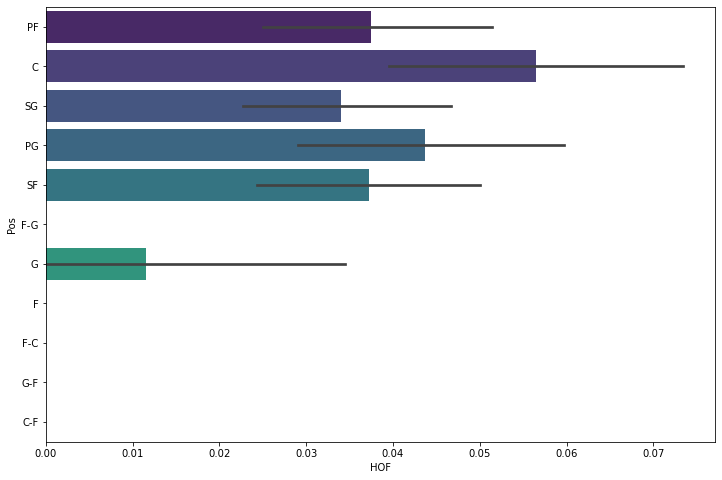

In [66]:
for cat in ['Tm','Pos']:
    univariate_barplot(career_df,cat,'HOF')

# Modeling
### train test holdout set

In [172]:
def mean_encoding(df,col,target,m, test_df, val_df = None):
    """
    We compute mean encoding of target/ labels only in the training set and then apply these values
    to their respected counterpart variants in the test set and validation set (if applicable).
    The values are calculated this way in order to avoid target leakage. 
    """
    # compute mean
    mean = df[target].mean()
    # compute means and counts per group for smoothing
    df['{}_mean'.format(col)] = df.groupby(col)[target].transform('mean')
    df['{}_count'.format(col)] = df.groupby(col)[target].transform('count')
    df['{}_encoded'.format(col)] = (  (df['{}_mean'.format(col)] * df['{}_count'.format(col)] + m * mean) 
                        / (df['{}_count'.format(col)] + m) )
    means = df[[col,'{}_encoded'.format(col)]].drop_duplicates()
    df.drop(columns= [col,'{}_mean'.format(col),'{}_count'.format(col)],inplace= True)
    test_df = test_df.merge(right = means, on = col, how = 'left')
    test_df['{}_encoded'.format(col)].fillna(mean, inplace = True)
    test_df.drop(columns= col,inplace= True)
    if val_df is not None:
        val_df = val_df.merge(right = means, on = col, how = 'left')
        val_df['{}_encoded'.format(col)].fillna(mean, inplace = True)
        val_df.drop(columns= col,inplace= True)

    return df,test_df,val_df

    

In [173]:
def get_train_test_holdout(model_df):
    model_df = model_df.sample(frac=1, random_state = 33).reset_index(drop=True)
    model_df.drop(columns = 'Tm',inplace = True)
    X = pd.get_dummies(model_df, drop_first = True, columns = ['Pos'])
    y = model_df[["HOF"]].values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state= 33 )
    # for holdout set take piece of train 0.125 x 0.8 = 0.1 of whole set
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.125, random_state= 33 ) 
    target_weight = (len(y_train) - y_train[:,0].sum()) / y_train[:,0].sum()
    # we do not want to mean encode the mode of the team value, it introduces a lot of false negatives
    #X_train, X_test, X_val = mean_encoding(X_train, 'Tm','HOF',0.5, X_test, X_val)
    #print(X_train.columns)
    return X_train, y_train, X_test, y_test, X_val, y_val, target_weight
    
def model_summary(model, X_train, y_train, X_test, y_test, threshold = 0.5):
    # train set predictions
    train_pred_prob = model.predict_proba(X_train)[:,1]
    train_pred = (train_pred_prob > threshold).astype("int")
    # test set predictions
    test_pred_prob = model.predict_proba(X_test)[:,1]
    test_pred = (test_pred_prob > threshold).astype("int")
    # model report
    print("Confusion Matrix for Test Set")
    print(confusion_matrix(y_test, test_pred))
    
    print("\n Classification Report for Test Set")
    print(classification_report(y_test, test_pred))
    
    print("Accuracy Train: {:.4f}".format(accuracy_score(y_train, train_pred)))
    print("AUC Train: {}".format(roc_auc_score(y_train, train_pred)))
    print("Accuracy Test: {:.4f}".format(accuracy_score(y_test, test_pred)))
    print("AUC Test: {}".format(roc_auc_score(y_test, test_pred)))
    
def plot_roc_curve(model, X_test, y_test):
    y_pred = model.predict_proba(X_test)[:,1]
    y_pred_pred = model.predict(X_test)
    test_auc = roc_auc_score(y_test, y_pred_pred)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    plt.figure()
    plt.plot(fpr, tpr, label = "AUC = {:.3f}".format(test_auc))
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([0,1])
    plt.ylim([0,1.05])
    plt.title("ROC Plot")
    plt.legend(loc = "lower right")
    plt.show()

In [174]:
X_train, y_train, X_test, y_test, X_val, y_val, target_weight = get_train_test_holdout(career_df)

## XGBoost

[16:52:22] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Simple XGBoost Result
Confusion Matrix for Test Set
[[736  16]
 [ 11  27]]

 Classification Report for Test Set
              precision    recall  f1-score   support

         0.0       0.99      0.98      0.98       752
         1.0       0.63      0.71      0.67        38

    accuracy                           0.97       790
   macro avg       0.81      0.84      0.82       790
weighted avg       0.97      0.97      0.97       790

Accuracy Train: 1.0000
AUC Train: 1.0
Accuracy Test: 0.9658
AUC Test: 0.8446248600223965


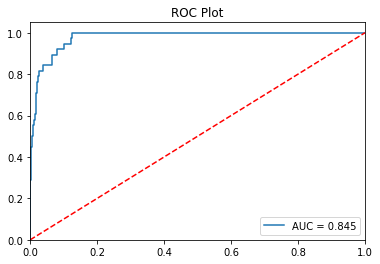

In [175]:
# baseline XGB
seed = 30
simple_xgb = xgb.XGBClassifier(random_state = seed, scale_pos_weight = target_weight)
simple_xgb.fit(X_train.drop(columns = ["HOF","player_key"]), y_train)
simple_xgb_pred_prob = simple_xgb.predict_proba(X_test.drop(columns = ["HOF","player_key"]))[:,1]
simple_xgb_pred = simple_xgb.predict(X_test.drop(columns = ["HOF","player_key"]))

print("Simple XGBoost Result")
model_summary(simple_xgb, X_train.drop(columns = ["HOF","player_key"]), y_train,
              X_test.drop(columns = ["HOF","player_key"]), y_test)
plot_roc_curve(simple_xgb, X_test.drop(columns = ["HOF","player_key"]), y_test)

Confusion Matrix for Test Set
[[370   9]
 [  4  12]]

 Classification Report for Test Set
              precision    recall  f1-score   support

         0.0       0.99      0.98      0.98       379
         1.0       0.57      0.75      0.65        16

    accuracy                           0.97       395
   macro avg       0.78      0.86      0.82       395
weighted avg       0.97      0.97      0.97       395

Accuracy Train: 1.0000
AUC Train: 1.0
Accuracy Test: 0.9671
AUC Test: 0.8631266490765171


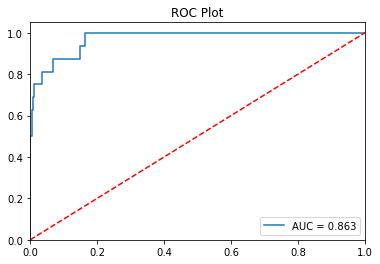

In [176]:
# holdout set results
val_pred = simple_xgb.predict(X_val.drop(columns = ["HOF","player_key"]))
val_pred_proba = simple_xgb.predict_proba(X_val.drop(columns = ["HOF","player_key"]))[:,1]

model_summary(simple_xgb, X_train.drop(columns = ["HOF","player_key"]), y_train,
              X_val.drop(columns = ["HOF","player_key"]), y_val)
plot_roc_curve(simple_xgb, X_val.drop(columns = ["HOF","player_key"]), y_val)

In [177]:
Xt = X_test.copy()
Xt['pred'] = simple_xgb_pred
Xt['pred_proba'] = simple_xgb_pred_prob
Xv = X_val.copy()
Xv['pred'] = val_pred
Xv['pred_proba'] = val_pred_proba
df_results = pd.concat([Xt,Xv], axis = 0)

In [178]:
df_results.loc[((df_results.HOF == 1)& (df_results.pred == 0))].sort_values(by = 'pred_proba')

player_key         Year  G_average  GS_average  \
1087       Bob HoubregsMarch 12, 1932  1955.800000  43.400000         NaN   
2720        Wayne EmbryMarch 26, 1937  1964.000000  75.545455         NaN   
370   Alfred McGuireSeptember 7, 1928  1953.500000  47.750000         NaN   
1812       Red HolzmanAugust 10, 1920  1952.000000  59.600000         NaN   
258       Don BarksdaleMarch 31, 1923  1953.500000  65.500000         NaN   
1108        Bill BradleyJuly 28, 1943  1972.500000  74.200000         NaN   
356     Spencer HaywoodApril 22, 1949  1976.846154  58.461538   44.000000   
3730   Charlie ScottDecember 15, 1948  1976.200000  56.000000         NaN   
2341       Pete MaravichJune 22, 1947  1975.909091  59.818182    4.000000   
2493  Drazen PetrovicOctober 22, 1964  1991.400000  58.000000   29.800000   
2241       Bobby JonesJanuary 9, 1984  1991.375000  54.062500   11.818182   
459   Maurice CheeksSeptember 8, 1956  1986.250000  68.812500   56.615385   
1751           Joe DumarsMay 24, 1963  1992.500000  72.714286   67.428571   
2421     Earl MonroeNovember 21, 1944  1973.857143  66.142857         NaN   
3176         Jamaal WilkesMay 2, 1953  1980.500000  69.000000   49.000000   

       MP_average        PER       TS%      3PAr       FTr      ORB%  \
1087  1079.800000  16.220000  0.458000       NaN  0.478400       NaN   
2720  1978.454545  14.800000  0.476364       NaN  0.415545       NaN   
370    741.500000  11.266667  0.409250       NaN  0.600250       NaN   
1812   702.000000   6.966667  0.359800       NaN  0.292800       NaN   
258   1865.000000  15.250000  0.437250       NaN  0.484250       NaN   
1108  2279.900000  12.040000  0.485000       NaN  0.192300  2.300000   
356   1969.230769  16.746154  0.513846  0.004667  0.297077  8.610000   
3730  1927.800000  14.230000  0.481300  0.016000  0.242000  2.900000   
2341  2210.545455  17.527273  0.500273  0.026500  0.293364  2.450000   
2493  1533.800000  16.140000  0.569600  0.151200  0.299000  4.720000   
2241  1315.250000  14.131250  0.560875  0.139615  0.373812  6.106250   
459   2177.812500  16.137500  0.571312  0.024533  0.307813  2.268750   
1751  2509.928571  15.164286  0.555214  0.231000  0.307000  2.142857   
2421  2116.857143  16.628571  0.511714  0.000000  0.285071  2.028571   
3176  2272.916667  15.641667  0.525417  0.012429  0.245583  6.633333   

           DRB%       TRB%       AST%      STL%      BLK%       TOV%  \
1087        NaN        NaN        NaN       NaN       NaN        NaN   
2720        NaN        NaN   6.680000       NaN       NaN        NaN   
370         NaN        NaN        NaN       NaN       NaN        NaN   
1812        NaN        NaN        NaN       NaN       NaN        NaN   
258         NaN        NaN        NaN       NaN       NaN        NaN   
1108   7.275000   4.814286  15.670000  1.050000  0.375000        NaN   
356   17.560000  13.453846   7.607692  0.830000  1.820000  14.583333   
3730   7.600000   5.350000  20.700000  1.762500  0.487500  18.650000   
2341   8.225000   5.290909  21.718182  1.550000  0.350000  13.600000   
2493   6.360000   5.520000  16.200000  1.760000  0.140000  13.680000   
2241  14.031250  10.168750  10.518750  2.512500  1.737500  16.246667   
459    7.475000   4.918750  28.587500  3.156250  0.450000  17.568750   
1751   5.028571   3.585714  20.714286  1.307143  0.128571  12.650000   
2421   6.700000   4.227273  17.135714  1.514286  0.457143  10.233333   
3176  12.550000   9.675000  10.258333  1.733333  0.508333  11.955556   

           USG%  OWS_average  DWS_average  WS_average     WS/48      OBPM  \
1087        NaN     2.040000     0.800000    2.860000  0.102600       NaN   
2720        NaN     2.072727     1.372727    3.418182  0.078364       NaN   
370         NaN     0.900000     0.933333    1.800000  0.085333       NaN   
1812        NaN    -0.620000     0.840000    0.220000 -0.055333       NaN   
258         NaN     1.350000     0.950000    2.275000  0.060500       NaN   
1108        NaN     1.5400

In [179]:
df_results.loc[((df_results.HOF == 0)& (df_results.pred == 1))].sort_values(by = 'pred_proba', ascending = False)

player_key         Year  G_average  GS_average  \
2130          Chuck ShareMarch 14, 1927  1955.333333  61.666667         NaN   
2608       Joe GraboskiJanuary 15, 1930  1955.909091  69.272727         NaN   
1610           Jack ColemanMay 23, 1924  1954.200000  63.300000         NaN   
1865         Kenny SearsAugust 17, 1933  1960.111111  58.777778         NaN   
2319        Shawn KempNovember 26, 1969  1996.500000  75.071429   52.000000   
3586         Buck WilliamsMarch 8, 1960  1990.000000  76.882353   67.058824   
3895     Brad DaughertyOctober 19, 1965  1990.500000  68.500000   68.250000   
3582          Archie ClarkJuly 15, 1941  1971.545455  65.909091         NaN   
1003         Dirk NowitzkiJune 19, 1978  2008.000000  73.368421   71.736842   
310          Kevin JohnsonMarch 4, 1966  1993.153846  56.538462   47.923077   
1326       Clifford RayJanuary 21, 1949  1976.500000  78.400000         NaN   
692               Red KerrJuly 17, 1932  1960.500000  75.416667         NaN   
735          Ed ConlinSeptember 2, 1933  1959.000000  60.750000         NaN   
2248        John DrewSeptember 30, 1954  1980.000000  67.181818   26.000000   
1805           Jeff HornacekMay 3, 1963  1993.533333  71.800000   60.666667   
1451          Otis ThorpeAugust 5, 1962  1993.368421  66.157895   52.052632   
972             Tony ParkerMay 17, 1982  2009.500000  71.437500   70.625000   
3804      LeBron JamesDecember 30, 1984  2010.500000  75.785714   75.714286   
3839         Jeff MullinsMarch 18, 1942  1970.500000  67.000000         NaN   
2850  Dick Van ArsdaleFebruary 22, 1943  1971.500000  76.750000         NaN   
3261     Kevin DurantSeptember 29, 1988  2012.500000  70.300000   70.300000   
1967       Reggie TheusOctober 13, 1957  1984.928571  73.285714   67.545455   
3117        Red RochaSeptember 18, 1923  1953.428571  68.571429         NaN   
3207          Tom ChambersJune 21, 1959  1989.625000  69.187500   46.437500   
2814       Flynn RobinsonApril 28, 1941  1970.000000  49.400000         NaN   

       MP_average        PER       TS%      3PAr       FTr       ORB%  \
2130  1374.666667  17.533333  0.469556       NaN  0.695333        NaN   
2608  2219.700000  13.510000  0.409545       NaN  0.362818        NaN   
1610  2059.875000  15.550000  0.449500       NaN  0.235200        NaN   
1865  1658.111111  16.988889  0.551667       NaN  0.550444        NaN   
2319  2092.357143  18.350000  0.545500  0.011357  0.490571  11.985714   
3586  2497.882353  15.023529  0.584824  0.002471  0.506941  11.852941   
3895  2503.625000  18.700000  0.586500  0.002000  0.515000   7.012500   
3582  2143.727273  16.763636  0.538727       NaN  0.332727   2.133333   
1003  2561.736842  22.178947  0.572789  0.213579  0.348316   3.336842   
310   1927.769231  19.738462  0.581538  0.056231  0.479615   2.153846   
1326  1994.000000  13.700000  0.540700  0.002500  0.442900  10.300000   
692   2315.333333  16.708333  0.464750       NaN  0.317083        NaN   
735   1424.000000  12.650000  0.423750       NaN  0.305250        NaN   
2248  1984.363636  20.245455  0.536091  0.011333  0.499273   9.972727   
1805  2264.266667  17.446667  0.580000  0.168400  0.292133   3.180000   
1451  2095.894737  15.289474  0.572474  0.005368  0.411737   9.731579   
972   2262.812500  18.331250  0.545562  0.106375  0.284375   1.318750   
3804  2948.000000  27.700000  0.585500  0.206000  0.419286   3.750000   
3839  2047.833333  15.441667  0.496417       NaN  0.228417   3.666667   
2850  2647.583333  14.083333  0.535583       NaN  0.451667   2.275000   
3261  2627.800000  25.410000  0.610200  0.257500  0.413500   2.390000   
1967  2471.642857  16.271429  0.539286  0.067846  0.386643   3.807143   
3117  2101.400000  13.000000  0.449000       NaN  0.405143        NaN   
3207  2120.125000  15.912500  0.554125  0.045813  0.416500   5.987500   
2814  1156.900000  16.970000  0.497500       NaN  0.329500        NaN   

           DRB%       TRB%       AST%      STL%      BLK%       TOV%  \
213

In [180]:
# shap results for model
mybooster = simple_xgb.get_booster()
model_bytearray = mybooster.save_raw()[4:]
def myfunc(self = None):
    return model_bytearray
mybooster.save_raw = myfunc

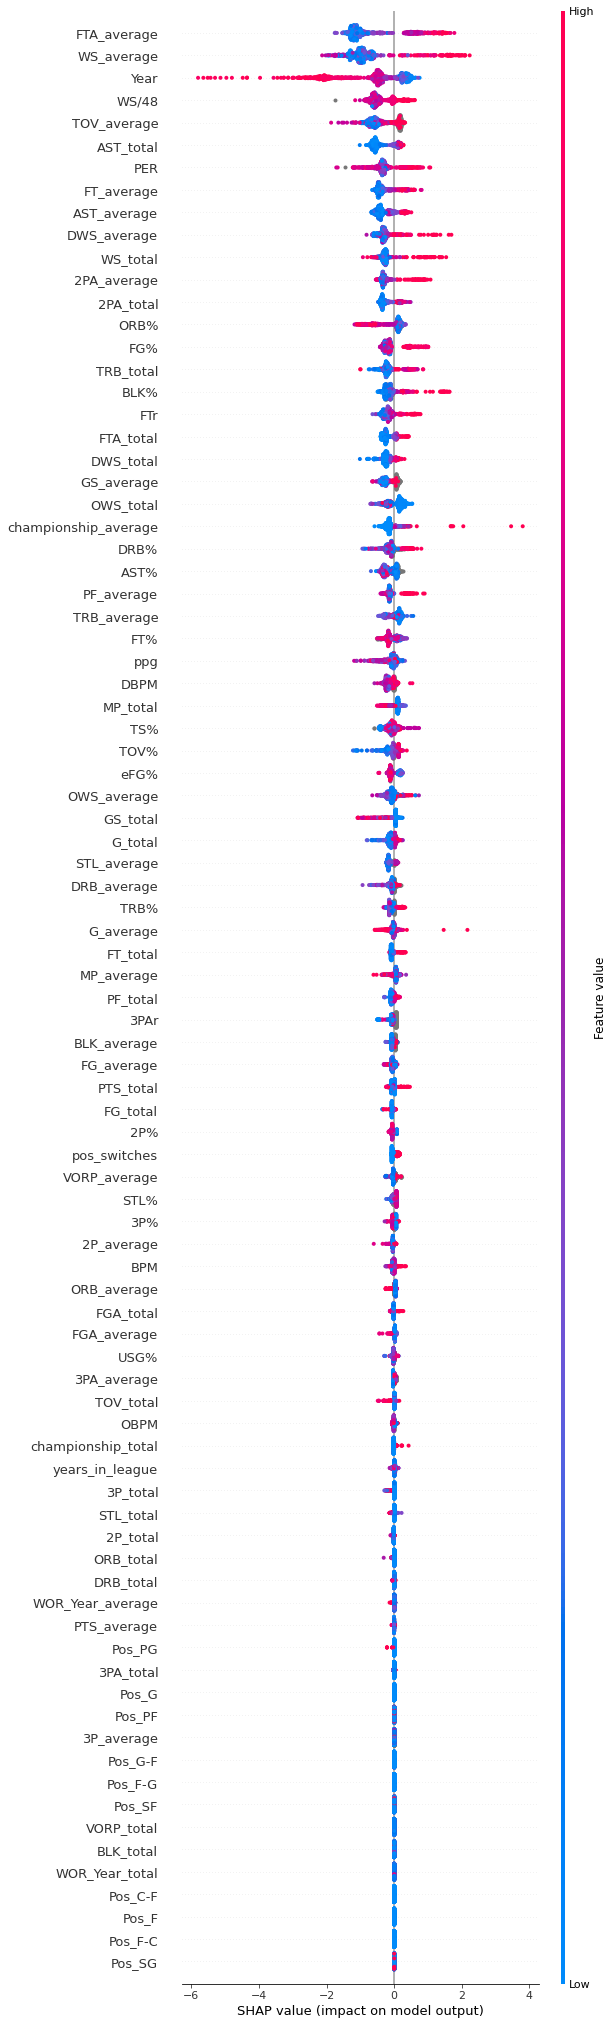

In [181]:
explainer = shap.TreeExplainer(mybooster)
simple_shap_values = explainer.shap_values(X_test.drop(columns = ["HOF","player_key"]))
shap.summary_plot(simple_shap_values, X_test.drop(columns = ["HOF","player_key"]), 
                  max_display = X_test.drop(columns = ["HOF","player_key"]).columns.nunique())